[(0, 'pred_iter_0'), (100, 'pred_iter_100'), (200, 'pred_iter_200'), (300, 'pred_iter_300'), (400, 'pred_iter_400'), (500, 'pred_iter_500'), (600, 'pred_iter_600'), (700, 'pred_iter_700'), (800, 'pred_iter_800'), (900, 'pred_iter_900'), (1000, 'pred_iter_1000'), (1100, 'pred_iter_1100'), (1200, 'pred_iter_1200'), (1300, 'pred_iter_1300'), (1400, 'pred_iter_1400'), (1500, 'pred_iter_1500'), (1600, 'pred_iter_1600'), (1700, 'pred_iter_1700'), (1800, 'pred_iter_1800'), (1900, 'pred_iter_1900'), (2000, 'pred_iter_2000'), (2100, 'pred_iter_2100'), (2200, 'pred_iter_2200'), (2300, 'pred_iter_2300'), (2400, 'pred_iter_2400'), (2500, 'pred_iter_2500'), (2600, 'pred_iter_2600'), (2700, 'pred_iter_2700'), (2800, 'pred_iter_2800'), (2900, 'pred_iter_2900'), (3000, 'pred_iter_3000'), (3100, 'pred_iter_3100'), (3200, 'pred_iter_3200'), (3300, 'pred_iter_3300'), (3400, 'pred_iter_3400'), (3500, 'pred_iter_3500'), (3600, 'pred_iter_3600'), (3700, 'pred_iter_3700'), (3800, 'pred_iter_3800'), (3900, 'p

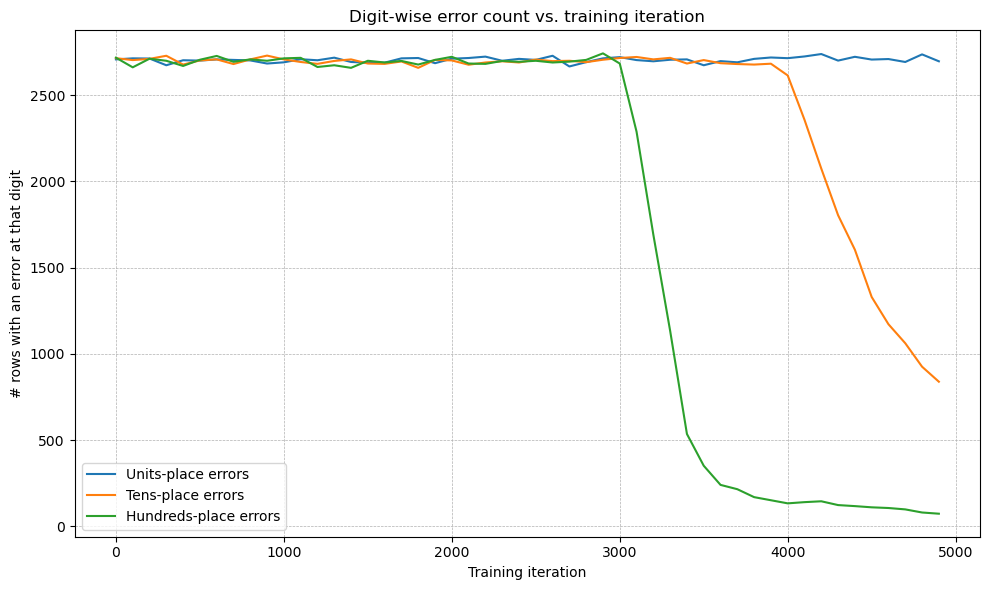

In [12]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_20/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (50, 'pred_iter_50'), (100, 'pred_iter_100'), (150, 'pred_iter_150'), (200, 'pred_iter_200'), (250, 'pred_iter_250'), (300, 'pred_iter_300'), (350, 'pred_iter_350'), (400, 'pred_iter_400'), (450, 'pred_iter_450'), (500, 'pred_iter_500'), (550, 'pred_iter_550'), (600, 'pred_iter_600'), (650, 'pred_iter_650'), (700, 'pred_iter_700'), (750, 'pred_iter_750'), (800, 'pred_iter_800'), (850, 'pred_iter_850'), (900, 'pred_iter_900'), (950, 'pred_iter_950'), (1000, 'pred_iter_1000'), (1050, 'pred_iter_1050'), (1100, 'pred_iter_1100'), (1150, 'pred_iter_1150'), (1200, 'pred_iter_1200'), (1250, 'pred_iter_1250'), (1300, 'pred_iter_1300'), (1350, 'pred_iter_1350'), (1400, 'pred_iter_1400'), (1450, 'pred_iter_1450'), (1500, 'pred_iter_1500')]


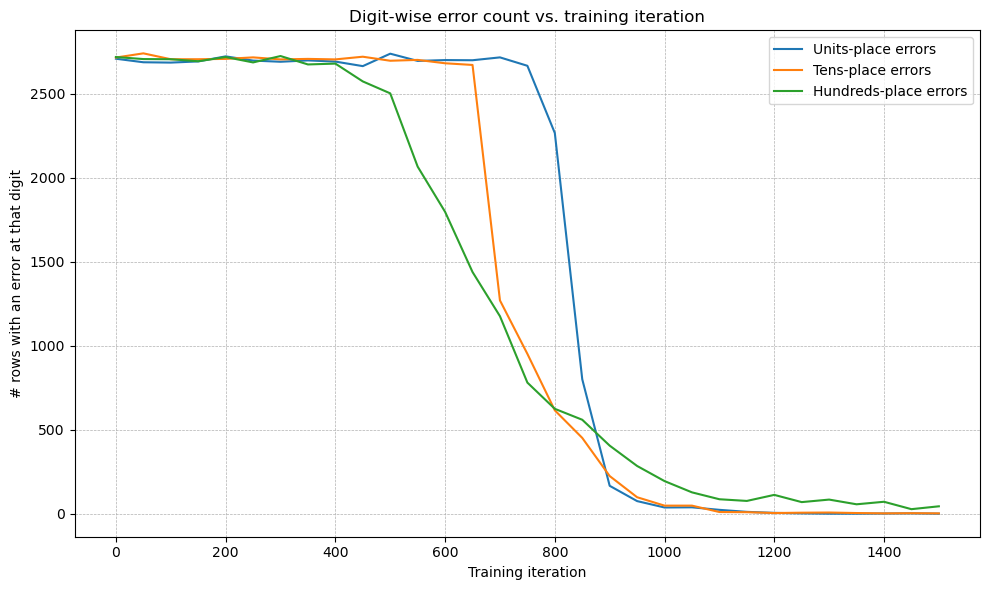

In [10]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_19/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 1500
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(2000, 'pred_iter_2000'), (2050, 'pred_iter_2050'), (2100, 'pred_iter_2100'), (2150, 'pred_iter_2150'), (2200, 'pred_iter_2200'), (2250, 'pred_iter_2250'), (2300, 'pred_iter_2300'), (2350, 'pred_iter_2350'), (2400, 'pred_iter_2400'), (2450, 'pred_iter_2450'), (2500, 'pred_iter_2500'), (2550, 'pred_iter_2550'), (2600, 'pred_iter_2600'), (2650, 'pred_iter_2650'), (2700, 'pred_iter_2700'), (2750, 'pred_iter_2750'), (2800, 'pred_iter_2800'), (2850, 'pred_iter_2850'), (2900, 'pred_iter_2900'), (2950, 'pred_iter_2950'), (3000, 'pred_iter_3000'), (3050, 'pred_iter_3050'), (3100, 'pred_iter_3100'), (3150, 'pred_iter_3150'), (3200, 'pred_iter_3200'), (3250, 'pred_iter_3250'), (3300, 'pred_iter_3300'), (3350, 'pred_iter_3350'), (3400, 'pred_iter_3400'), (3450, 'pred_iter_3450'), (3500, 'pred_iter_3500'), (3550, 'pred_iter_3550'), (3600, 'pred_iter_3600'), (3650, 'pred_iter_3650'), (3700, 'pred_iter_3700'), (3750, 'pred_iter_3750'), (3800, 'pred_iter_3800'), (3850, 'pred_iter_3850'), (3900, 'pre

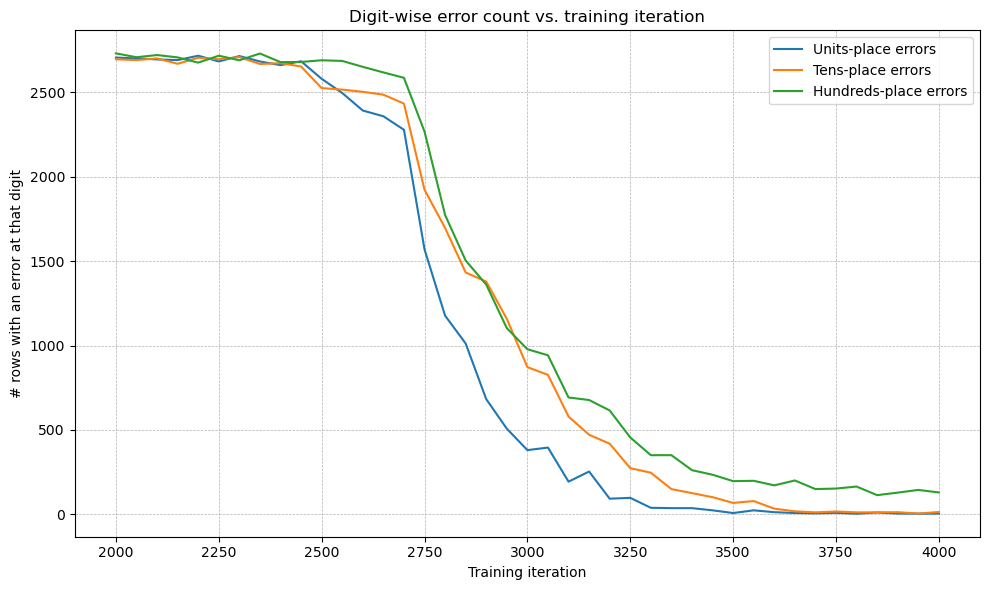

In [14]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_21/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 4000
MIN_STEPS  = 2000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(2000, 'pred_iter_2000'), (2100, 'pred_iter_2100'), (2200, 'pred_iter_2200'), (2300, 'pred_iter_2300'), (2400, 'pred_iter_2400'), (2500, 'pred_iter_2500'), (2600, 'pred_iter_2600'), (2700, 'pred_iter_2700'), (2800, 'pred_iter_2800'), (2900, 'pred_iter_2900'), (3000, 'pred_iter_3000'), (3100, 'pred_iter_3100'), (3200, 'pred_iter_3200'), (3300, 'pred_iter_3300'), (3400, 'pred_iter_3400'), (3500, 'pred_iter_3500'), (3600, 'pred_iter_3600'), (3700, 'pred_iter_3700'), (3800, 'pred_iter_3800'), (3900, 'pred_iter_3900'), (4000, 'pred_iter_4000'), (4100, 'pred_iter_4100'), (4200, 'pred_iter_4200'), (4300, 'pred_iter_4300'), (4400, 'pred_iter_4400'), (4500, 'pred_iter_4500'), (4600, 'pred_iter_4600'), (4700, 'pred_iter_4700'), (4800, 'pred_iter_4800'), (4900, 'pred_iter_4900')]


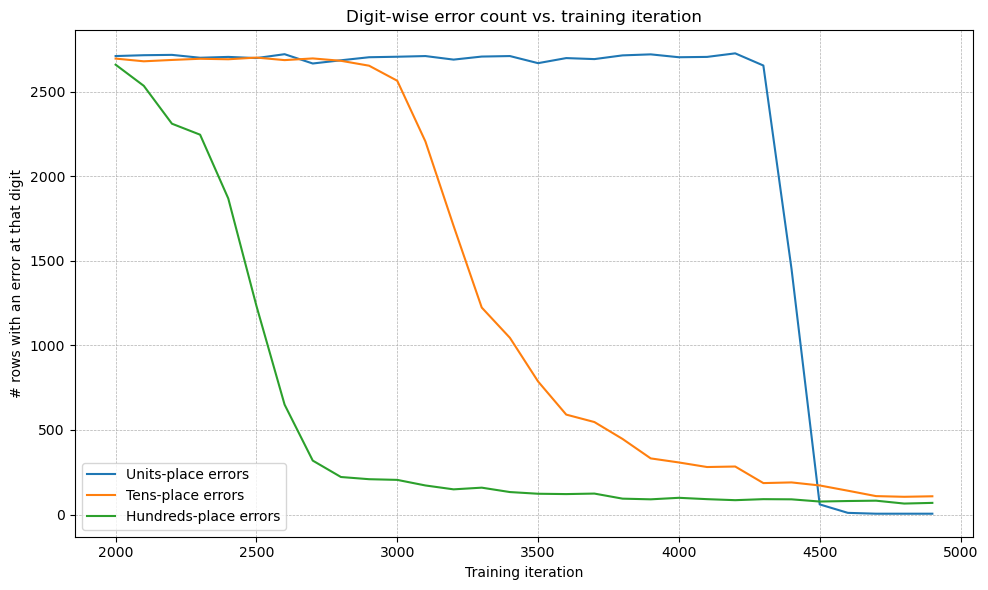

In [15]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_22/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
MIN_STEPS  = 2000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (50, 'pred_iter_50'), (100, 'pred_iter_100'), (150, 'pred_iter_150'), (200, 'pred_iter_200'), (250, 'pred_iter_250'), (300, 'pred_iter_300'), (350, 'pred_iter_350'), (400, 'pred_iter_400'), (450, 'pred_iter_450'), (500, 'pred_iter_500'), (550, 'pred_iter_550'), (600, 'pred_iter_600'), (650, 'pred_iter_650'), (700, 'pred_iter_700'), (750, 'pred_iter_750'), (800, 'pred_iter_800'), (850, 'pred_iter_850'), (900, 'pred_iter_900'), (950, 'pred_iter_950'), (1000, 'pred_iter_1000'), (1050, 'pred_iter_1050'), (1100, 'pred_iter_1100'), (1150, 'pred_iter_1150'), (1200, 'pred_iter_1200'), (1250, 'pred_iter_1250'), (1300, 'pred_iter_1300'), (1350, 'pred_iter_1350'), (1400, 'pred_iter_1400'), (1450, 'pred_iter_1450'), (1500, 'pred_iter_1500'), (1550, 'pred_iter_1550'), (1600, 'pred_iter_1600'), (1650, 'pred_iter_1650'), (1700, 'pred_iter_1700'), (1750, 'pred_iter_1750'), (1800, 'pred_iter_1800'), (1850, 'pred_iter_1850'), (1900, 'pred_iter_1900'), (1950, 'pred_iter_1950'), (2000

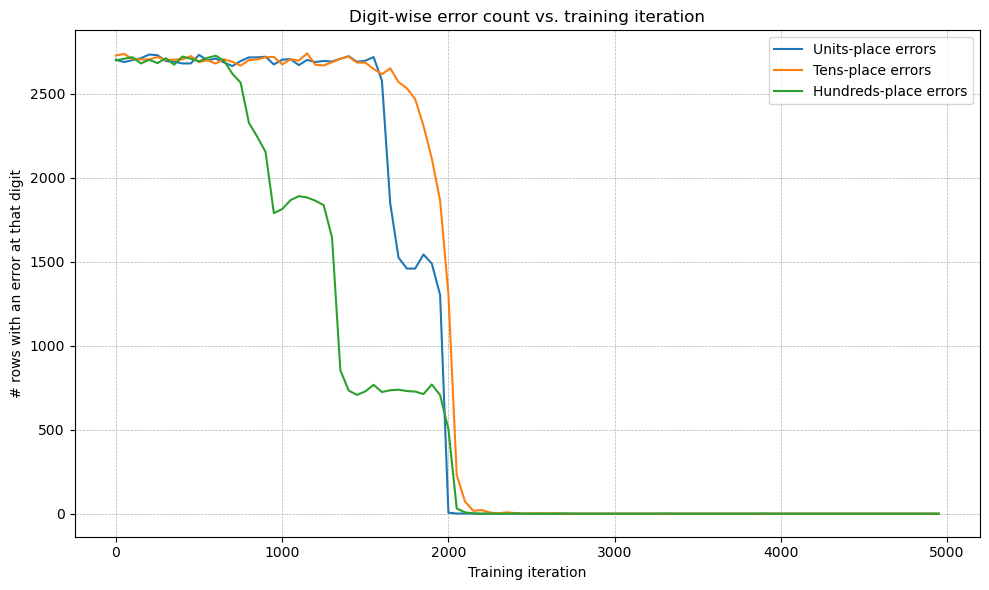

In [9]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/reverse_out/2_operands_0_to_999_output_wo_leading_digit_reverse_6/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [147]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/100M_reverse_out/100M_4_operands_0_to_999_uniform_reverse/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 800000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
#!/usr/bin/env python3
"""
diff_histograms.py

Usage:
    python diff_histograms.py input.csv [output.csv]

Reads a CSV with an 'actual' column and columns named like 'pred_iter_8000',
'pred_iter_9000', ... . For each requested iteration (8000..15000 step 1000),
compute diff = actual - prediction, then count how many rows produce each diff
in the integer range -100..100. The script writes a CSV with rows = differences
(-100..100) and columns = iter_8000, iter_9000, ... containing counts.

This script is robust to messy numeric cells such as "17+62" or " 154.0 ".
It will attempt to safely evaluate simple addition/subtraction expressions.
Invalid or missing numeric fields are treated as NaN and skipped.
"""

import sys
import pandas as pd
import numpy as np
import ast
from typing import Union

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv'
Output_file_path = 'difference_histograms_8000_160000.csv'

# -------------------------
# Safe evaluator for simple arithmetic expressions (only + and - allowed)
# -------------------------
ALLOWED_BINOPS = (ast.Add, ast.Sub)
ALLOWED_UNARYOPS = (ast.UAdd, ast.USub)
ALLOWED_NODES = (ast.Expression, ast.BinOp, ast.UnaryOp, ast.Constant, ast.Num)  # ast.Num for py<3.8

def safe_eval_simple_expr(expr: str) -> Union[int, float, None]:
    """
    Safely evaluate a simple arithmetic expression containing numbers, + and - only.
    Returns numeric value or None if evaluation is not allowed/failed.
    """
    if expr is None:
        return None
    if isinstance(expr, (int, float, np.integer, np.floating)):
        return float(expr)

    s = str(expr).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return None

    try:
        tree = ast.parse(s, mode="eval")
    except Exception:
        return None

    # Validate nodes
    for node in ast.walk(tree):
        if not isinstance(node, ALLOWED_NODES) and not isinstance(node, ast.BinOp) and not isinstance(node, ast.UnaryOp):
            return None
        # If node is BinOp, allow only + and -
        if isinstance(node, ast.BinOp):
            if not isinstance(node.op, ALLOWED_BINOPS):
                return None
        if isinstance(node, ast.UnaryOp):
            if not isinstance(node.op, ALLOWED_UNARYOPS):
                return None

    # Safe evaluate by recursive visitor
    def _eval(node):
        if isinstance(node, ast.Expression):
            return _eval(node.body)
        if isinstance(node, ast.Constant):  # Python 3.8+
            return node.value
        if hasattr(ast, "Num") and isinstance(node, ast.Num):  # older Python
            return node.n
        if isinstance(node, ast.BinOp):
            left = _eval(node.left)
            right = _eval(node.right)
            if left is None or right is None:
                raise ValueError("Invalid operand")
            if isinstance(node.op, ast.Add):
                return left + right
            elif isinstance(node.op, ast.Sub):
                return left - right
            else:
                raise ValueError("Unsupported operator")
        if isinstance(node, ast.UnaryOp):
            operand = _eval(node.operand)
            if isinstance(node.op, ast.UAdd):
                return +operand
            elif isinstance(node.op, ast.USub):
                return -operand
            else:
                raise ValueError("Unsupported unary op")
        raise ValueError("Unsupported AST node")

    try:
        val = _eval(tree)
        # Convert booleans to numbers (False=0 True=1) won't happen likely but be safe:
        if isinstance(val, bool):
            return float(val)
        return float(val)
    except Exception:
        return None

# -------------------------
# Main routine
# -------------------------
def build_histograms(
    infile: str,
    outfile: str = "difference_histograms_8000_160000.csv",
    iter_start: int = 8000,
    iter_end: int = 12000,
    iter_step: int = 2000,
    diff_min: int = -100,
    diff_max: int = 100,
    actual_col_name: str = "actual",
    pred_col_template: str = "pred_iter_{}",
    include_missing_counts: bool = False
):
    df = pd.read_csv(infile, dtype=str)  # read as str to let safe parser handle messy cells

    # normalize column names (strip spaces)
    df.columns = [c.strip() for c in df.columns]

    if actual_col_name not in df.columns:
        raise ValueError(f"Actual column '{actual_col_name}' not found in CSV. Columns: {df.columns.tolist()}")

    iterations = list(range(iter_start, iter_end + 1, iter_step))
    present_iters = []
    for it in iterations:
        cname = pred_col_template.format(it)
        if cname in df.columns:
            present_iters.append((it, cname))
        else:
            # allow alternative naming like pred_iter_8000 without "iter" or variations? For now strictly match.
            # if not found, skip but warn
            print(f"Warning: column '{cname}' not found in CSV; skipping iteration {it}")

    # Prepare index of differences
    diffs = list(range(diff_min, diff_max + 1))
    counts = pd.DataFrame(0, index=diffs, columns=[f"iter_{it}" for (it, _) in present_iters], dtype=int)

    # Optionally keep counters for how many predictions were missing or invalid
    invalid_counts = {f"iter_{it}": 0 for (it, _) in present_iters}
    missing_actual = 0
    total_rows = len(df)

    # Iterate rows
    for idx, row in df.iterrows():
        actual_raw = row[actual_col_name]
        actual_val = safe_eval_simple_expr(actual_raw)
        if actual_val is None:
            missing_actual += 1
            continue
        # use integer diffs (rounded)
        for it, cname in present_iters:
            pred_raw = row[cname]
            pred_val = safe_eval_simple_expr(pred_raw)
            if pred_val is None:
                invalid_counts[f"iter_{it}"] += 1
                continue
            diff = actual_val - pred_val
            # round to nearest integer (you can change this behavior if you prefer floor/trunc)
            diff_int = int(round(diff))
            if diff_int < diff_min or diff_int > diff_max:
                # out of desired range: ignore (if you want, we could collect overflow bins)
                continue
            counts.at[diff_int, f"iter_{it}"] += 1

    # Save output
    counts.index.name = "difference"
    counts.to_csv(outfile)
    print(f"Saved histogram counts to '{outfile}'")
    print(f"Processed {total_rows} rows. Missing actuals: {missing_actual}.")
    print("Invalid/missing predictions per iteration (counts skipped):")
    for k, v in invalid_counts.items():
        print(f"  {k}: {v}")

    # If include_missing_counts True, return an extended DataFrame with two extra rows for out-of-range counts:
    if include_missing_counts:
        # compute out-of-range / missing per iteration
        below = {col: 0 for col in counts.columns}
        above = {col: 0 for col in counts.columns}
        # re-scan to compute these extra bins (cheap for typical CSV sizes)
        for idx, row in df.iterrows():
            actual_val = safe_eval_simple_expr(row[actual_col_name])
            if actual_val is None:
                continue
            for it, cname in present_iters:
                pred_val = safe_eval_simple_expr(row[cname])
                if pred_val is None:
                    continue
                diff_int = int(round(actual_val - pred_val))
                if diff_int < diff_min:
                    below[f"iter_{it}"] += 1
                elif diff_int > diff_max:
                    above[f"iter_{it}"] += 1
        # append these as rows
        counts_extra = counts.copy()
        counts_extra.loc[f"<{diff_min}"] = pd.Series(below)
        counts_extra.loc[f">{diff_max}"] = pd.Series(above)
        counts_extra.to_csv(outfile.replace(".csv", "_with_overflow.csv"))
        print("Also saved counts with overflow bins to:",
              outfile.replace(".csv", "_with_overflow.csv"))
        return counts, counts_extra

    return counts

# -------------------------
# Entry point
# -------------------------
if __name__ == "__main__":

    # call function - by default iter 8000..15000 step 1000, diff range -100..100
    build_histograms(Input_file_path, Output_file_path)


Saved histogram counts to 'difference_histograms_8000_160000.csv'
Processed 10000 rows. Missing actuals: 0.
Invalid/missing predictions per iteration (counts skipped):
  iter_8000: 2
  iter_38000: 0
  iter_68000: 0
  iter_98000: 0
  iter_128000: 0
  iter_158000: 0


In [21]:
#!/usr/bin/env python3
"""
plot_diff_histograms.py

Usage:
    python plot_diff_histograms.py input.csv [output_dir]

Reads a CSV with a 'difference' column and columns like 'iter_8000', 'iter_9000', ...
Draws:
  - a bar chart (PNG) for each iteration column, saved to output_dir/
  - a combined line plot overlaying all iterations, saved as combined.png

Dependencies:
    pip install pandas matplotlib
"""

import sys
import os
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/difference_histograms_8000_160000.csv'
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/plots'

def discover_iter_columns(df: pd.DataFrame, diff_col_name: str = "difference") -> List[str]:
    """Return columns to plot (all columns except the difference column)."""
    return [c for c in df.columns if c != diff_col_name]

def make_output_dir(path: str):
    os.makedirs(path, exist_ok=True)

def plot_single_iteration(diffs: np.ndarray, counts: np.ndarray, iter_name: str, outpath: str):
    """
    Create a single bar chart for one iteration and save to outpath (PNG).
    Uses matplotlib; does not set specific colors so defaults are used.
    """
    plt.figure(figsize=(10, 5))
    # bar plot
    plt.bar(diffs, counts, width=1.0, align="center")
    plt.title(f"Difference distribution — {iter_name}")
    plt.xlabel("difference (actual - predicted)")
    plt.ylabel("count")
    # avoid overcrowding ticks: show every Nth tick
    N = max(1, len(diffs) // 12)
    plt.xticks(diffs[::N], rotation=45)
    plt.grid(axis="y", linestyle=":", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def plot_combined(diffs: np.ndarray, columns: List[str], matrix: np.ndarray, outpath: str):
    """
    Create a combined line plot with one line per iteration (overlay).
    matrix shape: (len(diffs), len(columns))
    """
    plt.figure(figsize=(11, 6))
    for i, col in enumerate(columns):
        plt.plot(diffs, matrix[:, i], marker="o", linewidth=1, label=col)
    plt.title("Difference distributions (combined)")
    plt.xlabel("difference (actual - predicted)")
    plt.ylabel("count")
    # xticks sampling
    N = max(1, len(diffs) // 12)
    plt.xticks(diffs[::N], rotation=45)
    plt.grid(axis="y", linestyle=":", linewidth=0.5, alpha=0.7)
    plt.legend(ncol=2, fontsize="small")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def main(infile: str, outdir: str = "plots"):
    # read CSV
    df = pd.read_csv(infile)
    # normalize column names
    df.columns = [c.strip() for c in df.columns]

    if "difference" not in df.columns:
        raise ValueError("CSV must contain a 'difference' column.")

    # ensure difference column is integer-sorted
    # convert to int (safe)
    df["difference"] = df["difference"].astype(int)
    df = df.sort_values("difference", ascending=True).reset_index(drop=True)

    iter_cols = discover_iter_columns(df, diff_col_name="difference")
    if len(iter_cols) == 0:
        raise ValueError("No iteration columns found (expected columns like 'iter_8000').")

    # convert counts to numeric (fill NaN with 0)
    for c in iter_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    diffs = df["difference"].to_numpy()
    matrix = df[iter_cols].to_numpy()  # shape (n_diff, n_iters)

    # === NEW: exclude the point where difference == 0 from plotting ===
    mask = diffs != 0
    diffs_plot = diffs[mask]
    matrix_plot = matrix[mask, :]

    make_output_dir(outdir)

    # Create a bar chart per iteration (excluding difference == 0)
    for i, col in enumerate(iter_cols):
        outpath = os.path.join(outdir, f"{col}.png")
        counts_plot = matrix_plot[:, i]
        plot_single_iteration(diffs_plot, counts_plot, col, outpath)
        print(f"Saved {outpath}")

    # Combined plot (excluding difference == 0)
    combined_path = os.path.join(outdir, "combined_iterations.png")
    plot_combined(diffs_plot, iter_cols, matrix_plot, combined_path)
    print(f"Saved combined plot to {combined_path}")

if __name__ == "__main__":
    
    main(Input_file_path, Output_file_path)


Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/plots/iter_8000.png
Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/plots/iter_38000.png
Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/plots/iter_68000.png
Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_un

In [27]:
#!/usr/bin/env python3
"""
plot_overall_points.py

Usage:
    python plot_overall_points.py input.csv [output_dir]

Reads a CSV with a 'difference' column and iteration columns (e.g. iter_8000...).
Sums counts across iteration columns and draws a point graph (markers only)
showing the overall distribution (difference -> total count).
Saves summed CSV and PNG to output_dir (default "plots").
"""

import sys
import os
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/difference_histograms_third_phase.csv'
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/plots_third_phase'


def discover_iter_columns(df: pd.DataFrame, diff_col_name: str = "difference") -> List[str]:
    """Return columns to sum (all columns except the difference column)."""
    return [c for c in df.columns if c != diff_col_name]

def make_output_dir(path: str):
    os.makedirs(path, exist_ok=True)

def plot_points(diffs: np.ndarray, totals: np.ndarray, outpath: str, title: str = "Overall distribution (points)"):
    plt.figure(figsize=(10, 5))
    # marker-only plot (no connecting line)
    plt.plot(diffs, totals, marker='o', linestyle='None')
    plt.xlabel("difference (actual - predicted)")
    plt.ylabel("total count (summed across iterations)")
    plt.title(title)
    # sample xticks so they are readable
    N = max(1, len(diffs) // 12)
    plt.xticks(diffs[::N], rotation=45)
    plt.grid(axis='y', linestyle=':', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def main(infile: str, outdir: str = "plots", use_columns: List[str] = None):
    df = pd.read_csv(infile)
    df.columns = [c.strip() for c in df.columns]

    if "difference" not in df.columns:
        raise ValueError("CSV must contain a 'difference' column.")

    df["difference"] = df["difference"].astype(int)
    df = df.sort_values("difference").reset_index(drop=True)

    iter_cols = use_columns if use_columns is not None else discover_iter_columns(df, diff_col_name="difference")
    if len(iter_cols) == 0:
        raise ValueError("No iteration columns found to sum.")

    # Convert to numeric and fill NaN with 0
    for c in iter_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    # Sum across the selected columns (row-wise)
    df["total_count"] = df[iter_cols].sum(axis=1)

    make_output_dir(outdir)
    summed_csv = os.path.join(outdir, "summed_counts.csv")
    df[["difference", "total_count"] + iter_cols].to_csv(summed_csv, index=False)
    print(f"Saved summed counts CSV to: {summed_csv}")

    # Plot point graph
    diffs = df["difference"].to_numpy()
    totals = df["total_count"].to_numpy()
    outpng = os.path.join(outdir, "overall_distribution_points.png")
    plot_points(diffs, totals, outpng)
    print(f"Saved point plot to: {outpng}")

if __name__ == "__main__":
    main(Input_file_path, Output_file_path)


Saved summed counts CSV to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/plots_third_phase/summed_counts.csv
Saved point plot to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/plots_third_phase/overall_distribution_points.png


In [ ]:
#!/usr/bin/env python3
"""
fit_normal_to_counts.py

Usage:
    python fit_normal_to_counts.py input.csv [out_dir]

Expects input.csv to contain columns:
    difference,total_count
where 'difference' are integer bin centers and 'total_count' are counts.

Performs a weighted MLE fit of a normal distribution (weights = counts),
prints mu and sigma, saves a plot (points + fitted curve) and writes parameters
to out_dir/fitted_params.txt.
"""

import sys
import os
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/difference_histograms_zero_phase_single_iter.csv'
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/fit_normal_plots_zero_phase_single_iter'

Second_Column_Name = 'zero_phase'

def weighted_normal_fit(xs: np.ndarray, ws: np.ndarray) -> Tuple[float, float]:
    """
    Weighted MLE for a normal distribution:
      mu = sum(w_i * x_i) / sum(w_i)
      sigma^2 = sum(w_i * (x_i - mu)^2) / sum(w_i)     (MLE, population variance)
    Returns (mu, sigma)
    """
    if len(xs) == 0:
        raise ValueError("Empty data")
    wsum = np.sum(ws)
    if wsum <= 0:
        raise ValueError("Sum of weights must be positive")
    mu = float(np.sum(ws * xs) / wsum)
    var = float(np.sum(ws * (xs - mu) ** 2) / wsum)
    sigma = math.sqrt(max(var, 0.0))
    return mu, sigma

def normal_pdf(x: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    """Return normal PDF values for x (vectorized)."""
    if sigma <= 0:
        # degenerate distribution: return zeros except at mu (approx)
        y = np.zeros_like(x, dtype=float)
        # If x equals mu exactly, put a spike (not normalizable as pdf), but we'll return zeros to avoid NaNs
        # Caller should handle sigma==0 separately.
        return y
    coef = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
    z = (x - mu) / sigma
    return coef * np.exp(-0.5 * z * z)

def plot_fit(diffs: np.ndarray, counts: np.ndarray, mu: float, sigma: float, outpath: str):
    """
    Plot point markers of empirical counts and the fitted normal curve scaled to total counts.
    Saves figure to outpath.
    """
    total = counts.sum()
    x_min, x_max = diffs.min(), diffs.max()
    # high-resolution x for smooth curve
    xs_smooth = np.linspace(x_min - 1, x_max + 1, 500)
    pdf_vals = normal_pdf(xs_smooth, mu, sigma)
    # Scale pdf so the area under pdf over dx=1 equals total counts (counts are per-integer bin)
    scaled_pdf = pdf_vals * total  # bin width assumed 1

    plt.figure(figsize=(10, 5))
    # empirical points
    plt.plot(diffs, counts, marker='o', linestyle='None', label='Empirical error counts')
    # fitted curve
    plt.plot(xs_smooth, scaled_pdf, linestyle='-', linewidth=2, label=f'Normal fit (μ={mu:.3f}, σ={sigma:.3f})')
    plt.xlabel('difference (actual - predicted)')
    plt.ylabel('count')
    plt.title('Empirical error counts and fitted normal distribution')
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.legend()

    # --- Make x-axis symmetric around 0 ---
    # choose integer symmetric limits
    max_abs = max(abs(x_min), abs(x_max))
    if max_abs == 0:
        # degenerate: everything at zero
        x_left, x_right = -1, 1
        ticks = [0]
    else:
        max_abs = int(math.ceil(max_abs))   # round up to integer
        x_left, x_right = -max_abs, max_abs

        # choose number of intervals (about 12 intervals => up to 13 ticks)
        num_intervals = 12
        step = max(1, int(math.ceil((2 * max_abs) / num_intervals)))
        # build integer ticks from -max_abs to +max_abs with chosen step
        ticks = list(range(x_left, x_right + 1, step))
        # ensure the final tick is the positive bound
        if ticks[-1] != x_right:
            ticks.append(x_right)

    plt.xlim(x_left, x_right)
    plt.xticks(ticks, rotation=45)
    # --- end symmetric x-axis code ---

    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()


def main(infile: str, outdir: str = "fit_plots"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.read_csv(infile)
    df.columns = [c.strip() for c in df.columns]

    if 'difference' not in df.columns or Second_Column_Name not in df.columns:
        raise ValueError(f"CSV must contain 'difference' and '{Second_Column_Name}' columns")

    # ensure numeric and sorted
    df['difference'] = pd.to_numeric(df['difference'], errors='coerce')
    df[Second_Column_Name] = pd.to_numeric(df[Second_Column_Name], errors='coerce').fillna(0).astype(float)

    df = df.dropna(subset=['difference']).sort_values('difference').reset_index(drop=True)

    diffs = df['difference'].to_numpy(dtype=float)
    counts = df[Second_Column_Name].to_numpy(dtype=float)

    # Fit
    mu, sigma = weighted_normal_fit(diffs, counts)

    # Save parameters
    params_path = os.path.join(outdir, "fitted_params.txt")
    with open(params_path, "w") as f:
        f.write(f"mu\t{mu}\n")
        f.write(f"sigma\t{sigma}\n")
        f.write(f"total_count\t{int(counts.sum())}\n")
    print(f"Fitted parameters saved to: {params_path}")
    print(f"mu = {mu:.6f}, sigma = {sigma:.6f}")

    # Plot
    outpng = os.path.join(outdir, "fit_plot.png")
    plot_fit(diffs, counts, mu, sigma, outpng)
    print(f"Plot saved to: {outpng}")

    # Optionally: compute and print log-likelihood of the counts under the fitted normal
    # Treat counts as independent Poisson with mean = total * p(x) where p(x) is probability mass approx
    # Here we approximate p(x) = integral_{x-0.5}^{x+0.5} Normal(mu,sigma) dx
    try:
        from math import erf, sqrt
        def normal_cdf(x, m, s):
            return 0.5 * (1 + erf((x - m) / (s * sqrt(2))))
        total = counts.sum()
        expected = []
        for x in diffs:
            # approx probability for integer bin x
            p = normal_cdf(x + 0.5, mu, sigma) - normal_cdf(x - 0.5, mu, sigma)
            expected.append(total * max(p, 1e-15))
        expected = np.array(expected)
        # Poisson log-likelihood
        # ll = sum( count * log(expected) - expected - log(count!) )
        # we omit log(count!) since it's constant wrt parameters
        with np.errstate(divide='ignore'):
            ll = np.sum(counts * np.log(expected) - expected)
        print(f"Approx. (Poisson) log-likelihood (constant offset omitted): {ll:.3f}")
    except Exception:
        pass

if __name__ == "__main__":
    main(Input_file_path, Output_file_path)


Fitted parameters saved to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/fit_normal_plots_zero_phase_single_iter/fitted_params.txt
mu = -46.237164, sigma = 317.098124
Plot saved to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/fit_normal_plots_zero_phase_single_iter/fit_plot.png
Approx. (Poisson) log-likelihood (constant offset omitted): 10389.472


In [161]:
#!/usr/bin/env python3
"""
fit_normal_to_counts.py

Usage:
    python fit_normal_to_counts.py input.csv [out_dir]

Expects input.csv to contain columns:
    difference,total_count
where 'difference' are integer bin centers and 'total_count' are counts.

Performs a weighted MLE fit of a normal distribution (weights = counts),
prints mu and sigma, saves a plot (points + fitted curve) and writes parameters
and goodness-of-fit metrics to out_dir/fitted_params.txt.
"""

import sys
import os
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# --- your default paths (you can override by calling main with args) ---
Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/difference_histograms_first_phase_single_iter_8K.csv'
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/fit_normal_plots_first_phase_single_iter_8K'

Second_Column_Name = 'first_phase'

def weighted_normal_fit(xs: np.ndarray, ws: np.ndarray) -> Tuple[float, float]:
    """
    Weighted MLE for a normal distribution:
      mu = sum(w_i * x_i) / sum(w_i)
      sigma^2 = sum(w_i * (x_i - mu)^2) / sum(w_i)     (MLE, population variance)
    Returns (mu, sigma)
    """
    if len(xs) == 0:
        raise ValueError("Empty data")
    wsum = np.sum(ws)
    if wsum <= 0:
        raise ValueError("Sum of weights must be positive")
    mu = float(np.sum(ws * xs) / wsum)
    var = float(np.sum(ws * (xs - mu) ** 2) / wsum)
    sigma = math.sqrt(max(var, 0.0))
    return mu, sigma

def normal_pdf(x: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    """Return normal PDF values for x (vectorized)."""
    if sigma <= 0:
        y = np.zeros_like(x, dtype=float)
        return y
    coef = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
    z = (x - mu) / sigma
    return coef * np.exp(-0.5 * z * z)

def nice_tick_step(span: float, target_intervals: int = 8) -> int:
    """
    Choose a 'nice' integer tick step (1,2,5,10,20,50,...) for a given span
    and desired number of intervals. Returns an integer step >= 1.
    """
    if span <= 0:
        return 1
    raw = float(span) / float(target_intervals)
    exp = math.floor(math.log10(raw))
    base = 10 ** exp
    for mult in (1, 2, 5, 10):
        step = base * mult
        if step >= raw - 1e-12:
            return int(max(1, round(step)))
    return int(base * 10)


def plot_fit(diffs: np.ndarray, counts: np.ndarray, mu: float, sigma: float, outpath: str):
    """
    Plot point markers of empirical counts and the fitted normal curve scaled to total counts.
    Saves figure to outpath.

    Uses a 'nice' symmetric tick scheme so the x-axis is centered on 0 and ticks are round numbers.
    """
    total = counts.sum()
    x_min, x_max = diffs.min(), diffs.max()
    xs_smooth = np.linspace(x_min - 1, x_max + 1, 500)
    pdf_vals = normal_pdf(xs_smooth, mu, sigma)
    scaled_pdf = pdf_vals * total  # bin width assumed 1

    plt.figure(figsize=(10, 5))
    plt.plot(diffs, counts, marker='o', linestyle='None', label='Empirical error counts')
    plt.plot(xs_smooth, scaled_pdf, linestyle='-', linewidth=2, label=f'Normal fit (μ={mu:.3f}, σ={sigma:.3f})')
    plt.axvline(mu, color='gray', linestyle='--', linewidth=1, label=f'μ = {mu:.3f}')
    plt.xlabel('difference (actual - predicted)')
    plt.ylabel('count')
    plt.title('Empirical error counts and fitted normal distribution')
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.legend()

    # --- Make x-axis symmetric around 0 using "nice" round tick steps ---
    max_abs = max(abs(x_min), abs(x_max))
    if max_abs == 0:
        x_left, x_right = -1, 1
        ticks = [0]
    else:
        # compute a nice integer step
        span = 2 * max_abs
        step = nice_tick_step(span, target_intervals=8)  # change target_intervals if you want more/less ticks
        # round up the bound to a multiple of step so ticks are symmetric and include data bounds
        max_tick = int(math.ceil(max_abs / step) * step)
        x_left, x_right = -max_tick, max_tick
        ticks = list(range(x_left, x_right + 1, step))
        # ensure zero is present
        if 0 not in ticks:
            ticks.append(0)
            ticks = sorted(ticks)

    plt.xlim(x_left - 0.1, x_right + 0.1)
    plt.xticks(ticks, rotation=45)
    # --- end symmetric x-axis code ---

    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def compute_goodness_of_fit(diffs: np.ndarray, counts: np.ndarray, mu: float, sigma: float):
    """
    Compute various goodness-of-fit statistics comparing observed counts to expected counts
    under the fitted normal (using integer bin mass approximated by normal CDF over [x-0.5, x+0.5]).
    Returns a dict of metrics.
    """
    from math import erf, sqrt
    def normal_cdf(x, m, s):
        return 0.5 * (1 + erf((x - m) / (s * sqrt(2))))

    total = counts.sum()
    expected = []
    for x in diffs:
        p = normal_cdf(x + 0.5, mu, sigma) - normal_cdf(x - 0.5, mu, sigma)
        expected.append(total * max(p, 1e-15))
    expected = np.array(expected, dtype=float)

    obs = counts.astype(float)
    # Chi-square (Pearson)
    mask = expected > 0
    if mask.sum() == 0:
        chi2_stat = float('nan')
    else:
        chi2_stat = float(np.sum(((obs[mask] - expected[mask]) ** 2) / expected[mask]))

    # degrees of freedom: number of bins with expected>0 minus number of fitted params (mu,sigma)
    valid_bins = int(mask.sum())
    num_params = 2
    df = max(0, valid_bins - num_params)

    # p-value if scipy available
    p_value = None
    try:
        from scipy.stats import chi2 as scipy_chi2
        if not math.isnan(chi2_stat) and df > 0:
            p_value = 1.0 - scipy_chi2.cdf(chi2_stat, df)
    except Exception:
        p_value = None

    # RMSE, MAE
    rmse = float(np.sqrt(np.mean((obs - expected) ** 2)))
    mae = float(np.mean(np.abs(obs - expected)))

    # Pearson correlation between observed and expected (if not constant)
    try:
        if np.std(obs) > 0 and np.std(expected) > 0:
            r = float(np.corrcoef(obs, expected)[0, 1])
        else:
            r = float('nan')
    except Exception:
        r = float('nan')

    # Poisson log-likelihood (omit log(obs!) constant term)
    with np.errstate(divide='ignore', invalid='ignore'):
        ll = float(np.sum(obs * np.log(expected) - expected))

    # AIC and BIC (note: since log(obs!) terms are omitted, these are AIC/BIC up to an additive constant;
    # still useful for comparison between models fitted on the same data)
    k = num_params
    try:
        aic = float(2 * k - 2 * ll)
        bic = float(k * np.log(max(1, len(obs))) - 2 * ll)
    except Exception:
        aic = float('nan')
        bic = float('nan')

    metrics = {
        "chi2": chi2_stat,
        "chi2_df": df,
        "chi2_pvalue": p_value,
        "rmse": rmse,
        "mae": mae,
        "pearson_r": r,
        "poisson_ll_omit_const": ll,
        "AIC_omit_const": aic,
        "BIC_omit_const": bic,
        "valid_bins": valid_bins,
        "total_count": int(total),
    }
    return metrics, expected

def main(infile: str, outdir: str = "fit_plots"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.read_csv(infile)
    df.columns = [c.strip() for c in df.columns]

    if 'difference' not in df.columns or Second_Column_Name not in df.columns:
        raise ValueError(f"CSV must contain 'difference' and '{Second_Column_Name}' columns")

    # ensure numeric and sorted
    df['difference'] = pd.to_numeric(df['difference'], errors='coerce')
    df[Second_Column_Name] = pd.to_numeric(df[Second_Column_Name], errors='coerce').fillna(0).astype(float)

    df = df.dropna(subset=['difference']).sort_values('difference').reset_index(drop=True)

    diffs = df['difference'].to_numpy(dtype=float)
    counts = df[Second_Column_Name].to_numpy(dtype=float)

    # Fit
    mu, sigma = weighted_normal_fit(diffs, counts)

    # compute goodness-of-fit
    metrics, expected = compute_goodness_of_fit(diffs, counts, mu, sigma)

    # Save parameters + metrics
    params_path = os.path.join(outdir, "fitted_params.txt")
    with open(params_path, "w") as f:
        f.write(f"mu\t{mu}\n")
        f.write(f"sigma\t{sigma}\n")
        f.write(f"total_count\t{metrics['total_count']}\n\n")
        f.write("Goodness_of_fit_metrics:\n")
        f.write(f"chi2\t{metrics['chi2']}\n")
        f.write(f"chi2_df\t{metrics['chi2_df']}\n")
        f.write(f"chi2_pvalue\t{metrics['chi2_pvalue']}\n")
        f.write(f"rmse\t{metrics['rmse']}\n")
        f.write(f"mae\t{metrics['mae']}\n")
        f.write(f"pearson_r\t{metrics['pearson_r']}\n")
        f.write(f"poisson_ll_omit_const\t{metrics['poisson_ll_omit_const']}\n")
        f.write(f"AIC_omit_const\t{metrics['AIC_omit_const']}\n")
        f.write(f"BIC_omit_const\t{metrics['BIC_omit_const']}\n")
        f.write(f"valid_bins\t{metrics['valid_bins']}\n")
    print(f"Fitted parameters and metrics saved to: {params_path}")
    print(f"mu = {mu:.6f}, sigma = {sigma:.6f}")
    print("Goodness-of-fit metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")

    # Plot (plot uses diffs and counts)
    outpng = os.path.join(outdir, "fit_plot.png")
    plot_fit(diffs, counts, mu, sigma, outpng)
    print(f"Plot saved to: {outpng}")

if __name__ == "__main__":
    main(Input_file_path, Output_file_path)


Fitted parameters and metrics saved to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/fit_normal_plots_first_phase_single_iter_8K/fitted_params.txt
mu = 11.987284, sigma = 36.330713
Goodness-of-fit metrics:
  chi2: 330.85384374898604
  chi2_df: 199
  chi2_pvalue: 1.2625073764205297e-08
  rmse: 9.240966120643204
  mae: 6.6815843322299475
  pearson_r: 0.9692121264107901
  poisson_ll_omit_const: 31688.940941129207
  AIC_omit_const: -63373.881882258414
  BIC_omit_const: -63367.2752724423
  valid_bins: 201
  total_count: 9909
Plot saved to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/fit_normal_plots_first_phase_single_iter_8K/fit_plot.png


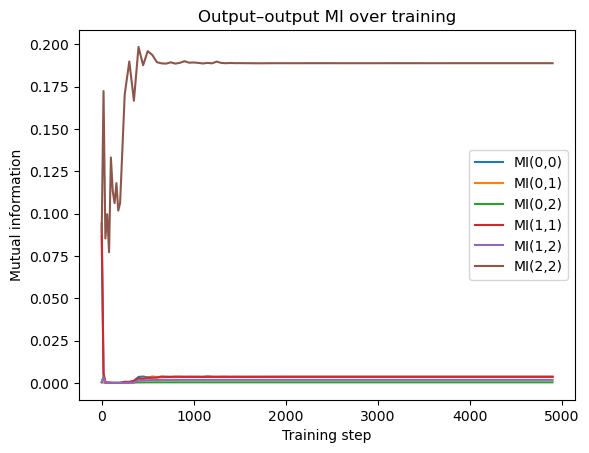

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_uniform_gold_by_reading/reverse_out_with_oo_mi_stats/2_operands_0_to_999_uniform_with_oo_mi_stats_3/output_output_mi.csv')
plt.figure()
for (i,j), grp in df.groupby(['i','j']):
    plt.plot(grp['iter'], grp['mi'], label=f"MI({i},{j})")
plt.xlabel("Training step")
plt.ylabel("Mutual information")
plt.legend()
plt.title("Output–output MI over training")
plt.show()


### Input-Output

Normalized Mutual Information

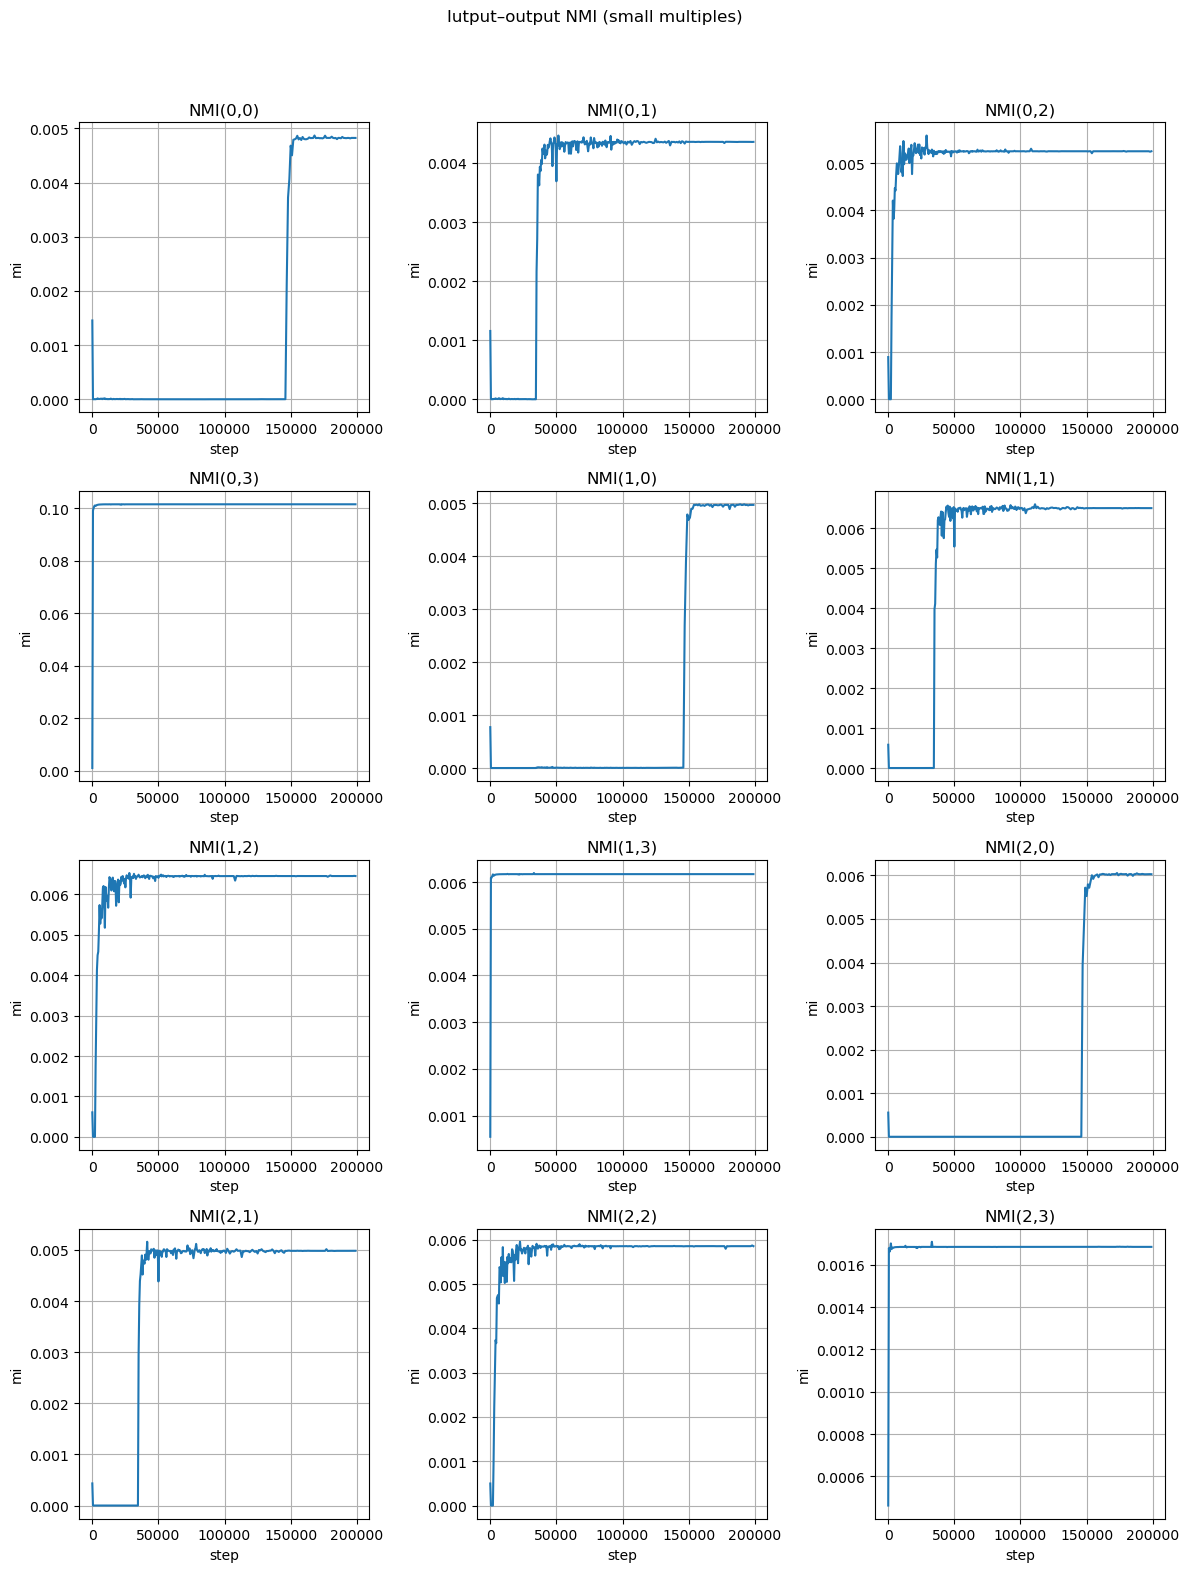

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['nmi'])
    ax.set_title(f"NMI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Iutput–output NMI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


Mutual Information

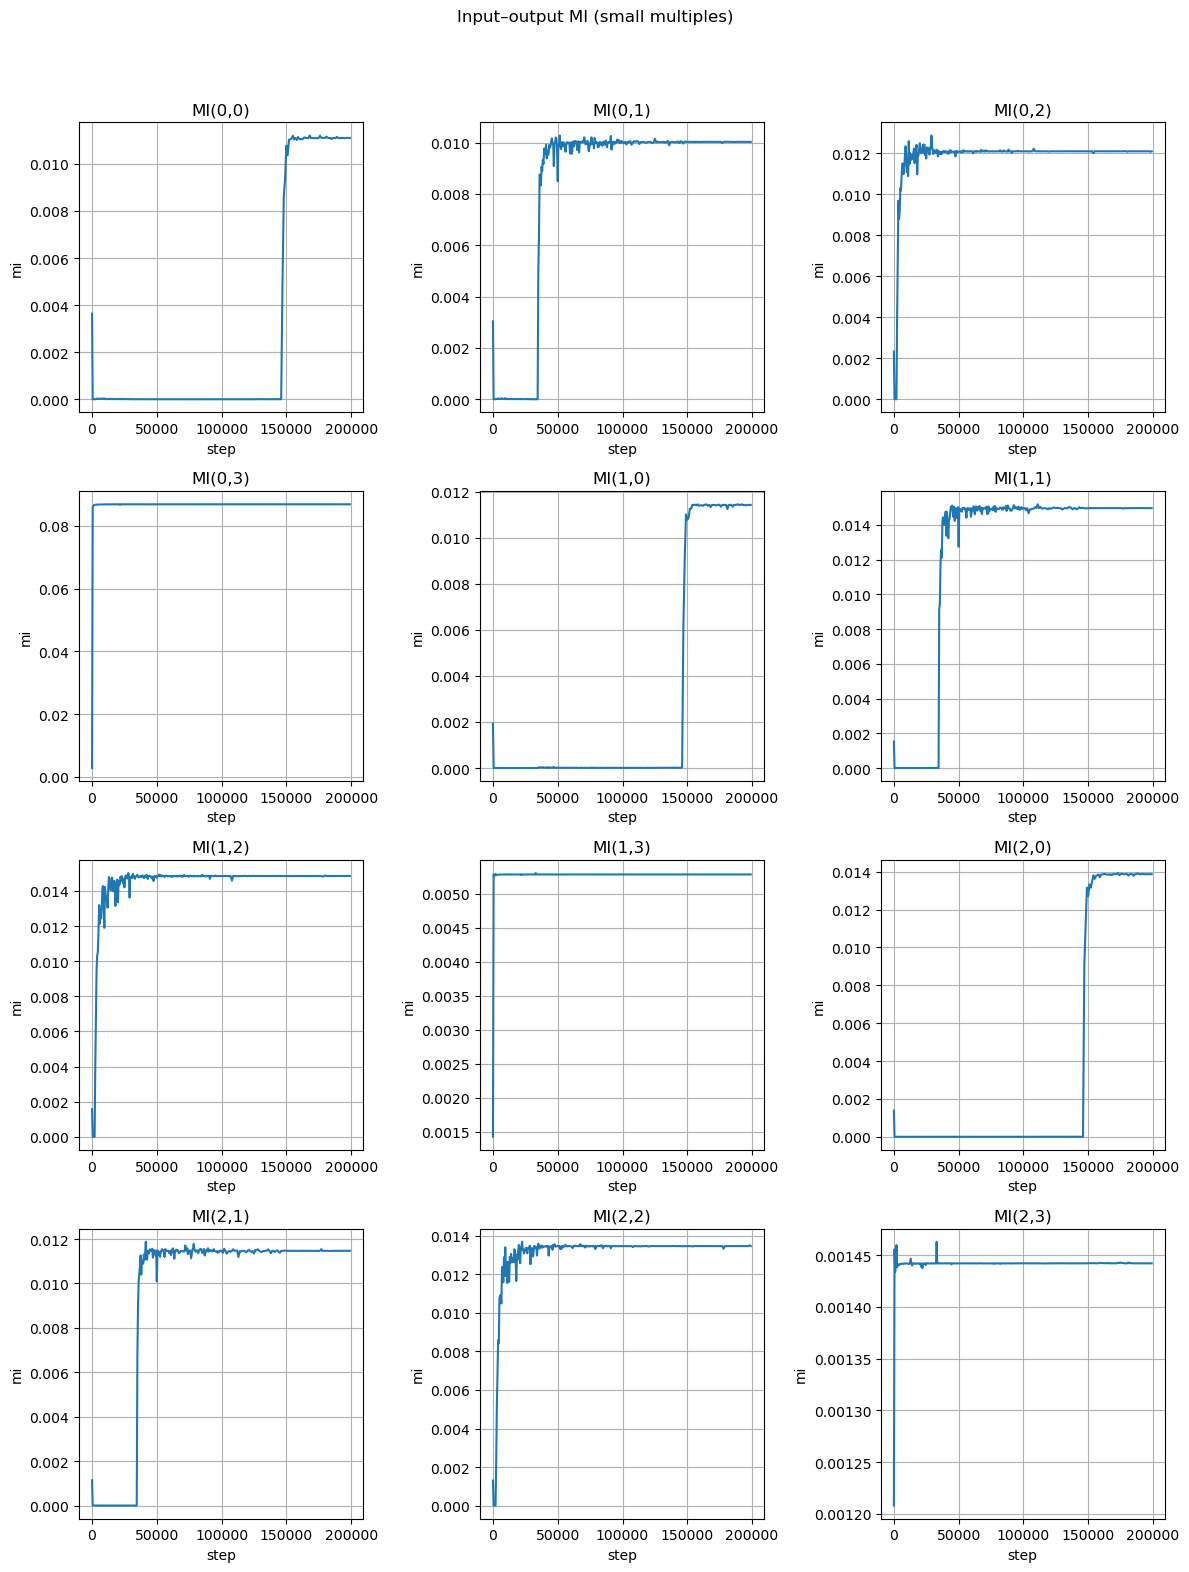

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['mi'])
    ax.set_title(f"MI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Input–output MI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### Output-Output

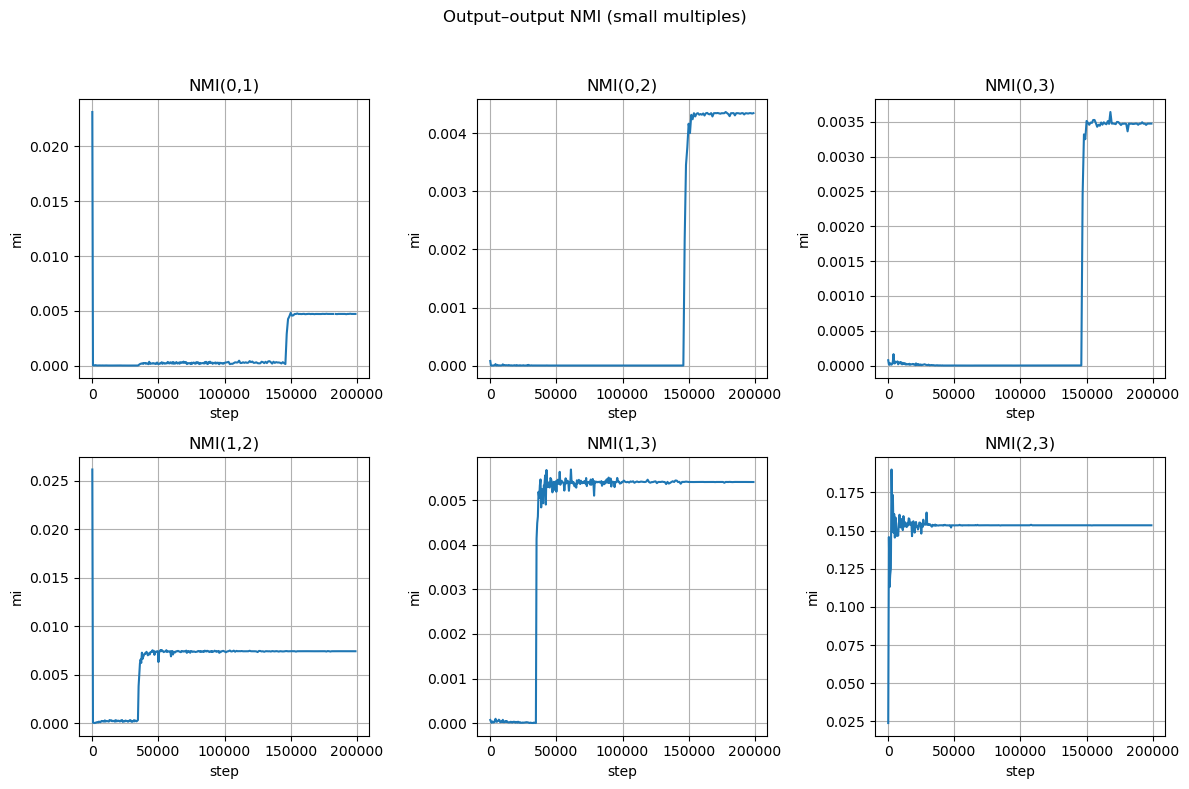

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/output_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['nmi'])
    ax.set_title(f"NMI({i},{j+1})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Output–output NMI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


[(0, 'pred_iter_0'), (500, 'pred_iter_500'), (1000, 'pred_iter_1000'), (1500, 'pred_iter_1500'), (2000, 'pred_iter_2000'), (2500, 'pred_iter_2500'), (3000, 'pred_iter_3000'), (3500, 'pred_iter_3500'), (4000, 'pred_iter_4000'), (4500, 'pred_iter_4500'), (5000, 'pred_iter_5000'), (5500, 'pred_iter_5500'), (6000, 'pred_iter_6000'), (6500, 'pred_iter_6500'), (7000, 'pred_iter_7000'), (7500, 'pred_iter_7500'), (8000, 'pred_iter_8000'), (8500, 'pred_iter_8500')]


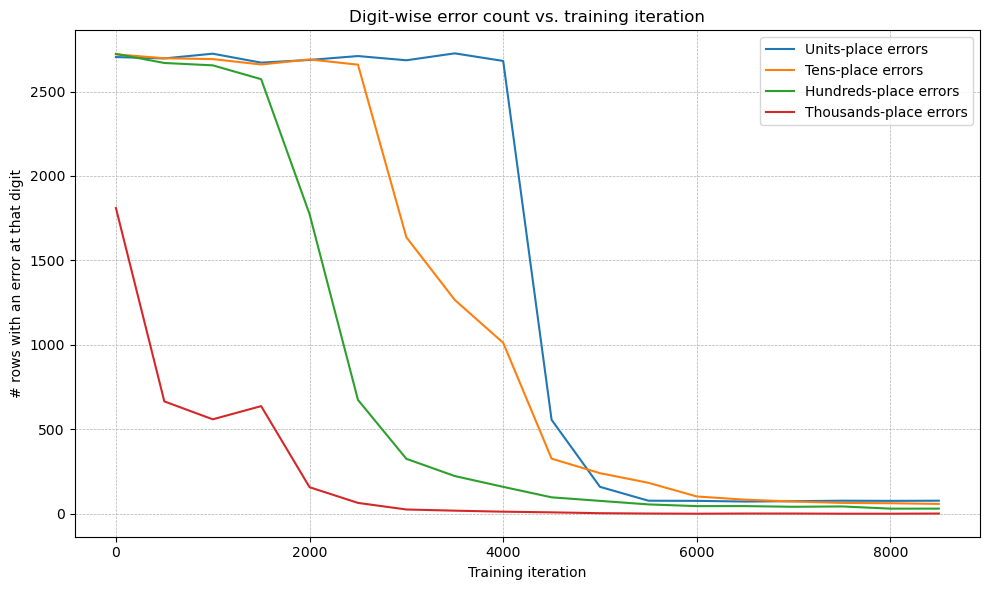

In [2]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/OOD_2_operands_0_to_999_uniform/reverse_out/OOD_2_operand_test_4/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 400000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/3492296703.py:6: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')


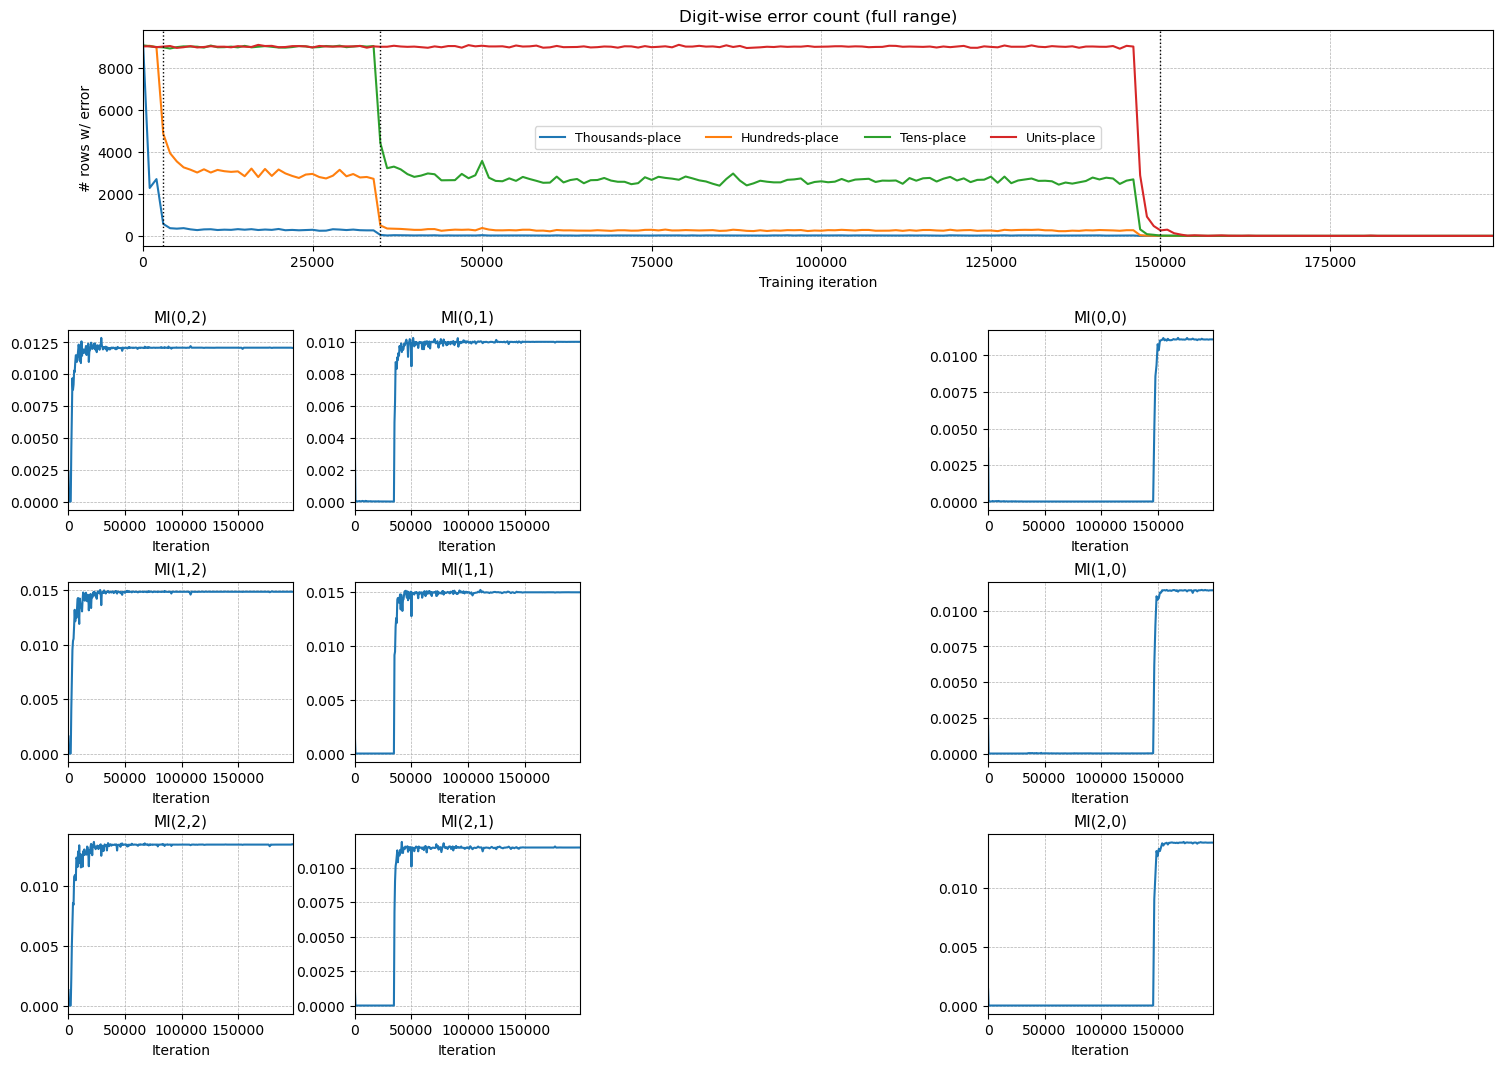

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# ── 1) Load data ──
mi_df  = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')
err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')

# ── 2) Precompute digit‑error counts ──
iterations, units, tens, hundreds, thousands = [], [], [], [], []
for step, colname in pred_cols:
    iterations.append(step)
    stats = digit_error_tally(err_df[ACTUAL_COL], err_df[colname])
    units.append(stats['units'])
    tens.append(stats['tens'])
    hundreds.append(stats['hundreds'])
    thousands.append(stats['thousands'])

# ── 3) Phase centers & max iter ──
phase_centers1 = [3_000, 35_000, 150_000]
Xmax = max(iterations)

# ── 4) Make the figure ──
fig = plt.figure(figsize=(15, 12))

# 4a) Digit‑wise error plot at the very top
err_ax = fig.add_axes([0.05, 0.80, 0.90, 0.18])  # y0=0.80, h=0.18 → covers [0.80–0.98]
err_ax.plot(iterations, thousands, label="Thousands‑place")
err_ax.plot(iterations, hundreds,  label="Hundreds‑place")
err_ax.plot(iterations, tens,      label="Tens‑place")
err_ax.plot(iterations, units,     label="Units‑place")
err_ax.set_xlim(0, Xmax)
err_ax.set_xlabel("Training iteration")
err_ax.set_ylabel("# rows w/ error")
err_ax.set_title("Digit‑wise error count (full range)")
err_ax.legend(ncol=4, fontsize=9)
err_ax.grid(True, linestyle='--', linewidth=0.5)
for c in phase_centers1:
    err_ax.axvline(c, color='k', linestyle=':', linewidth=1)

# ── 5) Square MI panels below ──
W = H = 0.15           # 15% width & height for squares
VSPACE  = 0.06         # larger vertical gap between MI rows
top_pad = 0.58         # start MI grid at y0=0.58 → top row peaks at 0.73

col_to_j = {0:2, 1:1, 2:0}

phase_centers2 = [15_000, 53_000, 137_000]
for col, center in enumerate(phase_centers2):
    j      = col_to_j[col]
    c_frac = center / Xmax
    left   = c_frac - W/2

    for i in [0,1,2]:
        bottom = top_pad - i*(H + VSPACE)
        ax     = fig.add_axes([left, bottom, W, H])
        sub = mi_df[(mi_df.i == i) & (mi_df.j == j)]
        ax.plot(sub['iter'], sub['mi'], lw=1.5)
        ax.set_xlim(0, Xmax)
        ax.set_title(f"MI({i},{j})", fontsize=11)
        ax.set_xlabel("Iteration")
        ax.grid(True, linestyle='--', linewidth=0.5)
        # if col>0:
        #     ax.set_yticklabels([])

plt.show()


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/686454677.py:6: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')


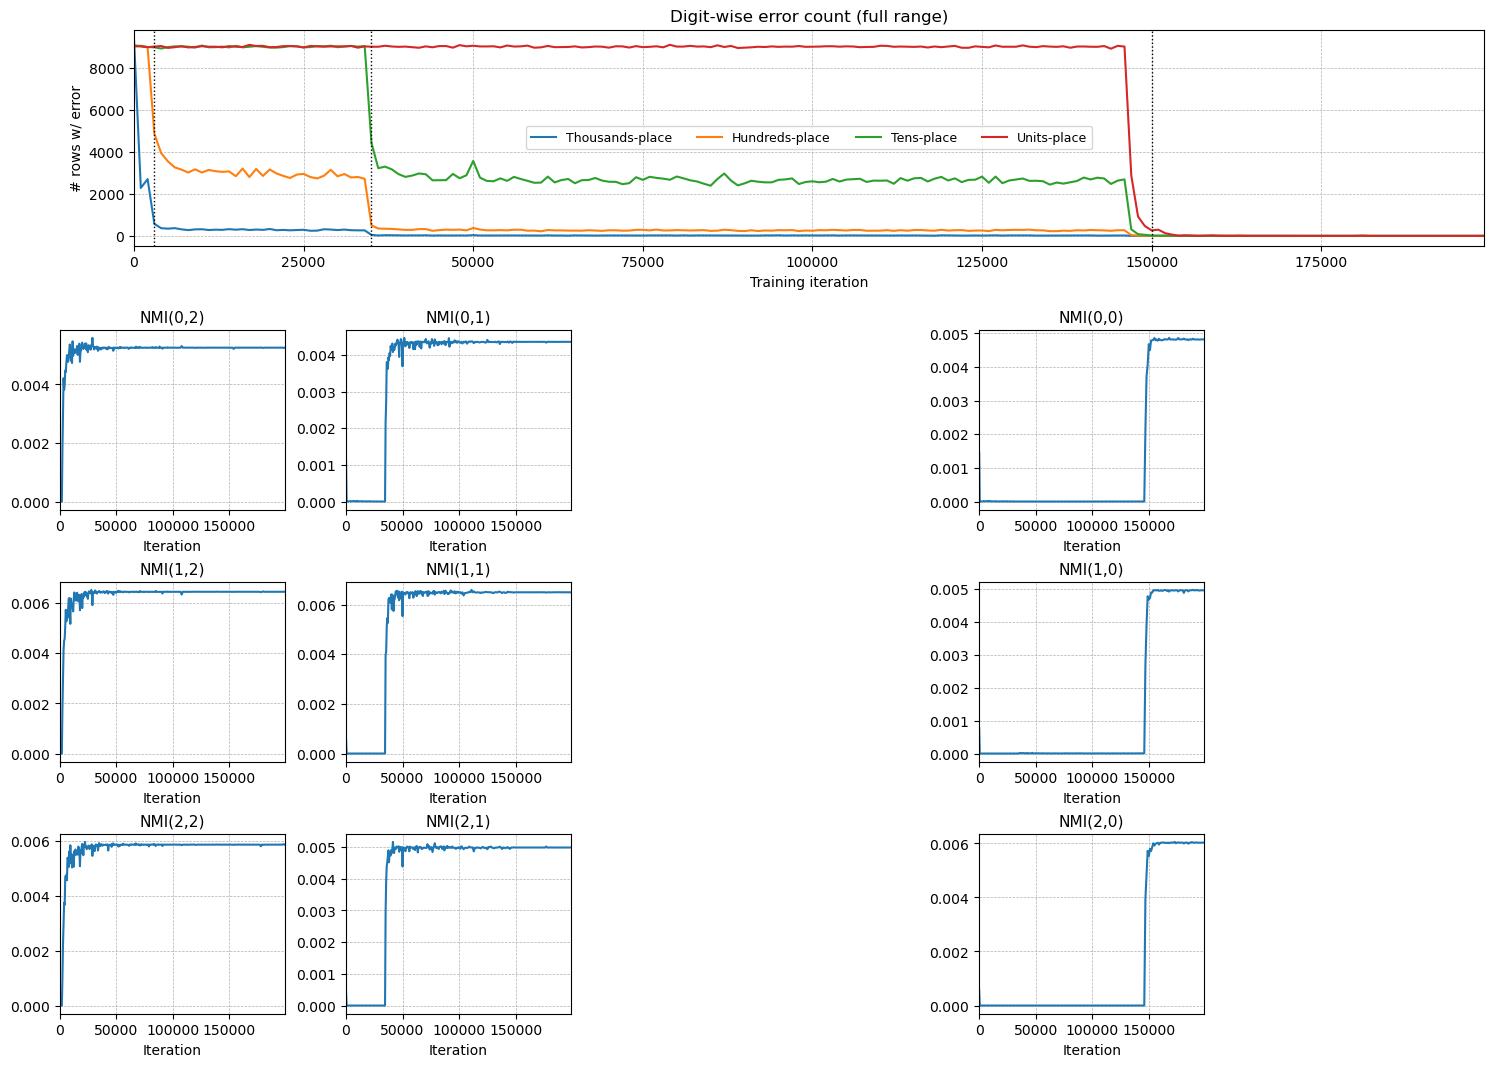

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# ── 1) Load data ──
mi_df  = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')
err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')

# ── 2) Precompute digit‑error counts ──
iterations, units, tens, hundreds, thousands = [], [], [], [], []
for step, colname in pred_cols:
    iterations.append(step)
    stats = digit_error_tally(err_df[ACTUAL_COL], err_df[colname])
    units.append(stats['units'])
    tens.append(stats['tens'])
    hundreds.append(stats['hundreds'])
    thousands.append(stats['thousands'])

# ── 3) Phase centers & max iter ──
phase_centers1 = [3_000, 35_000, 150_000]
Xmax = max(iterations)

# ── 4) Make the figure ──
fig = plt.figure(figsize=(15, 12))

# 4a) Digit‑wise error plot at the very top
err_ax = fig.add_axes([0.05, 0.80, 0.90, 0.18])  # y0=0.80, h=0.18 → covers [0.80–0.98]
err_ax.plot(iterations, thousands, label="Thousands‑place")
err_ax.plot(iterations, hundreds,  label="Hundreds‑place")
err_ax.plot(iterations, tens,      label="Tens‑place")
err_ax.plot(iterations, units,     label="Units‑place")
err_ax.set_xlim(0, Xmax)
err_ax.set_xlabel("Training iteration")
err_ax.set_ylabel("# rows w/ error")
err_ax.set_title("Digit‑wise error count (full range)")
err_ax.legend(ncol=4, fontsize=9)
err_ax.grid(True, linestyle='--', linewidth=0.5)
for c in phase_centers1:
    err_ax.axvline(c, color='k', linestyle=':', linewidth=1)

# ── 5) Square MI panels below ──
W = H = 0.15           # 15% width & height for squares
VSPACE  = 0.06         # larger vertical gap between MI rows
top_pad = 0.58         # start MI grid at y0=0.58 → top row peaks at 0.73

col_to_j = {0:2, 1:1, 2:0}

phase_centers2 = [15_000, 53_000, 137_000]
for col, center in enumerate(phase_centers2):
    j      = col_to_j[col]
    c_frac = center / Xmax
    left   = c_frac - W/2

    for i in [0,1,2]:
        bottom = top_pad - i*(H + VSPACE)
        ax     = fig.add_axes([left, bottom, W, H])
        sub = mi_df[(mi_df.i == i) & (mi_df.j == j)]
        ax.plot(sub['iter'], sub['nmi'], lw=1.5)
        ax.set_xlim(0, Xmax)
        ax.set_title(f"NMI({i},{j})", fontsize=11)
        ax.set_xlabel("Iteration")
        ax.grid(True, linestyle='--', linewidth=0.5)
        # if col>0:
        #     ax.set_yticklabels([])

plt.show()


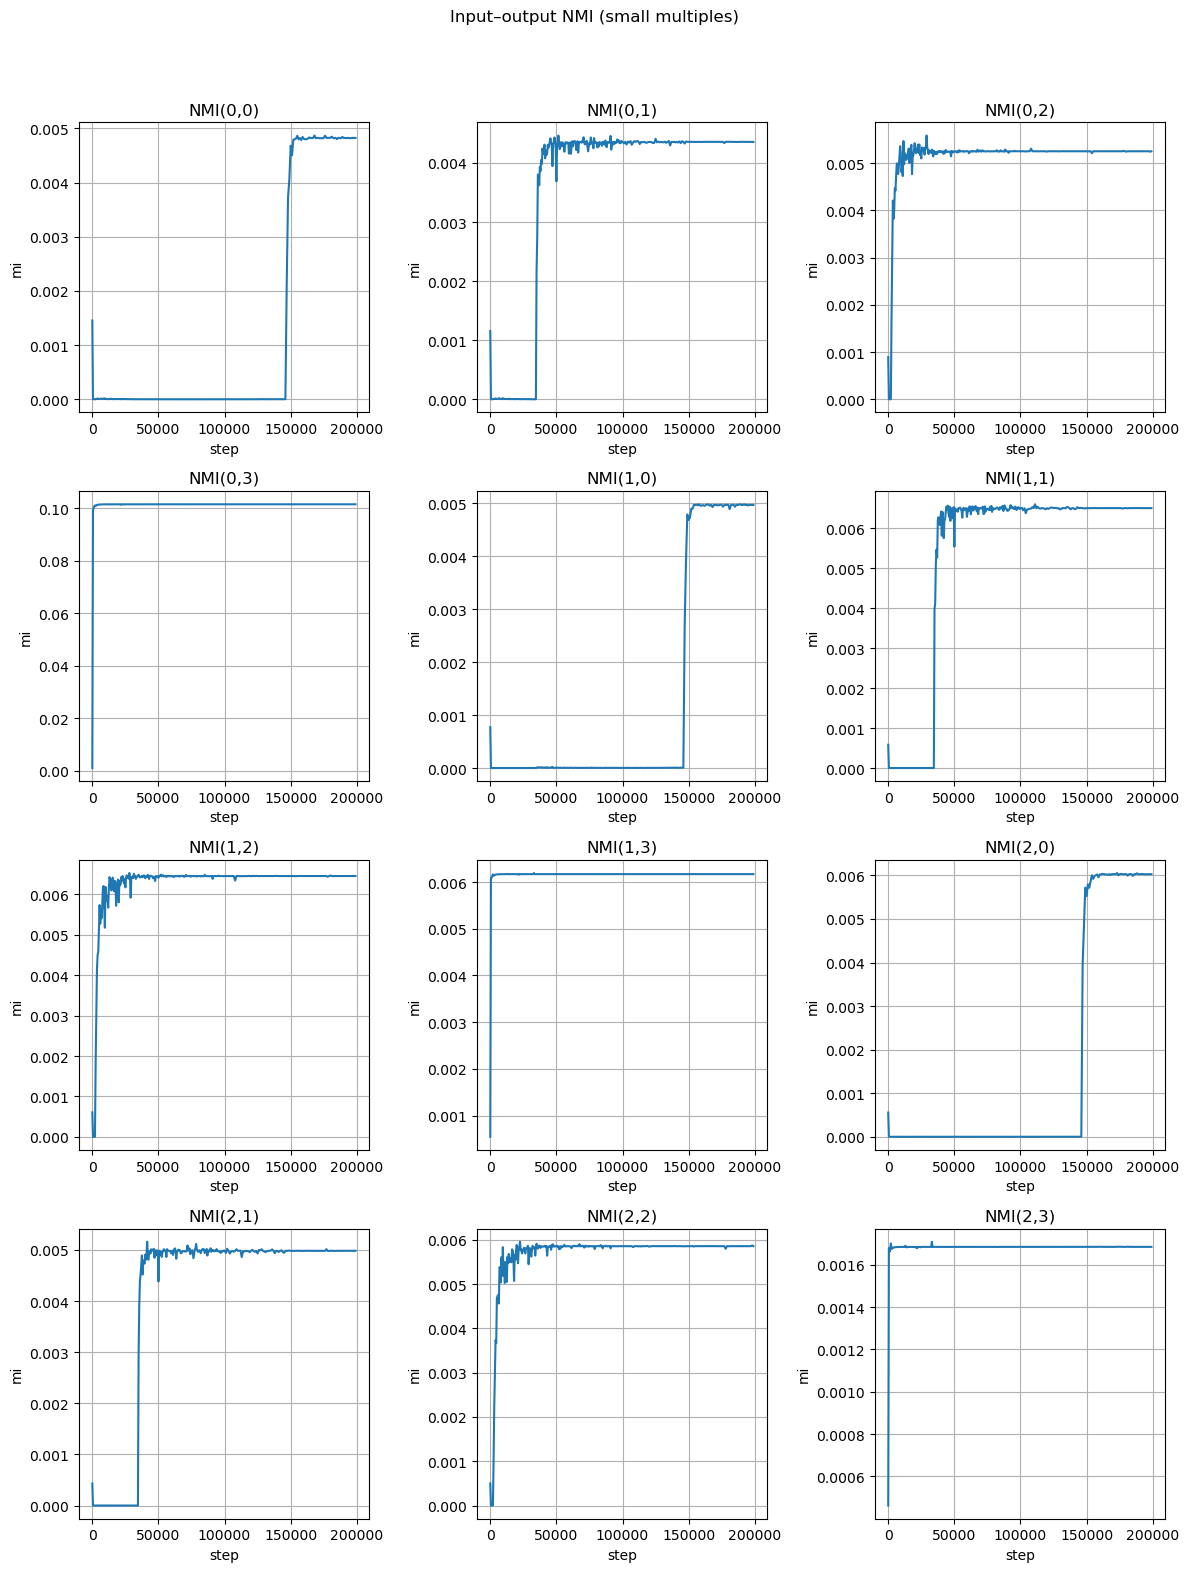

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['nmi'])
    ax.set_title(f"NMI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Input–output NMI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### Output-output

Normalized Mutual Information

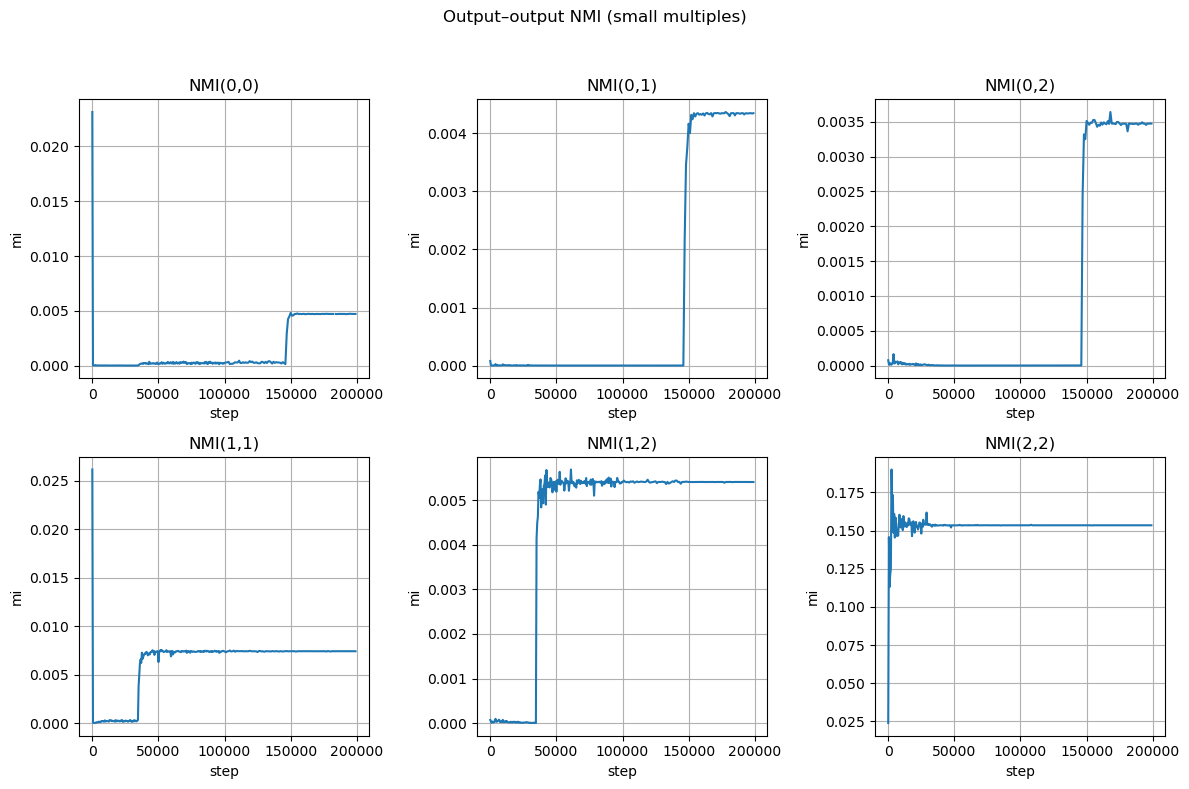

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/output_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['nmi'])
    ax.set_title(f"NMI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Output–output NMI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


Mutual Information

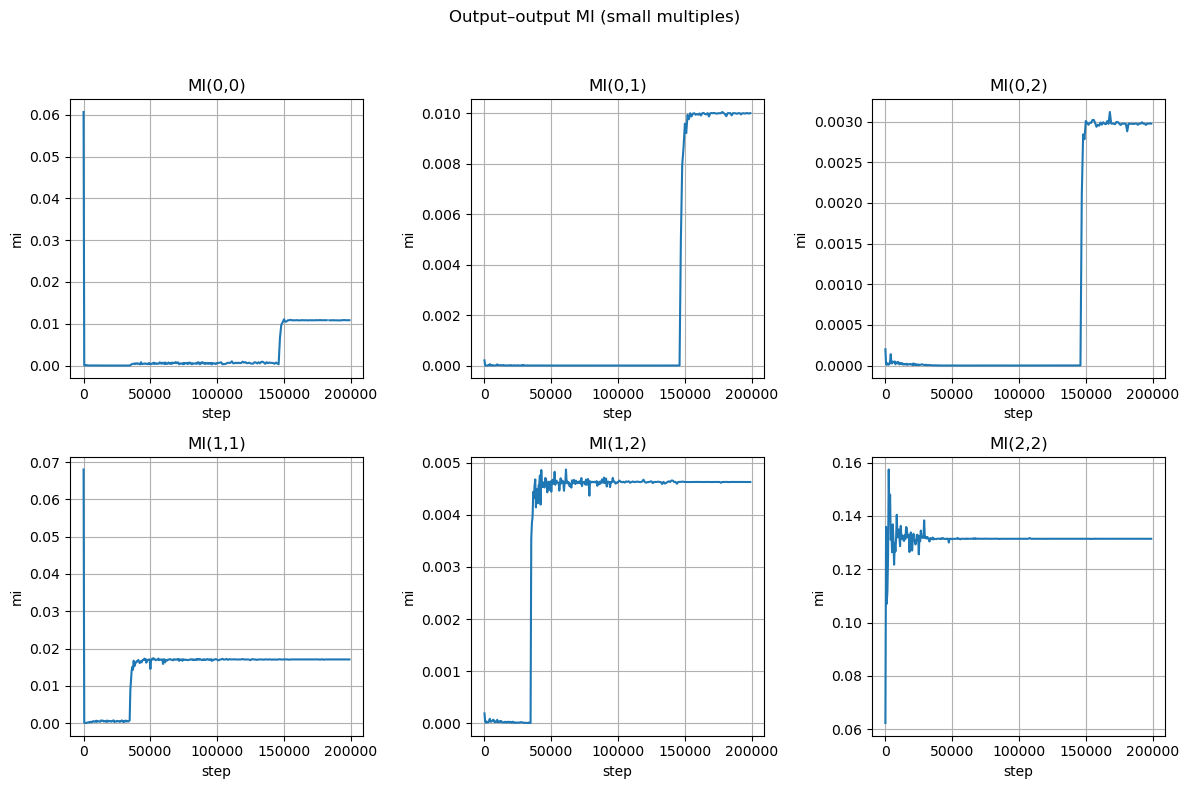

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/output_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['mi'])
    ax.set_title(f"MI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Output–output MI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


[(0, 'pred_iter_0'), (1000, 'pred_iter_1000'), (2000, 'pred_iter_2000'), (3000, 'pred_iter_3000'), (4000, 'pred_iter_4000'), (5000, 'pred_iter_5000'), (6000, 'pred_iter_6000'), (7000, 'pred_iter_7000'), (8000, 'pred_iter_8000'), (9000, 'pred_iter_9000'), (10000, 'pred_iter_10000'), (11000, 'pred_iter_11000'), (12000, 'pred_iter_12000'), (13000, 'pred_iter_13000'), (14000, 'pred_iter_14000'), (15000, 'pred_iter_15000'), (16000, 'pred_iter_16000'), (17000, 'pred_iter_17000'), (18000, 'pred_iter_18000'), (19000, 'pred_iter_19000'), (20000, 'pred_iter_20000'), (21000, 'pred_iter_21000'), (22000, 'pred_iter_22000'), (23000, 'pred_iter_23000'), (24000, 'pred_iter_24000'), (25000, 'pred_iter_25000'), (26000, 'pred_iter_26000'), (27000, 'pred_iter_27000'), (28000, 'pred_iter_28000'), (29000, 'pred_iter_29000'), (30000, 'pred_iter_30000'), (31000, 'pred_iter_31000'), (32000, 'pred_iter_32000'), (33000, 'pred_iter_33000'), (34000, 'pred_iter_34000'), (35000, 'pred_iter_35000'), (36000, 'pred_ite

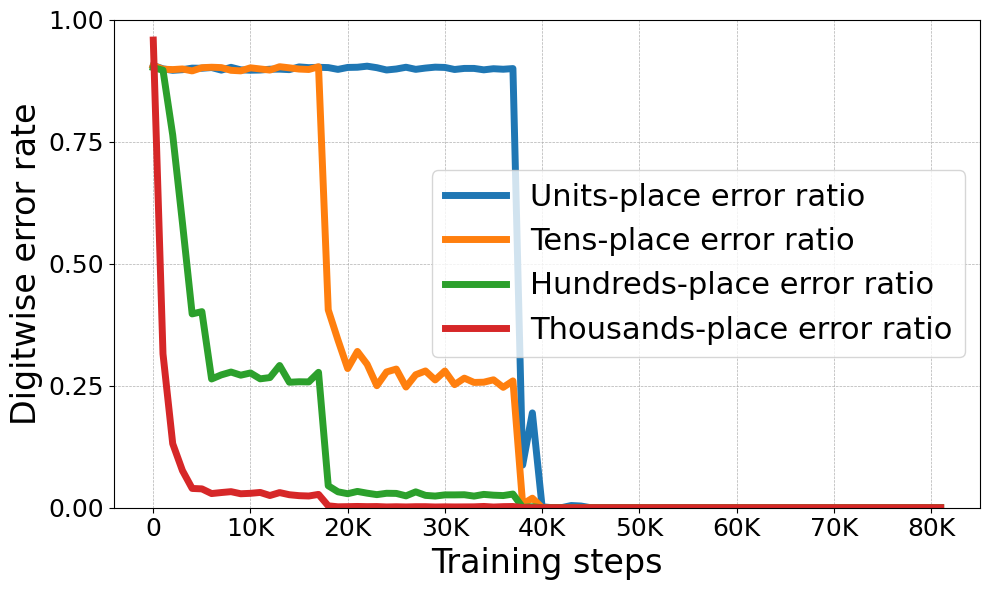

In [ ]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

from matplotlib.ticker import FuncFormatter


mpl.rcParams.update({
    "lines.linewidth": 5,        # default line thickness
    # "axes.titlesize":   20,      # title font size
    "axes.labelsize":  24,      # x/y label font size
    "xtick.labelsize":  18,      # x‑tick label size
    "ytick.labelsize":  18,      # y‑tick label size
    "legend.fontsize":  22,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/slicing_reverse_out/slicing_4_operand_reversed_test_15/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 800000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


n_examples = len(df)  # number of test examples (use df[ACTUAL_COL].notna().sum() if you want to ignore missing actuals)

print(pred_cols)

iterations = []
units = []
tens = []
hundreds = []
thousands = []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    # convert counts -> ratio in [0, 1.0]
    # (guard against division by zero just in case)
    if n_examples > 0:
        units.append(stats["units"] / n_examples)
        tens.append(stats["tens"] / n_examples)
        hundreds.append(stats["hundreds"] / n_examples)
        thousands.append(stats["thousands"] / n_examples)
    else:
        units.append(0.0)
        tens.append(0.0)
        hundreds.append(0.0)
        thousands.append(0.0)


# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place error ratio")
plt.plot(iterations, tens,      label="Tens-place error ratio")
plt.plot(iterations, hundreds,  label="Hundreds-place error ratio")
plt.plot(iterations, thousands, label="Thousands-place error ratio")

plt.xlabel("Training steps")
plt.ylabel("Error rate")
plt.ylim(0.0, 1.0)               # ensure y-axis max is 1.0
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

# --- format x-axis ticks as thousands with "K" suffix (e.g. 20000 -> 20K)
def k_formatter(x, pos):
    # show "0" for zero, otherwise show integer thousands with "K"
    try:
        if int(x) == 0:
            return "0"
    except Exception:
        pass
    return f"{int(x / 1000):d}K"

plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))

plt.tight_layout()
plt.show()

### Save as PDF

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_46622/2866746698.py:37: DtypeWarning: Columns (73,164,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


[(0, 'pred_iter_0'), (2000, 'pred_iter_2000'), (4000, 'pred_iter_4000'), (6000, 'pred_iter_6000'), (8000, 'pred_iter_8000'), (10000, 'pred_iter_10000'), (12000, 'pred_iter_12000'), (14000, 'pred_iter_14000'), (16000, 'pred_iter_16000'), (18000, 'pred_iter_18000'), (20000, 'pred_iter_20000'), (22000, 'pred_iter_22000'), (24000, 'pred_iter_24000'), (26000, 'pred_iter_26000'), (28000, 'pred_iter_28000'), (30000, 'pred_iter_30000'), (32000, 'pred_iter_32000'), (34000, 'pred_iter_34000'), (36000, 'pred_iter_36000'), (38000, 'pred_iter_38000'), (40000, 'pred_iter_40000'), (42000, 'pred_iter_42000'), (44000, 'pred_iter_44000'), (46000, 'pred_iter_46000'), (48000, 'pred_iter_48000'), (50000, 'pred_iter_50000'), (52000, 'pred_iter_52000'), (54000, 'pred_iter_54000'), (56000, 'pred_iter_56000'), (58000, 'pred_iter_58000'), (60000, 'pred_iter_60000'), (62000, 'pred_iter_62000'), (64000, 'pred_iter_64000'), (66000, 'pred_iter_66000'), (68000, 'pred_iter_68000'), (70000, 'pred_iter_70000'), (72000,

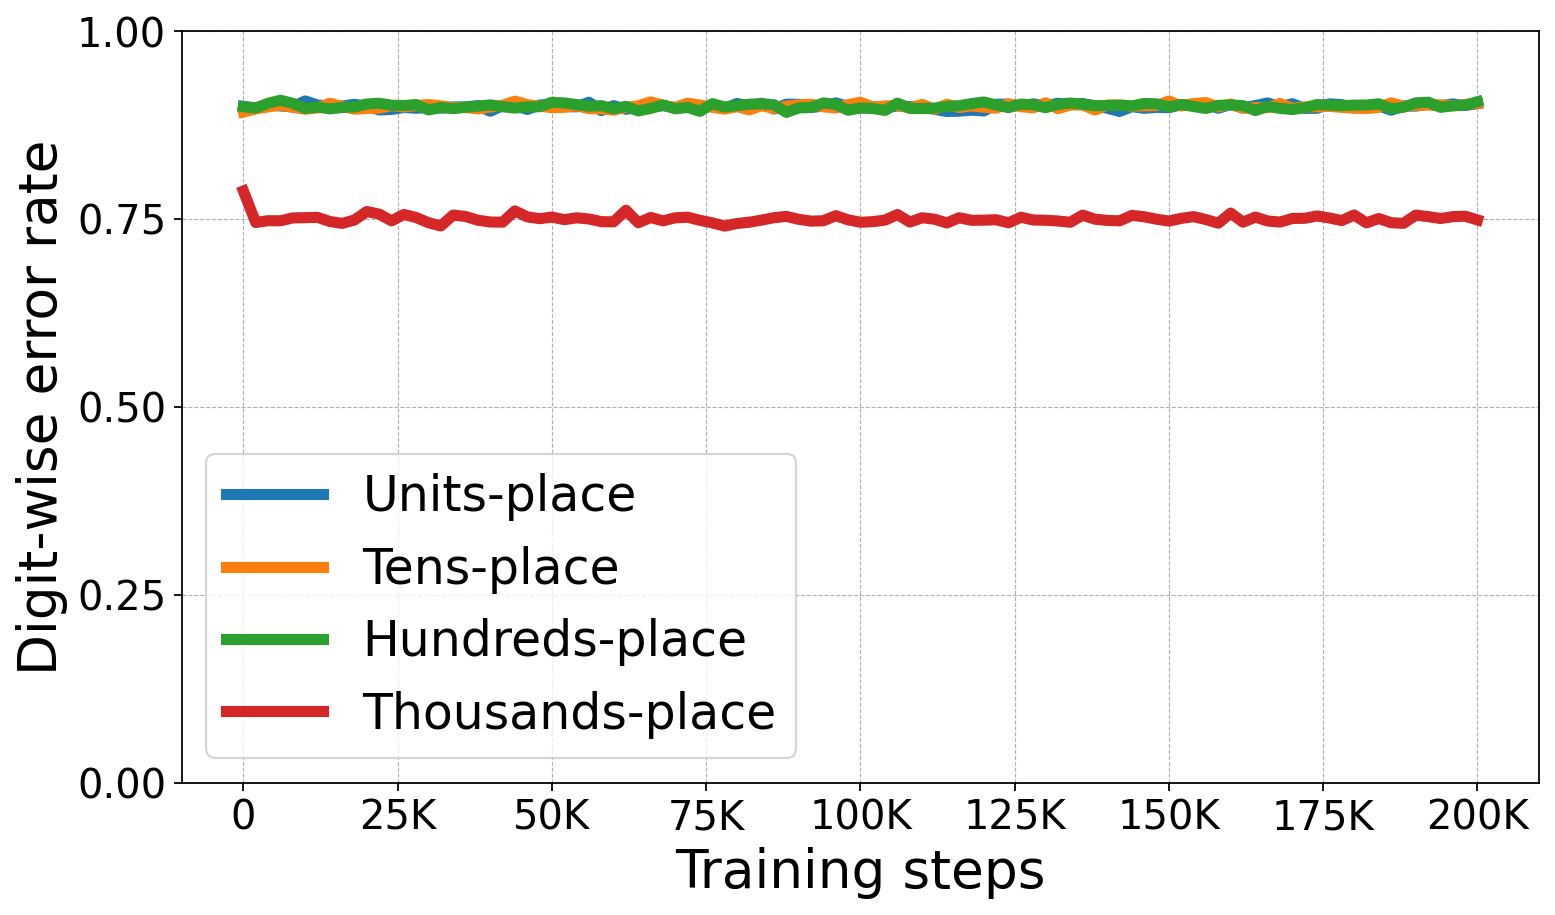

In [232]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

from matplotlib.ticker import FuncFormatter


mpl.rcParams.update({
    "lines.linewidth": 5,        # default line thickness
    # "axes.titlesize":   20,      # title font size
    "axes.labelsize":  24,      # x/y label font size
    "xtick.labelsize":  18,      # x‑tick label size
    "ytick.labelsize":  18,      # y‑tick label size
    "legend.fontsize":  22,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_output_randomize_thousands/reverse/4_operands_0_to_999_uniform_reverse/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 200000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"

# directory containing the input CSV
OUT_DIR = CSV_PATH.parent

# optional: base figure name on CSV file name
OUT_FIG = OUT_DIR / (CSV_PATH.stem + "_error_rates.pdf")
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts

n_examples = len(df)  # number of test examples (use df[ACTUAL_COL].notna().sum() if you want to ignore missing actuals)

print(pred_cols)

iterations = []
units = []
tens = []
hundreds = []
thousands = []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    # convert counts -> ratio in [0, 1.0]
    # (guard against division by zero just in case)
    if n_examples > 0:
        units.append(stats["units"] / n_examples)
        tens.append(stats["tens"] / n_examples)
        hundreds.append(stats["hundreds"] / n_examples)
        thousands.append(stats["thousands"] / n_examples)
    else:
        units.append(0.0)
        tens.append(0.0)
        hundreds.append(0.0)
        thousands.append(0.0)


# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place")
plt.plot(iterations, tens,      label="Tens-place")
plt.plot(iterations, hundreds,  label="Hundreds-place")
plt.plot(iterations, thousands, label="Thousands-place")

plt.xlabel("Training steps")
plt.ylabel("Digit-wise error rate")
plt.ylim(0.0, 1.0)               # ensure y-axis max is 1.0
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

# --- format x-axis ticks as thousands with "K" suffix (e.g. 20000 -> 20K)
def k_formatter(x, pos):
    # show "0" for zero, otherwise show integer thousands with "K"
    try:
        if int(x) == 0:
            return "0"
    except Exception:
        pass
    return f"{int(x / 1000):d}K"

plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))

plt.tight_layout()
fig = plt.gcf()   # get current figure
fig.set_size_inches(10, 6)
fig.tight_layout()
fig.savefig(Path(OUT_FIG), format="pdf", bbox_inches="tight", dpi=300)
plt.show()


## Ablation (Addition)

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_46622/1149492386.py:37: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


[(0, 'pred_iter_0'), (2000, 'pred_iter_2000'), (4000, 'pred_iter_4000'), (6000, 'pred_iter_6000'), (8000, 'pred_iter_8000'), (10000, 'pred_iter_10000'), (12000, 'pred_iter_12000'), (14000, 'pred_iter_14000'), (16000, 'pred_iter_16000'), (18000, 'pred_iter_18000'), (20000, 'pred_iter_20000'), (22000, 'pred_iter_22000'), (24000, 'pred_iter_24000'), (26000, 'pred_iter_26000'), (28000, 'pred_iter_28000'), (30000, 'pred_iter_30000'), (32000, 'pred_iter_32000'), (34000, 'pred_iter_34000'), (36000, 'pred_iter_36000'), (38000, 'pred_iter_38000'), (40000, 'pred_iter_40000'), (42000, 'pred_iter_42000'), (44000, 'pred_iter_44000'), (46000, 'pred_iter_46000'), (48000, 'pred_iter_48000'), (50000, 'pred_iter_50000'), (52000, 'pred_iter_52000'), (54000, 'pred_iter_54000'), (56000, 'pred_iter_56000'), (58000, 'pred_iter_58000'), (60000, 'pred_iter_60000'), (62000, 'pred_iter_62000'), (64000, 'pred_iter_64000'), (66000, 'pred_iter_66000'), (68000, 'pred_iter_68000'), (70000, 'pred_iter_70000'), (72000,

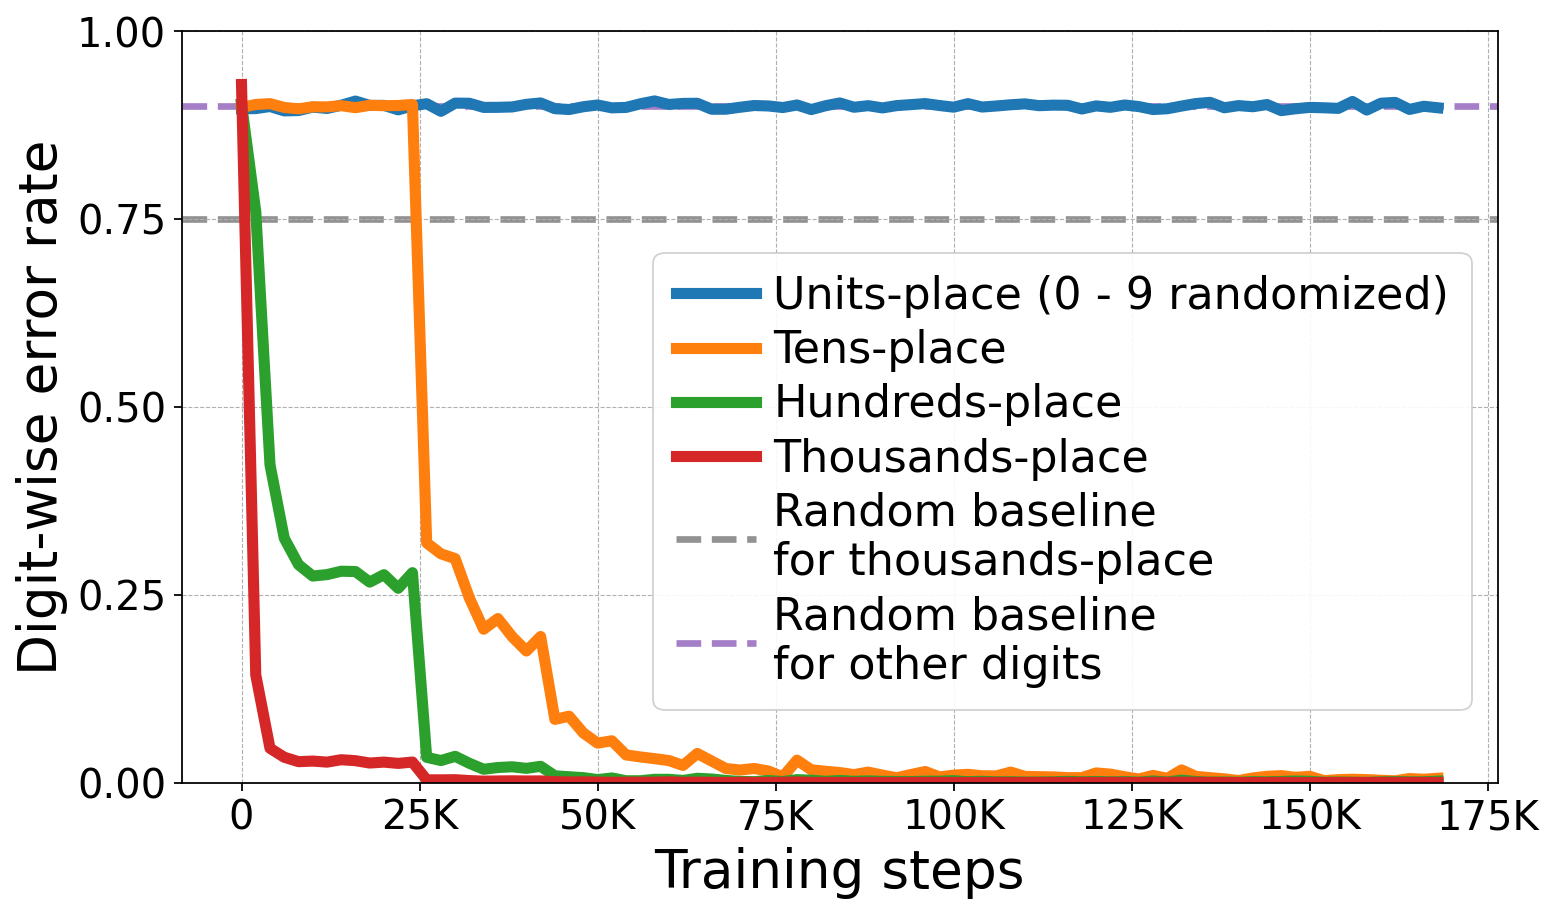

In [260]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

from matplotlib.ticker import FuncFormatter


mpl.rcParams.update({
    "lines.linewidth": 5,        # default line thickness
    # "axes.titlesize":   20,      # title font size
    "axes.labelsize":  24,      # x/y label font size
    "xtick.labelsize":  18,      # x‑tick label size
    "ytick.labelsize":  18,      # y‑tick label size
    "legend.fontsize":  20,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_output_randomize_units/4_operands_0_to_999_uniform_reverse/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 400000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"

# directory containing the input CSV
OUT_DIR = CSV_PATH.parent

# optional: base figure name on CSV file name
OUT_FIG = OUT_DIR / (CSV_PATH.stem + "_error_rates.pdf")
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts

n_examples = len(df)  # number of test examples (use df[ACTUAL_COL].notna().sum() if you want to ignore missing actuals)

print(pred_cols)

iterations = []
units = []
tens = []
hundreds = []
thousands = []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    # convert counts -> ratio in [0, 1.0]
    # (guard against division by zero just in case)
    if n_examples > 0:
        units.append(stats["units"] / n_examples)
        tens.append(stats["tens"] / n_examples)
        hundreds.append(stats["hundreds"] / n_examples)
        thousands.append(stats["thousands"] / n_examples)
    else:
        units.append(0.0)
        tens.append(0.0)
        hundreds.append(0.0)
        thousands.append(0.0)


# # ──────────────────── PLOT ────────────────────
# plt.figure(figsize=(10, 6))
# plt.plot(iterations, units,     label="Units-place")
# plt.plot(iterations, tens,      label="Tens-place")
# plt.plot(iterations, hundreds,  label="Hundreds-place")
# plt.plot(iterations, thousands, label="Thousands-place (0 - 3 randomized)")

# # add dashed horizontal baselines in distinct colors and include them in the legend
# ax = plt.gca()
# # put baselines under the main curves (low zorder), make them a bit thinner and slightly transparent
# ax.axhline(0.75, linestyle="--", linewidth=3, color="tab:gray",
#            alpha=0.85, zorder=0, label="Random baseline for thousands-place")
# ax.axhline(0.9,  linestyle="--", linewidth=3, color="tab:purple",
#            alpha=0.85, zorder=0, label="Random baseline for other digits")

# plt.xlabel("Training steps")
# plt.ylabel("Digit-wise error rate")
# plt.ylim(0.0, 1.0)               # ensure y-axis max is 1.0
# plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
# plt.grid(True, linestyle="--", linewidth=0.5)

# # draw legend after axhline so baselines appear in the legend
# plt.legend()

# # --- format x-axis ticks as thousands with "K" suffix (e.g. 20000 -> 20K)
# def k_formatter(x, pos):
#     # show "0" for zero, otherwise show integer thousands with "K"
#     try:
#         if int(x) == 0:
#             return "0"
#     except Exception:
#         pass
#     return f"{int(x / 1000):d}K"

# plt.gca().xaxis.set_major_formatter(FuncFormatter(k_formatter))

# plt.tight_layout()
# fig = plt.gcf()   # get current figure
# fig.set_size_inches(10, 6)
# fig.tight_layout()
# fig.savefig(Path(OUT_FIG), format="pdf", bbox_inches="tight", dpi=300)
# plt.show()

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place (0 - 9 randomized)")
plt.plot(iterations, tens,      label="Tens-place")
plt.plot(iterations, hundreds,  label="Hundreds-place")
plt.plot(iterations, thousands, label="Thousands-place")

ax = plt.gca()
ax.axhline(0.75, linestyle="--", linewidth=3, color="tab:gray",
           alpha=0.85, zorder=0, label="Random baseline\nfor thousands-place")
ax.axhline(0.9, linestyle="--", linewidth=3, color="tab:purple",
           alpha=0.85, zorder=0, label="Random baseline\nfor other digits")


plt.xlabel("Training steps")
plt.ylabel("Digit-wise error rate")
plt.ylim(0.0, 1.0)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.grid(True, linestyle="--", linewidth=0.5)

# place legend in the top-right white space (axes coordinates)
legend = ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.35, 0.72),   # adjust position as you like
    frameon=True,
    framealpha=0.9,
    edgecolor="0.8",
    fontsize=20,
    # spacing tweaks to make the legend tighter:
    labelspacing=0.25,    # vertical space between entries (default ~0.5)
    handlelength=1.8,     # length of the line/marker in the legend
    handletextpad=0.4,    # space between handle and text (default ~0.8)
    columnspacing=0.8,    # when multiple columns are used
    borderpad=0.25        # padding between legend content and border (default ~0.4)
)

# reduce the rounded-box internal pad even more
legend.get_frame().set_boxstyle("round,pad=0.25")

# optional cosmetic: slightly thinner border
legend.get_frame().set_linewidth(0.8)

# --- format x-axis ticks as thousands with "K" suffix
def k_formatter(x, pos):
    try:
        if int(x) == 0:
            return "0"
    except Exception:
        pass
    return f"{int(x / 1000):d}K"

ax.xaxis.set_major_formatter(FuncFormatter(k_formatter))

plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10, 6)
fig.tight_layout()
fig.savefig(Path(OUT_FIG), format="pdf", bbox_inches="tight", dpi=300)
plt.show()

## Multiplication Colormap

In [126]:
# result_analysis.py
import re
from pathlib import Path
from typing import Dict, Tuple, List, Union, Optional
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --------------------- USER CONFIG (edit in notebook) ------------------------
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/40_digit_times_1_digit/plain_out/40_digit_times_1_digit/test_results.csv')   # <-- set this in your notebook/script
PLOT_INTERVAL = 100          # choose every ~100 steps (script finds the nearest available pred column)
OFFSET     = 0               # first iteration to consider
MAX_STEPS  = 2400            # maximum training step to draw
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
OUT_FIG_SUFFIX = "_error_rates.pdf"
SAVE_COUNTS_CSV = False
LABEL_STEP = 5               # show colorbar labels every LABEL_STEP digits (e.g., 5 -> 1st,6th,11th,...)
# ---------------------------------------------------------------------------

# styling similar to your sample
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors

mpl.rcParams.update({
    "lines.linewidth": 2.5,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 22,
})

PRED_REGEX_DEFAULT = PRED_REGEX

def _ordinal(n: int) -> str:
    """Return the ordinal string for a positive integer (1 -> '1st', 2 -> '2nd', ...)."""
    if n <= 0:
        return f"{n}th"
    if 10 <= (n % 100) <= 20:
        suffix = "th"
    else:
        suffix = {1: "st", 2: "nd", 3: "rd"}.get(n % 10, "th")
    return f"{n}{suffix}"

def _place_names(count: int) -> List[str]:
    """Generate place names '0th', '1st', ... for internal use (0 = units)."""
    return [f"{i}th" for i in range(count)]

def _place_order_key(name: str) -> Tuple[int, str]:
    """Key function to order ordinal place names numerically, fallback to lexical order."""
    match = re.fullmatch(r"(\d+)(st|nd|rd|th)?", name)
    if match:
        return int(match.group(1)), name
    return float("inf"), name

def digit_error_tally(actuals, preds) -> Dict[str, int]:
    """
    Count digit-wise mismatches between two sequences of numbers (or numeric strings).
    Determine maximum width from actuals only (so long/wrong preds won't expand places).
    Returns dict mapping place names ('0th','1st',...) where '0th' = units.
    """
    str_actuals = []
    str_preds = []
    for a, p in zip(actuals, preds):
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append(str(p) if p is not None else "")

    if str_actuals:
        actual_lengths = [len(s) for s in str_actuals if s != ""]
        max_width = max(actual_lengths) if actual_lengths else 1
    else:
        max_width = 1
    max_width = max(1, max_width)

    place_names = _place_names(max_width)  # '0th','1st',...
    counts = {place: 0 for place in place_names}

    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_right = p_str[-max_width:] if len(p_str) >= max_width else p_str
        p_pad = p_right.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                place_idx = max_width - 1 - i  # right-aligned: last char is units (0th)
                counts[place_names[place_idx]] += 1

    return counts

def _select_pred_columns(available_steps: List[int], interval: int, offset: int, max_steps: int) -> List[int]:
    """
    Given a sorted list of available pred steps, choose a subset that approximates every 'interval' steps
    between offset and max_steps by choosing the available column nearest to each target multiple.
    Returns a sorted list of chosen available steps (unique).
    """
    if interval <= 0:
        # if interval not positive, return all steps in range
        return [s for s in available_steps if offset <= s <= max_steps]

    targets = list(range(offset, max_steps + 1, interval))
    chosen = []
    avail = [s for s in available_steps if offset <= s <= max_steps]
    if not avail:
        return []
    used = set()
    for t in targets:
        best = min(avail, key=lambda s: (abs(s - t), s))
        if best not in used:
            chosen.append(best)
            used.add(best)
    chosen_sorted = sorted(chosen)
    return chosen_sorted

def analyze_csv(
    csv_path: Union[str, Path],
    plot_interval: int = PLOT_INTERVAL,
    offset: int = OFFSET,
    max_steps: int = MAX_STEPS,
    actual_col: str = ACTUAL_COL,
    pred_regex: str = PRED_REGEX_DEFAULT,
    save_fig: bool = True,
    fig_path: Optional[Union[str, Path]] = None,
    save_counts_csv: bool = SAVE_COUNTS_CSV,
    label_step: int = LABEL_STEP,
    cmap_name: str = "viridis",
) -> Tuple[pd.DataFrame, Dict[int, Dict[str, int]]]:
    """
    Read csv_path, compute digit-wise error tallies for pred_iter_* columns,
    produce a PDF plot saved next to the CSV, and return the DataFrame and stats.
    Legend is shown as a colorbar with tick labels every `label_step` digits.
    """
    csv_path = Path(csv_path)
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)

    df = pd.read_csv(csv_path)

    if actual_col not in df.columns:
        raise ValueError(f"Actual column '{actual_col}' not found in CSV.")

    # discover pred columns and their steps
    prog = re.compile(pred_regex)
    available = []
    col_by_step = {}
    for col in df.columns:
        m = prog.fullmatch(col)
        if not m:
            continue
        step = int(m.group(1))
        available.append(step)
        col_by_step[step] = col
    available_sorted = sorted(available)

    if not available_sorted:
        raise ValueError("No prediction columns found with the provided regex.")

    # choose which steps to plot (approx every plot_interval steps)
    chosen_steps = _select_pred_columns(available_sorted, plot_interval, offset, max_steps)
    if not chosen_steps:
        raise ValueError("No prediction columns selected after applying interval/offset/max_steps filters.")

    # collect counts
    place_counts_over_iters: Dict[int, Dict[str,int]] = {}
    for step in chosen_steps:
        col = col_by_step[step]
        stats = digit_error_tally(df[actual_col], df[col])
        place_counts_over_iters[step] = stats

    # union of all places
    all_places = set()
    for stats in place_counts_over_iters.values():
        all_places.update(stats.keys())

    ordered_places = sorted(all_places, key=_place_order_key)
    if not ordered_places:
        example_stats = next(iter(place_counts_over_iters.values()))
        ordered_places = list(example_stats.keys())

    # convert to series (counts -> ratios)
    n_examples = int(df[actual_col].notna().sum()) if actual_col in df.columns else len(df)
    iterations = sorted(place_counts_over_iters.keys())
    series_counts = {p: [place_counts_over_iters[it].get(p, 0) for it in iterations] for p in ordered_places}
    series_ratios = {}
    for p in ordered_places:
        if n_examples > 0:
            series_ratios[p] = [c / n_examples for c in series_counts[p]]
        else:
            series_ratios[p] = [0.0 for _ in series_counts[p]]

    # human-friendly labels: '1st digit' corresponds to units (0th)
    human_labels = []
    for p in ordered_places:
        match = re.fullmatch(r"(\d+)(?:st|nd|rd|th)?", p)
        if match:
            idx = int(match.group(1))
            digit_number = idx + 1  # units (0th) -> 1st digit
            human_labels.append(f"{_ordinal(digit_number)} digit")
        else:
            human_labels.append(p)

    # ---------- PLOTTING (color-shaded legend via colorbar) ----------
    fig, ax = plt.subplots(figsize=(10, 6))

    n_places = len(ordered_places)
    cmap = cm.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=0, vmax=max(0, n_places - 1))

    for idx, p in enumerate(ordered_places):
        color = cmap(norm(idx))
        ax.plot(iterations, series_ratios[p], color=color)

    # labels per your request
    ax.set_xlabel("Training steps")
    ax.set_ylabel("Digit-wise error rates")
    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.grid(True, linestyle="--", linewidth=0.5)

    # remove standard legend (we use colorbar instead)
    # ax.legend().set_visible(False)  # no-op if no legend created

    # x-axis: choose up to ~8 nice tick positions and show plain integers with commas
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

    # optional: rotate xtick labels slightly if crowded
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    # --- create colorbar inside plot using explicit axes placement ---
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # get current axes position in figure coords
    pos = ax.get_position()  # Bbox(x0, y0, width, height) in figure coords

    # cax coords: [left, bottom, width, height] in figure coords
    # tweak these numbers (width, left offset, bottom margin) to taste
    cax_width = 0.03
    cax_left = pos.x0 + pos.width - cax_width - 0.05  # slightly inset from right edge of plot
    cax_bottom = pos.y0 + 0.065
    cax_height = pos.height * 0.985

    cax = fig.add_axes([cax_left, cax_bottom, cax_width, cax_height])
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical")

    # compute tick indices: show first, then every label_step, ensure last is shown
    if n_places <= 0:
        tick_inds = []
    else:
        tick_inds = list(range(0, n_places, label_step))
        if (n_places - 1) not in tick_inds:
            tick_inds.append(n_places - 1)
    if tick_inds:
        cbar.set_ticks(tick_inds)
        cbar.set_ticklabels([human_labels[i] for i in tick_inds])
    # (optional) shorten tick label font size so they fit
    cax.tick_params(labelsize=16)

    # # colorbar as legend: ticks every label_step digits (0-based indices)
    # sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    # sm.set_array([])  # required for colorbar in some backends

    # # compute tick indices: show first, then every label_step, ensure last is shown
    # if n_places <= 0:
    #     tick_inds = []
    # else:
    #     tick_inds = list(range(0, n_places, label_step))
    #     if (n_places - 1) not in tick_inds:
    #         tick_inds.append(n_places - 1)

    # cbar = fig.colorbar(sm, ax=ax, pad=0.02, fraction=0.06)
    # if tick_inds:
    #     cbar.set_ticks(tick_inds)
    #     cbar.set_ticklabels([human_labels[i] for i in tick_inds])
    # cbar.set_label("Digit place", rotation=270, labelpad=15)

    plt.tight_layout()

    if save_fig:
        if fig_path is None:
            fig_path = csv_path.with_name(csv_path.stem + OUT_FIG_SUFFIX)
        fig.set_size_inches(10, 6)
        fig.savefig(fig_path, format="pdf", bbox_inches="tight", dpi=300)
        plt.close(fig)
    else:
        plt.show()

    # optionally save counts per iteration
    if save_counts_csv:
        counts_rows = []
        for it in iterations:
            row = {"iter": it}
            for p in ordered_places:
                row[p] = place_counts_over_iters[it].get(p, 0)
            counts_rows.append(row)
        counts_df = pd.DataFrame(counts_rows)
        counts_csv_path = csv_path.with_name(csv_path.stem + "_digit_counts.csv")
        counts_df.to_csv(counts_csv_path, index=False)

    return df, place_counts_over_iters

# if run as script, use top-level settings
if __name__ == "__main__":
    df, stats = analyze_csv(
        CSV_PATH,
        plot_interval=PLOT_INTERVAL,
        offset=OFFSET,
        max_steps=MAX_STEPS,
        actual_col=ACTUAL_COL,
        pred_regex=PRED_REGEX,
        save_fig=True,
        fig_path=None,
        save_counts_csv=SAVE_COUNTS_CSV,
        label_step=LABEL_STEP,
        cmap_name="viridis",
    )
    print("Done. Figure saved next to CSV:", CSV_PATH.with_name(CSV_PATH.stem + OUT_FIG_SUFFIX))


Done. Figure saved next to CSV: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/40_digit_times_1_digit/plain_out/40_digit_times_1_digit/test_results_error_rates.pdf


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_46622/46306080.py:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## MI Plot (MI + Train Loss)

In [188]:
# Paste and run this entire cell in your Jupyter notebook.
# Reduces white space below the x-axis label by adjusting subplot bottom
# and saving with bbox_inches='tight' + small pad_inches.

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import numpy as np

# ---------- User config ----------
CSV_PATH = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/reverse_out_complete_MI/4_operands_0_to_999_uniform_reverse_2/mi_metrics.csv')   # change to your CSV path
OUT1 = CSV_PATH.parent / "mi_conditioned_on_z_plot.pdf"
OUT2 = CSV_PATH.parent / "mi_conditioned_on_carries_plot.pdf"

FIGSIZE = (8, 4)
LINEWIDTH = 2.5
ALPHA_BASE = 0.6
LEGEND_FONTSIZE = 12

EVENT_ITERS = [2000, 48000, 108000]
EVENT_LINE_KW = dict(color="gray", linestyle="--", linewidth=1.2, alpha=0.8, zorder=1)
HGRID_KW = dict(axis='y', linestyle=':', linewidth=0.5, alpha=0.18, color='gray')

LABEL_FONTSIZE = 13
TICK_FONTSIZE = 12
MAX_X_DISPLAY = 200_000

# small amount of padding when saving the figure
SAVE_KW = dict(bbox_inches='tight', pad_inches=0.02)

# ---------------------------------

df = pd.read_csv(CSV_PATH)
x = df["iter"].to_numpy()

def get_series_or_const(df, col):
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in CSV. Available columns: {list(df.columns)}")
    return df[col].to_numpy()

def k_formatter(x_val, pos=None):
    if x_val == 0:
        return "0"
    k = x_val / 1000.0
    if abs(k - round(k)) < 1e-6:
        return f"{int(round(k))}K"
    else:
        return f"{k:.1f}K"

kfmt = FuncFormatter(k_formatter)

colors = plt.get_cmap("tab10").colors
place_to_color = {"Thousands": colors[0], "Hundreds": colors[1], "Tens": colors[2], "Units": colors[3]}

legend_kwargs = dict(
    fontsize=LEGEND_FONTSIZE,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, 0.9),
    frameon=True,
    framealpha=0.92,
    fancybox=True,
    borderaxespad=0.4
)

# ---------------- FIGURE 1 ----------------
pairs_first = [
    {"place": "Thousands", "base_col": "mi/thousands-base",    "model_col": "mi/thousands"},
    {"place": "Hundreds",  "base_col": "mi/hundreds-z-base",  "model_col": "mi/hundreds-z"},
    {"place": "Tens",      "base_col": "mi/tens-z-base",      "model_col": "mi/tens-z"},
    {"place": "Units",     "base_col": "mi/units-z-base",     "model_col": "mi/units-z"},
]

fig, axs = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True, gridspec_kw={"height_ratios":[2.25, 1]})
ax_top, ax_bottom = axs

# event verticals
for it in EVENT_ITERS:
    ax_top.axvline(it, **EVENT_LINE_KW)
    ax_bottom.axvline(it, **EVENT_LINE_KW)

base_handles = []
model_handles = []
base_labels = []
model_labels = []

for p in pairs_first:
    place = p["place"]
    base_col = p["base_col"]
    color = place_to_color[place]
    base_y = get_series_or_const(df, base_col)
    h_base, = ax_top.plot(x, base_y, linestyle="--", linewidth=LINEWIDTH, alpha=ALPHA_BASE, color=color)
    base_handles.append(h_base); base_labels.append(f"{place} place (data)")

for p in pairs_first:
    place = p["place"]
    model_col = p["model_col"]
    color = place_to_color[place]
    y_model = get_series_or_const(df, model_col)
    h_model, = ax_top.plot(x, y_model, linewidth=LINEWIDTH, color=color)
    model_handles.append(h_model); model_labels.append(f"{place} place (model)")

all_handles = base_handles + model_handles
all_labels  = base_labels  + model_labels

ax_top.legend(all_handles, all_labels, **legend_kwargs)

ax_top.set_ylabel("Mutual information", fontsize=LABEL_FONTSIZE)
ax_top.grid(**HGRID_KW)
ax_top.relim(); ax_top.autoscale_view()
ymin, ymax = ax_top.get_ylim()
if ymin < 0: ymin = 0.0
ax_top.set_ylim(ymin, ymax)

# Bottom
ax_bottom.plot(x, get_series_or_const(df, "train_loss"), linewidth=LINEWIDTH)
ax_bottom.set_ylabel("Train loss", fontsize=LABEL_FONTSIZE)
ax_bottom.set_xlabel("Training steps", fontsize=LABEL_FONTSIZE)
ax_bottom.grid(**HGRID_KW)

ax_bottom.set_xlim(0, MAX_X_DISPLAY)

# draw event labels only if inside displayed range
ax_bottom.relim(); ax_bottom.autoscale_view()
bymin, bymax = ax_bottom.get_ylim()
for it in EVENT_ITERS:
    if it <= MAX_X_DISPLAY:
        ax_bottom.text(it, bymin + 0.03*(bymax-bymin),
                       f"{int(it/1000)}K" if it >= 1000 else str(it),
                       rotation=90, va="bottom", ha="center", fontsize=9, alpha=0.65)

ax_bottom.xaxis.set_major_formatter(kfmt)

if bymin < 0: bymin = 0.0
ax_bottom.set_ylim(bymin, bymax)

# tick sizes
ax_top.tick_params(axis="both", which="major", labelsize=TICK_FONTSIZE)
ax_bottom.tick_params(axis="both", which="major", labelsize=TICK_FONTSIZE)

# reduce whitespace below xlabel:
#  - make a slightly smaller bottom margin; tweak value between 0.01 and 0.12 if needed
fig.subplots_adjust(bottom=0.07, top=0.95, hspace=0.12)

# save with tight bbox to remove any remaining extra white margin
fig.savefig(str(OUT1), **SAVE_KW)
plt.close(fig)
print(f"Saved first figure to {OUT1.resolve()}")

# ---------------- FIGURE 2 ----------------
pairs_second = [
    {"place": "Thousands", "base_col": "mi/thousands-base",           "model_col": "mi/thousands"},
    {"place": "Hundreds",  "base_col": "mi/hundreds-carries-base",   "model_col": "mi/hundreds-carries"},
    {"place": "Tens",      "base_col": "mi/tens-carries-base",       "model_col": "mi/tens-carries"},
    {"place": "Units",     "base_col": "mi/units-carries-base",      "model_col": "mi/units-carries"},
]

fig2, axs2 = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True, gridspec_kw={"height_ratios":[2.25, 1]})
ax2_top, ax2_bottom = axs2

for it in EVENT_ITERS:
    ax2_top.axvline(it, **EVENT_LINE_KW)
    ax2_bottom.axvline(it, **EVENT_LINE_KW)

base_handles = []; model_handles = []; base_labels = []; model_labels = []

for p in pairs_second:
    place = p["place"]
    base_col = p["base_col"]
    color = place_to_color[place]
    base_y = get_series_or_const(df, base_col)
    h_base, = ax2_top.plot(x, base_y, linestyle="--", linewidth=LINEWIDTH, alpha=ALPHA_BASE, color=color)
    base_handles.append(h_base); base_labels.append(f"{place} place (data)")

for p in pairs_second:
    place = p["place"]
    model_col = p["model_col"]
    color = place_to_color[place]
    y_model = get_series_or_const(df, model_col)
    h_model, = ax2_top.plot(x, y_model, linewidth=LINEWIDTH, color=color)
    model_handles.append(h_model); model_labels.append(f"{place} place (model)")

all_handles = base_handles + model_handles
all_labels  = base_labels  + model_labels

ax2_top.legend(all_handles, all_labels, **legend_kwargs)

ax2_top.set_ylabel("Mutual information", fontsize=LABEL_FONTSIZE)
ax2_top.grid(**HGRID_KW)
ax2_top.relim(); ax2_top.autoscale_view()
ymin2, ymax2 = ax2_top.get_ylim()
if ymin2 < 0: ymin2 = 0.0
ax2_top.set_ylim(ymin2, ymax2)

ax2_bottom.plot(x, get_series_or_const(df, "train_loss"), linewidth=LINEWIDTH)
ax2_bottom.set_ylabel("Train loss", fontsize=LABEL_FONTSIZE)
ax2_bottom.set_xlabel("Training steps", fontsize=LABEL_FONTSIZE)
ax2_bottom.grid(**HGRID_KW)

ax2_bottom.set_xlim(0, MAX_X_DISPLAY)

ax2_bottom.relim(); ax2_bottom.autoscale_view()
bymin2, bymax2 = ax2_bottom.get_ylim()
for it in EVENT_ITERS:
    if it <= MAX_X_DISPLAY:
        ax2_bottom.text(it, bymin2 + 0.03*(bymax2-bymin2),
                        f"{int(it/1000)}K" if it >= 1000 else str(it),
                        rotation=90, va="bottom", ha="center", fontsize=9, alpha=0.65)

ax2_bottom.xaxis.set_major_formatter(kfmt)
if bymin2 < 0: bymin2 = 0.0
ax2_bottom.set_ylim(bymin2, bymax2)

ax2_top.tick_params(axis="both", which="major", labelsize=TICK_FONTSIZE)
ax2_bottom.tick_params(axis="both", which="major", labelsize=TICK_FONTSIZE)

# reduce whitespace below xlabel for figure 2 as well
fig2.subplots_adjust(bottom=0.07, top=0.95, hspace=0.12)
fig2.savefig(str(OUT2), **SAVE_KW)
plt.close(fig2)
print(f"Saved second figure to {OUT2.resolve()}")


Saved first figure to /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/reverse_out_complete_MI/4_operands_0_to_999_uniform_reverse_2/mi_conditioned_on_z_plot.pdf
Saved second figure to /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/reverse_out_complete_MI/4_operands_0_to_999_uniform_reverse_2/mi_conditioned_on_carries_plot.pdf


## MI (MI + Train Loss + Digitwise Error)

In [187]:
# Combined plotting: produces two figures, each with three stacked subplots:
# Fig 1: (f1_1 top = MI conditioned on z), (f1_2 middle = train loss), (f3 bottom = error rates)
# Fig 2: (f2_1 top = MI conditioned on carries), (f2_2 middle = train loss), (f3 bottom = error rates)

import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ----------------- User config (edit paths if needed) -----------------
MI_CSV = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/reverse_out_complete_MI/4_operands_0_to_999_uniform_reverse_2/mi_metrics.csv')
ERR_CSV = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/reverse_out_complete_MI/4_operands_0_to_999_uniform_reverse_2/test_reverse_results.csv')

OUT1 = MI_CSV.parent / "mi_conditioned_on_z_with_digitwise_error_plot.pdf"       # Figure for pairs_first + f3
OUT2 = MI_CSV.parent / "mi_conditioned_on_carries_with_digitwise_error_plot.pdf"  # Figure for pairs_second + f3

FIGSIZE = (9, 9)
LINEWIDTH = 2.5
ALPHA_BASE = 0.6
LEGEND_FONTSIZE = 15

EVENT_ITERS = [2000, 48000, 108000]
EVENT_LINE_KW = dict(color="gray", linestyle="--", linewidth=1.2, alpha=0.8, zorder=1)
HGRID_KW = dict(axis='y', linestyle=':', linewidth=0.5, alpha=0.18, color='gray')  # horizontal grid style used in f1/f2 earlier

LABEL_FONTSIZE = 20
TICK_FONTSIZE = 16
MAX_X_DISPLAY = 200_000

SAVE_KW = dict(bbox_inches='tight', pad_inches=0.02)

# Parameters for the error-rate (f3) data extraction
STEP_SIZE = 5
OFFSET = 0
MAX_STEPS = 200000
MIN_STEPS = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"

# aesthetic rcParams
mpl.rcParams.update({
    "lines.linewidth": 2.8,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
})

# ----------------- helper functions -----------------
def get_series_or_const(df, col):
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in CSV. Available columns: {list(df.columns)}")
    return df[col].to_numpy()

def k_formatter(x_val, pos=None):
    # show '0' for zero; otherwise show thousands with K (integers if exact)
    try:
        xv = int(x_val)
    except Exception:
        xv = x_val
    if xv == 0:
        return "0"
    k = x_val / 1000.0
    if abs(k - round(k)) < 1e-6:
        return f"{int(round(k))}K"
    else:
        return f"{k:.1f}K"

# ----------------- load data -----------------
df_mi = pd.read_csv(MI_CSV)    # data for f1_1/f1_2 and f2_1/f2_2
x_mi = df_mi["iter"].to_numpy()

df_err = pd.read_csv(ERR_CSV)  # data for f3 (error rates)
# extract prediction columns matching PRED_REGEX and within the step range
pred_cols = []
for col in df_err.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])

# digit error tally (as in your script)
def digit_error_tally(actuals, preds):
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    max_width = max(max((len(s) for s in str_actuals), default=0),
                    max((len(s) for s in str_preds), default=0))
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    max_width = min(max_width, len(base_places))
    place_names = base_places[:max_width]
    counts = {place: 0 for place in place_names}

    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1
    return counts

# compute error-rate lists
iterations_err = []
units = []
tens = []
hundreds = []
thousands = []
n_examples = len(df_err) if ACTUAL_COL not in df_err.columns else df_err[ACTUAL_COL].notna().sum()

for step, col in pred_cols:
    stats = digit_error_tally(df_err[ACTUAL_COL] if ACTUAL_COL in df_err.columns else df_err.iloc[:, 0],
                              df_err[col])
    iterations_err.append(step)
    if n_examples > 0:
        units.append(stats.get("units", 0) / n_examples)
        tens.append(stats.get("tens", 0) / n_examples)
        hundreds.append(stats.get("hundreds", 0) / n_examples)
        thousands.append(stats.get("thousands", 0) / n_examples)
    else:
        units.append(0.0); tens.append(0.0); hundreds.append(0.0); thousands.append(0.0)

# convert to numpy arrays for plotting
iterations_err = np.array(iterations_err)
units = np.array(units)
tens = np.array(tens)
hundreds = np.array(hundreds)
thousands = np.array(thousands)

# color mapping similar to your first program
colors = plt.get_cmap("tab10").colors
place_to_color = {"Thousands": colors[0], "Hundreds": colors[1], "Tens": colors[2], "Units": colors[3]}

# ----------------- define the two MI pairs sets -----------------
pairs_first = [
    {"place": "Thousands", "base_col": "mi/thousands-base",    "model_col": "mi/thousands"},
    {"place": "Hundreds",  "base_col": "mi/hundreds-z-base",  "model_col": "mi/hundreds-z"},
    {"place": "Tens",      "base_col": "mi/tens-z-base",      "model_col": "mi/tens-z"},
    {"place": "Units",     "base_col": "mi/units-z-base",     "model_col": "mi/units-z"},
]

pairs_second = [
    {"place": "Thousands", "base_col": "mi/thousands-base",           "model_col": "mi/thousands"},
    {"place": "Hundreds",  "base_col": "mi/hundreds-carries-base",   "model_col": "mi/hundreds-carries"},
    {"place": "Tens",      "base_col": "mi/tens-carries-base",       "model_col": "mi/tens-carries"},
    {"place": "Units",     "base_col": "mi/units-carries-base",      "model_col": "mi/units-carries"},
]

legend_kwargs = dict(
    fontsize=LEGEND_FONTSIZE,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.51, 0.85),
    frameon=True,
    framealpha=0.92,
    fancybox=True,
    borderaxespad=0.4
)

# ----------------- helper to draw a 3-row figure -----------------
def make_three_row_figure(pairs, out_path, title=None):
    fig, axs = plt.subplots(3, 1, figsize=FIGSIZE, sharex=True,
                            gridspec_kw={"height_ratios":[2.0, 0.9, 1.25]})
    ax_top, ax_mid, ax_bottom = axs

    # event verticals on all subplots
    for it in EVENT_ITERS:
        ax_top.axvline(it, **EVENT_LINE_KW)
        ax_mid.axvline(it, **EVENT_LINE_KW)
        ax_bottom.axvline(it, **EVENT_LINE_KW)

    # top: base (dashed) and model (solid) MI curves (colored by place)
    base_handles = []
    model_handles = []
    base_labels = []
    model_labels = []
    for p in pairs:
        place = p["place"]
        color = place_to_color[place]
        base_col = p["base_col"]
        model_col = p["model_col"]
        base_y = get_series_or_const(df_mi, base_col)
        h_base, = ax_top.plot(x_mi, base_y, linestyle="--", linewidth=LINEWIDTH, alpha=ALPHA_BASE, color=color)
        base_handles.append(h_base); base_labels.append(f"{place} place (data)")
    for p in pairs:
        place = p["place"]
        color = place_to_color[place]
        model_col = p["model_col"]
        y_model = get_series_or_const(df_mi, model_col)
        h_model, = ax_top.plot(x_mi, y_model, linewidth=LINEWIDTH, color=color)
        model_handles.append(h_model); model_labels.append(f"{place} place (model)")

    all_handles = base_handles + model_handles
    all_labels  = base_labels  + model_labels
    ax_top.legend(all_handles, all_labels, **legend_kwargs)

    ax_top.set_ylabel("Mutual information", fontsize=LABEL_FONTSIZE)
    ax_top.grid(**HGRID_KW)
    ax_top.relim(); ax_top.autoscale_view()
    ymin, ymax = ax_top.get_ylim()
    if ymin < 0: ymin = 0.0
    ax_top.set_ylim(ymin, ymax)
    ax_top.tick_params(axis="both", which="major", labelsize=TICK_FONTSIZE)

    # middle: train loss
    ax_mid.plot(x_mi, get_series_or_const(df_mi, "train_loss"), linewidth=LINEWIDTH)
    ax_mid.set_ylabel("Train loss", fontsize=LABEL_FONTSIZE)
    ax_mid.grid(**HGRID_KW)
    ax_mid.tick_params(axis="both", which="major", labelsize=TICK_FONTSIZE)

    # bottom: error rates (f3)
    if len(iterations_err) > 0:
        ax_bottom.plot(iterations_err, units,    label="Units-place",    linewidth=LINEWIDTH, color=place_to_color["Units"])
        ax_bottom.plot(iterations_err, tens,     label="Tens-place",     linewidth=LINEWIDTH, color=place_to_color["Tens"])
        ax_bottom.plot(iterations_err, hundreds, label="Hundreds-place", linewidth=LINEWIDTH, color=place_to_color["Hundreds"])
        ax_bottom.plot(iterations_err, thousands,label="Thousands-place",linewidth=LINEWIDTH, color=place_to_color["Thousands"])
    else:
        ax_bottom.text(0.5, 0.5, "No prediction columns found for error rates", transform=ax_bottom.transAxes,
                       ha="center", va="center")

    ax_bottom.set_ylabel("Digit-wise error rate", fontsize=LABEL_FONTSIZE)
    ax_bottom.set_xlabel("Training steps", fontsize=LABEL_FONTSIZE)
    ax_bottom.set_ylim(0.0, 1.0)
    ax_bottom.set_xlim(0, MAX_X_DISPLAY)
    ax_bottom.grid(**HGRID_KW)   # only horizontal gridlines (no vertical grid)
    ax_bottom.tick_params(axis="both", which="major", labelsize=TICK_FONTSIZE)

    # --- boxed legend INSIDE the bottom subplot (right half)
    # bbox_to_anchor is in axes coordinates because we pass bbox_transform=ax_bottom.transAxes.
    # Increase / decrease the first element to move the box left/right inside the axes.
    ax_bottom.legend(loc='center left',
                     bbox_to_anchor=(0.60, 0.5),
                     bbox_transform=ax_bottom.transAxes,
                     frameon=True,
                     framealpha=0.92,
                     fancybox=True,
                     borderaxespad=0.4,
                     ncol=1,
                     fontsize=LEGEND_FONTSIZE)

    # draw event labels on the bottom only
    bymin, bymax = ax_bottom.get_ylim()
    for it in EVENT_ITERS:
        if it <= MAX_X_DISPLAY:
            ax_bottom.text(it, bymin + 0.03*(bymax-bymin),
                           f"{int(it/1000)}K" if it >= 1000 else str(it),
                           rotation=90, va="bottom", ha="center", fontsize=10, alpha=0.65)

    # x-axis formatter (K)
    kfmt = FuncFormatter(k_formatter)
    ax_bottom.xaxis.set_major_formatter(kfmt)

    # tighten layout & save (no forced right shrink so legend stays inside)
    fig.subplots_adjust(bottom=0.07, top=0.94, hspace=0.12)
    if title:
        fig.suptitle(title, fontsize=14, y=0.98)
    fig.savefig(str(out_path), **SAVE_KW)
    plt.close(fig)
    print(f"Saved figure to {out_path.resolve()}")

# ----------------- produce the two combined figures -----------------
make_three_row_figure(pairs_first,  OUT1)
make_three_row_figure(pairs_second, OUT2)


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_46622/1892417898.py:77: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_err = pd.read_csv(ERR_CSV)  # data for f3 (error rates)


Saved figure to /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/reverse_out_complete_MI/4_operands_0_to_999_uniform_reverse_2/mi_conditioned_on_z_with_digitwise_error_plot.pdf
Saved figure to /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/reverse_out_complete_MI/4_operands_0_to_999_uniform_reverse_2/mi_conditioned_on_carries_with_digitwise_error_plot.pdf


## Normal distribution fitting

Using counts column: 'second_phase'


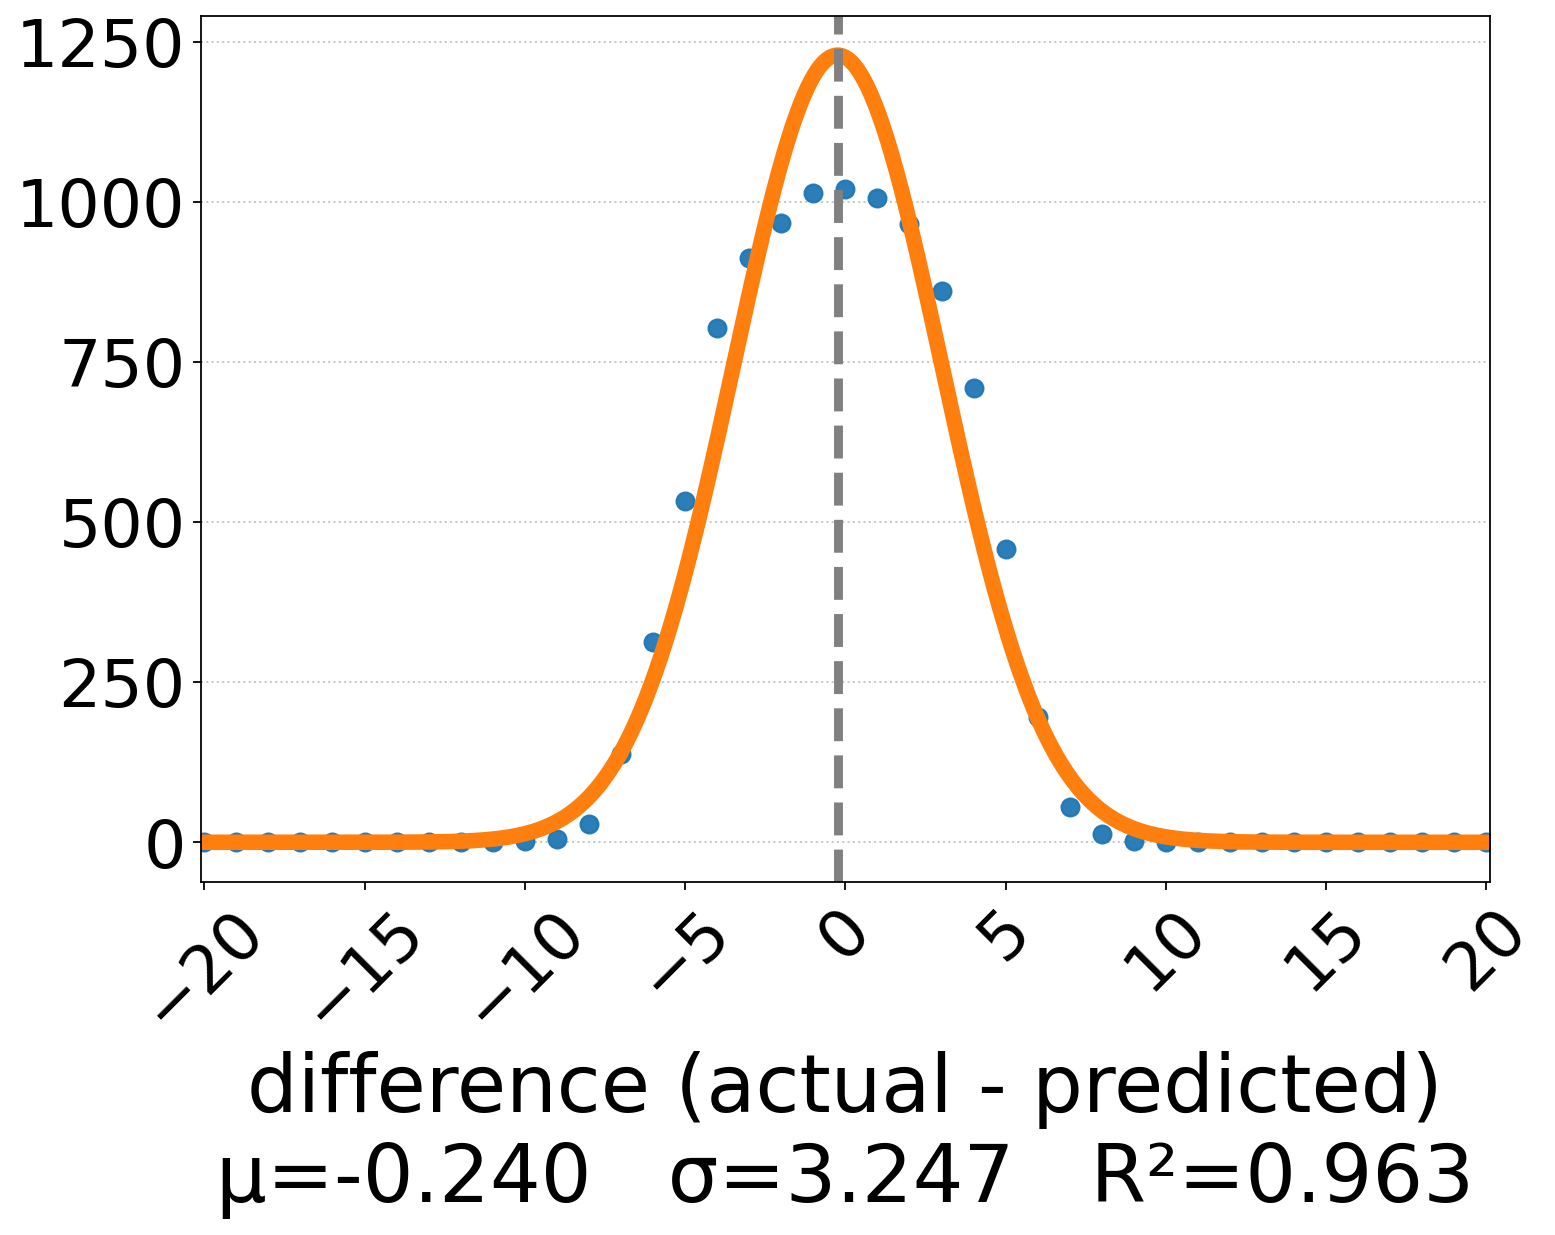

Fitted parameters and metrics saved to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/nice_second_phase_plot/fitted_params.txt

Summary:
  CSV used      : /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/difference_histograms_second_phase.csv
  counts column : second_phase
  mu            : -0.239604
  sigma         : 3.246528
  saved files   : {'png': '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/nice_second_phase_plot/fit_plot.png', 'pdf': '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/nice_second_phase_plot/difference_histograms_second_phase_fit_plot.pdf'}
  params

In [227]:
# %%time
# Ready-to-run notebook cell: set CSV_PATH and OUTDIR below, then run the cell.
# If you prefer to pass a DataFrame instead of a path, see the example at the bottom.

%matplotlib inline

import os
from typing import Optional, Tuple, Dict, Any
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from math import erf, sqrt

# --- plotting style config (tweak these) ---
FIGSIZE = (10, 8)
DPI = 200
AXIS_LABEL_SIZE = 36
TICK_LABEL_SIZE = 30
LEGEND_FONT_SIZE = 34
MARKER_SIZE = 8
MARKER_EDGEWIDTH = 1.0
POINT_ALPHA = 0.95
FIT_LINEWIDTH = 7
MU_LINEWIDTH = 4
GRID_LINEWIDTH = 0.9

def weighted_normal_fit(xs: np.ndarray, ws: np.ndarray) -> Tuple[float, float]:
    if len(xs) == 0:
        raise ValueError("Empty data")
    wsum = np.sum(ws)
    if wsum <= 0:
        raise ValueError("Sum of weights must be positive")
    mu = float(np.sum(ws * xs) / wsum)
    var = float(np.sum(ws * (xs - mu) ** 2) / wsum)
    sigma = math.sqrt(max(var, 0.0))
    return mu, sigma

def normal_pdf(x: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    if sigma <= 0:
        return np.zeros_like(x, dtype=float)
    coef = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
    z = (x - mu) / sigma
    return coef * np.exp(-0.5 * z * z)

def nice_tick_step(span: float, target_intervals: int = 8) -> int:
    if span <= 0:
        return 1
    raw = float(span) / float(target_intervals)
    exp = math.floor(math.log10(raw))
    base = 10 ** exp
    for mult in (1, 2, 5, 10):
        step = base * mult
        if step >= raw - 1e-12:
            return int(max(1, round(step)))
    return int(base * 10)

def choose_counts_column(df: pd.DataFrame, diffs_col: str = 'difference') -> str:
    candidates = [c for c in df.columns if c.strip().lower() != diffs_col.strip().lower() and pd.api.types.is_numeric_dtype(df[c])]
    if not candidates:
        raise ValueError("No numeric column found to use as counts (besides difference).")
    prioritized = [c for c in candidates if ('count' in c.lower() or 'total' in c.lower())]
    if prioritized:
        sums = {c: df[c].fillna(0).astype(float).sum() for c in prioritized}
        return max(sums.items(), key=lambda kv: kv[1])[0]
    sums = {c: df[c].fillna(0).astype(float).sum() for c in candidates}
    return max(sums.items(), key=lambda kv: kv[1])[0]

def compute_goodness_of_fit(diffs: np.ndarray, counts: np.ndarray, mu: float, sigma: float) -> Tuple[Dict[str, Any], np.ndarray]:
    def normal_cdf(x, m, s):
        return 0.5 * (1 + erf((x - m) / (s * sqrt(2))))

    total = counts.sum()
    expected = []
    for x in diffs:
        p = normal_cdf(x + 0.5, mu, sigma) - normal_cdf(x - 0.5, mu, sigma)
        expected.append(total * max(p, 1e-15))
    expected = np.array(expected, dtype=float)
    obs = counts.astype(float)

    mask = expected > 0
    chi2_stat = float(np.sum(((obs[mask] - expected[mask]) ** 2) / expected[mask])) if mask.sum() else float('nan')
    valid_bins = int(mask.sum())
    num_params = 2
    dfree = max(0, valid_bins - num_params)

    p_value = None
    try:
        from scipy.stats import chi2 as scipy_chi2
        if not math.isnan(chi2_stat) and dfree > 0:
            p_value = 1.0 - scipy_chi2.cdf(chi2_stat, dfree)
    except Exception:
        p_value = None

    rmse = float(np.sqrt(np.mean((obs - expected) ** 2)))
    mae = float(np.mean(np.abs(obs - expected)))
    try:
        r = float(np.corrcoef(obs, expected)[0, 1]) if np.std(obs) > 0 and np.std(expected) > 0 else float('nan')
    except Exception:
        r = float('nan')

    # R-squared: 1 - SS_res / SS_tot (use obs as "y" and expected as "y_hat")
    ss_res = float(np.sum((obs - expected) ** 2))
    ss_tot = float(np.sum((obs - np.mean(obs)) ** 2))
    if ss_tot > 0:
        r_squared = 1.0 - (ss_res / ss_tot)
    else:
        r_squared = float('nan')

    with np.errstate(divide='ignore', invalid='ignore'):
        ll = float(np.sum(obs * np.log(expected) - expected))

    k = num_params
    try:
        aic = float(2 * k - 2 * ll)
        bic = float(k * math.log(max(1, len(obs))) - 2 * ll)
    except Exception:
        aic = float('nan'); bic = float('nan')

    metrics = {
        "chi2": chi2_stat,
        "chi2_df": dfree,
        "chi2_pvalue": p_value,
        "rmse": rmse,
        "mae": mae,
        "pearson_r": r,
        "r_squared": r_squared,                     # <-- newly added
        "poisson_ll_omit_const": ll,
        "AIC_omit_const": aic,
        "BIC_omit_const": bic,
        "valid_bins": valid_bins,
        "total_count": int(total),
    }
    return metrics, expected

def plot_and_save(
    diffs: np.ndarray,
    counts: np.ndarray,
    mu: float,
    sigma: float,
    counts_label: str = "counts",
    outpng: Optional[str] = None,
    outpdf: Optional[str] = None,
    show: bool = True,
    r_squared: Optional[float] = None,   # <-- added parameter
) -> Dict[str, Optional[str]]:
    total = counts.sum()
    x_min, x_max = diffs.min(), diffs.max()
    xs_smooth = np.linspace(x_min - 1, x_max + 1, 800)
    pdf_vals = normal_pdf(xs_smooth, mu, sigma)
    scaled_pdf = pdf_vals * total

    fig, ax = plt.subplots(figsize=FIGSIZE)
    # legend labels: no mu/sigma here
    ax.plot(diffs, counts, marker='o', linestyle='None',
            label='Empirical\ncounts',
            markersize=MARKER_SIZE, markeredgewidth=MARKER_EDGEWIDTH, alpha=POINT_ALPHA)
    ax.plot(xs_smooth, scaled_pdf, linestyle='-', linewidth=FIT_LINEWIDTH,
            label='Normal fit')
    ax.axvline(mu, color='gray', linestyle='--', linewidth=MU_LINEWIDTH)

    # format R-squared safely
    if r_squared is None or (isinstance(r_squared, float) and not np.isfinite(r_squared)):
        rstr = "nan"
    else:
        rstr = f"{r_squared:.3f}"

    # put mu, sigma and R-squared on a second line of the x-axis label
    ax.set_xlabel(f'difference (actual - predicted)\nμ={mu:.3f}   σ={sigma:.3f}   R²={rstr}',
                  fontsize=AXIS_LABEL_SIZE)
    # ax.set_ylabel("Empirical error counts", fontsize=AXIS_LABEL_SIZE)

    ax.grid(axis='y', linestyle=':', alpha=0.7, linewidth=GRID_LINEWIDTH)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_SIZE)

    # compact legend — should now be narrow
    # ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=True,
    #           handlelength=1.2, handletextpad=0.6, borderaxespad=0.5,
    #           loc='upper right', bbox_to_anchor=(1.0, 1.0))
    # ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=True,
    #       handlelength=1.2, handletextpad=0.6, borderaxespad=0.5,
    #       loc='center', bbox_to_anchor=(0.5, 0.22))

    max_abs = max(abs(x_min), abs(x_max))
    if max_abs == 0:
        x_left, x_right = -1, 1
        ticks = [0]
    else:
        span = 2 * max_abs
        step = nice_tick_step(span, target_intervals=8)
        max_tick = int(math.ceil(max_abs / step) * step)
        x_left, x_right = -max_tick, max_tick
        ticks = list(range(x_left, x_right + 1, step))
        if 0 not in ticks:
            ticks.append(0); ticks = sorted(ticks)
    ax.set_xlim(x_left - 0.1, x_right + 0.1)
    ax.set_xticks(ticks)
    plt.setp(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()

    saved = {"png": None, "pdf": None}
    if outpng:
        try:
            fig.savefig(outpng, dpi=DPI)
            saved["png"] = outpng
        except Exception as e:
            print(f"Warning: failed to save PNG: {e}")
    if outpdf:
        try:
            fig.savefig(outpdf, format='pdf', bbox_inches='tight')
            saved["pdf"] = outpdf
        except Exception as e:
            print(f"Warning: failed to save PDF: {e}")

    if show:
        display(fig)
    plt.close(fig)
    return saved

def _fmt_val(v):
    # helper for writing readable metric values
    if v is None:
        return "None"
    if isinstance(v, float):
        if math.isnan(v):
            return "nan"
        return f"{v:.6g}"
    return str(v)

def fit_normal_counts_notebook(
    df: Optional[pd.DataFrame] = None,
    infile: Optional[str] = None,
    outdir: Optional[str] = None,
    diffs_col: str = "difference",
    counts_col: Optional[str] = None,
    save_png: bool = True,
    save_pdf_next_to_infile: bool = True,  # kept name for backward compat; PDF will be saved under OUTDIR
    show_plot: bool = True
) -> Dict[str, Any]:
    if df is None and infile is None:
        raise ValueError("Provide either a DataFrame (df) or a CSV path (infile).")
    if df is None:
        df = pd.read_csv(infile)
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    if diffs_col not in df.columns:
        raise ValueError(f"'{diffs_col}' column not found in the data.")

    if counts_col is None:
        counts_col = choose_counts_column(df, diffs_col=diffs_col)
    print(f"Using counts column: '{counts_col}'")

    df[diffs_col] = pd.to_numeric(df[diffs_col], errors='coerce')
    df[counts_col] = pd.to_numeric(df[counts_col], errors='coerce').fillna(0).astype(float)
    df = df.dropna(subset=[diffs_col]).sort_values(diffs_col).reset_index(drop=True)

    diffs = df[diffs_col].to_numpy(dtype=float)
    counts = df[counts_col].to_numpy(dtype=float)

    mu, sigma = weighted_normal_fit(diffs, counts)
    metrics, expected = compute_goodness_of_fit(diffs, counts, mu, sigma)

    if outdir is None:
        outdir = os.path.join(os.getcwd(), "fit_plots")
    os.makedirs(outdir, exist_ok=True)

    outpng = os.path.join(outdir, "fit_plot.png") if save_png else None
    outpdf = None
    if save_pdf_next_to_infile and infile is not None:
        # NOTE: user requested PDF under OUTDIR; save it there (previous behavior saved next to infile)
        input_base = os.path.splitext(os.path.basename(infile))[0]
        outpdf = os.path.join(outdir, f"{input_base}_fit_plot.pdf")

    # If caller provided DF (no infile) but still wants PDF, name generically
    if save_pdf_next_to_infile and infile is None:
        outpdf = os.path.join(outdir, "fit_plot.pdf")

    saved = plot_and_save(
        diffs, counts, mu, sigma,
        counts_label=counts_col,
        outpng=outpng, outpdf=outpdf,
        show=show_plot,
        r_squared=metrics.get("r_squared")   # pass the computed R²
    )

    # save parameters + metrics text file
    params_path = os.path.join(outdir, "fitted_params.txt")
    try:
        with open(params_path, "w") as f:
            f.write(f"counts_column\t{counts_col}\n")
            f.write(f"mu\t{mu}\n")
            f.write(f"sigma\t{sigma}\n")
            f.write(f"total_count\t{int(counts.sum())}\n")
            f.write("\n# Goodness-of-fit metrics\n")
            for k, v in metrics.items():
                f.write(f"{k}\t{_fmt_val(v)}\n")
    except Exception as e:
        print(f"Warning: failed to write params file: {e}")
    print(f"Fitted parameters and metrics saved to: {params_path}")

    result = {
        "mu": mu,
        "sigma": sigma,
        "metrics": metrics,
        "counts_col": counts_col,
        "saved": saved,
        "params_path": params_path
    }
    return result

# -----------------------
# ==== EDIT THESE TWO LINES and re-run the cell ====
CSV_PATH = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/difference_histograms_second_phase.csv'   # <-- set this to the path of your CSV file
OUTDIR = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/nice_second_phase_plot'               # <-- where to save PNG, PDF and fitted_params.txt (set None to use ./fit_plots)

# Run the notebook-friendly function using CSV_PATH
res = fit_normal_counts_notebook(infile=CSV_PATH, outdir=OUTDIR, save_png=True, save_pdf_next_to_infile=True, show_plot=True)

# Print concise summary
print("\nSummary:")
print(f"  CSV used      : {CSV_PATH}")
print(f"  counts column : {res['counts_col']}")
print(f"  mu            : {res['mu']:.6f}")
print(f"  sigma         : {res['sigma']:.6f}")
print(f"  saved files   : {res['saved']}")
print(f"  params file   : {res['params_path']}")

# Example: if you already loaded the data into a DataFrame instead:
# df = pd.read_csv(CSV_PATH)
# res2 = fit_normal_counts_notebook(df=df, outdir=OUTDIR, save_png=False, save_pdf_next_to_infile=False, show_plot=True)


## '?' masked output

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_46622/729441901.py:28: DtypeWarning: Columns (73,164,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


[(0, 'pred_iter_0'), (2000, 'pred_iter_2000'), (4000, 'pred_iter_4000'), (6000, 'pred_iter_6000'), (8000, 'pred_iter_8000'), (10000, 'pred_iter_10000'), (12000, 'pred_iter_12000'), (14000, 'pred_iter_14000'), (16000, 'pred_iter_16000'), (18000, 'pred_iter_18000'), (20000, 'pred_iter_20000'), (22000, 'pred_iter_22000'), (24000, 'pred_iter_24000'), (26000, 'pred_iter_26000'), (28000, 'pred_iter_28000'), (30000, 'pred_iter_30000'), (32000, 'pred_iter_32000'), (34000, 'pred_iter_34000'), (36000, 'pred_iter_36000'), (38000, 'pred_iter_38000'), (40000, 'pred_iter_40000'), (42000, 'pred_iter_42000'), (44000, 'pred_iter_44000'), (46000, 'pred_iter_46000'), (48000, 'pred_iter_48000'), (50000, 'pred_iter_50000'), (52000, 'pred_iter_52000'), (54000, 'pred_iter_54000'), (56000, 'pred_iter_56000'), (58000, 'pred_iter_58000'), (60000, 'pred_iter_60000'), (62000, 'pred_iter_62000'), (64000, 'pred_iter_64000'), (66000, 'pred_iter_66000'), (68000, 'pred_iter_68000'), (70000, 'pred_iter_70000'), (72000,

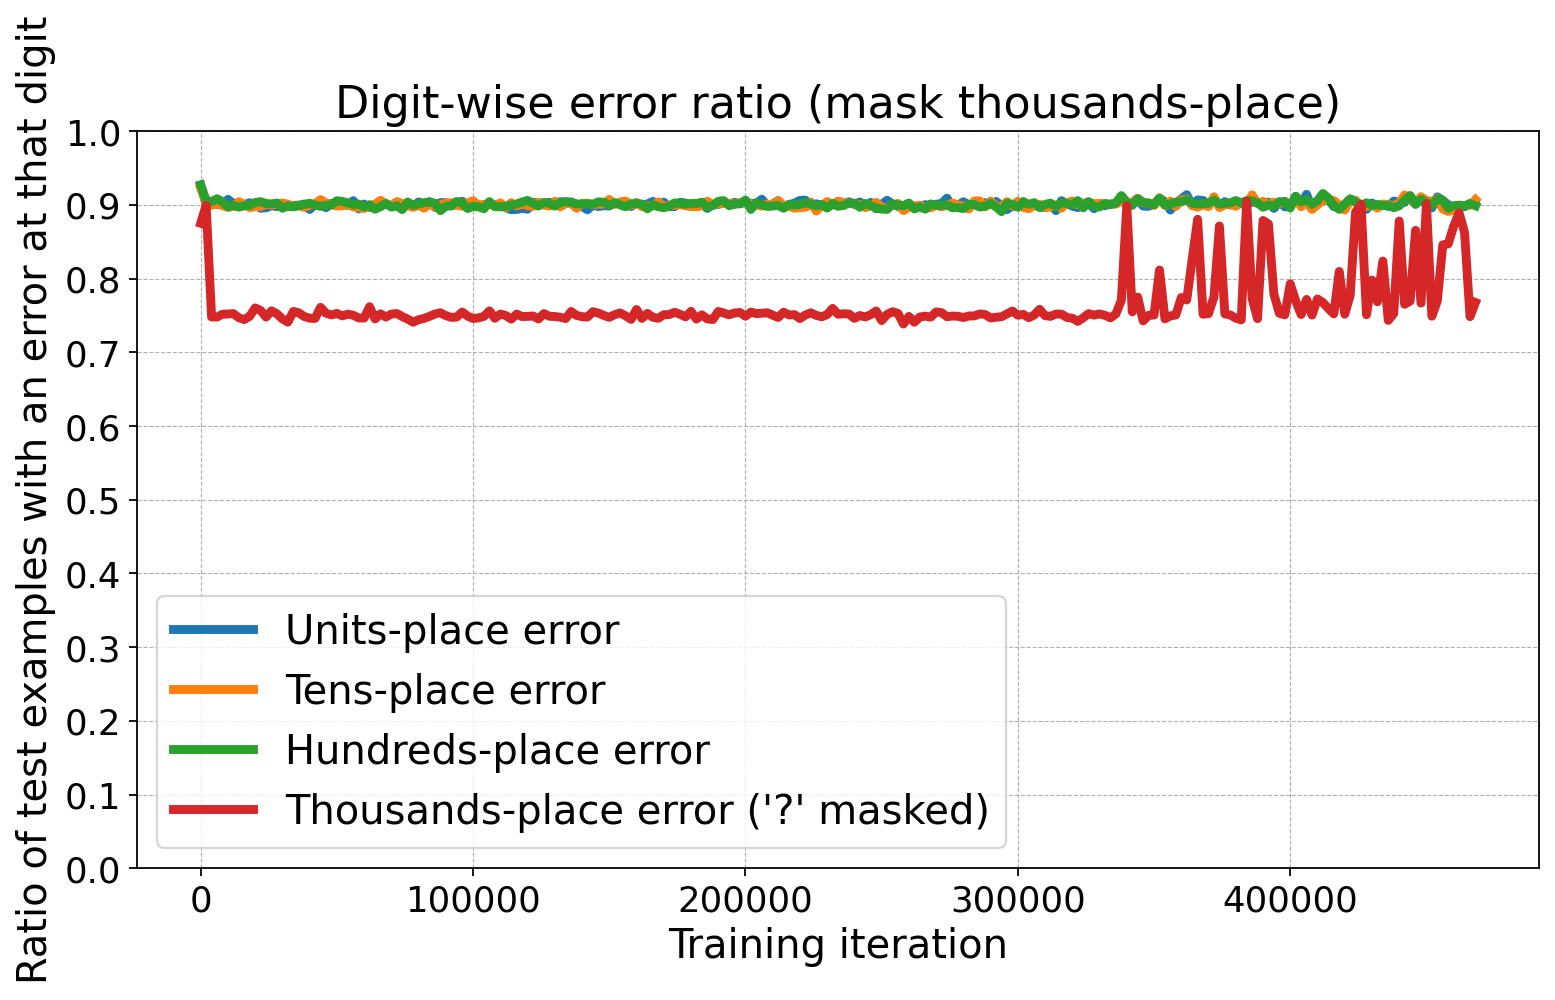

In [229]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams.update({
    "lines.linewidth": 4,        # default line thickness
    "axes.titlesize":   20,      # title font size
    "axes.labelsize":  18,      # x/y label font size
    "xtick.labelsize":  16,      # x‑tick label size
    "ytick.labelsize":  16,      # y‑tick label size
    "legend.fontsize":  18,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_output_randomize_thousands/reverse/4_operands_0_to_999_uniform_reverse/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 800000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit-wise mismatches between two sequences of strings/numbers.
    - Treat '?' as an ordinary digit character (so '?' in actual and '?' in pred at the same place counts as correct).
    - Strip any characters except digits and '?' from each cell (so noisy tokens like '+2', '++0', '>dap<' become '2', '0', '').
    - Right-align (zero-left-pad) so the rightmost character is the units place.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    allowed_re = re.compile(r"[0-9?]+")
    placeholder = " "  # used for completely-missing entries so they never match digits/'?'

    # 1) Sanitize actuals/preds into strings containing only digits and '?'
    str_actuals = []
    str_preds = []
    for a, p in zip(actuals, preds):
        # sanitize actual
        try:
            a_s = "" if (pd.isna(a)) else str(a)
        except Exception:
            a_s = ""
        comps = allowed_re.findall(a_s)
        a_clean = "".join(comps)
        str_actuals.append(a_clean)

        # sanitize pred
        try:
            p_s = "" if (pd.isna(p)) else str(p)
        except Exception:
            p_s = ""
        comps = allowed_re.findall(p_s)
        p_clean = "".join(comps)
        str_preds.append(p_clean)

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = 0
    if str_actuals or str_preds:
        max_width = max(
            max((len(s) for s in str_actuals), default=0),
            max((len(s) for s in str_preds), default=0),
        )
    # cap to available place names
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    max_width = min(max_width, len(base_places))
    if max_width == 0:
        # nothing to compare
        return {place: 0 for place in base_places[:4]}  # ensure basic keys exist

    place_names = base_places[:max_width]

    # 3) Initialize counters
    counts = {place: 0 for place in place_names}

    # 4) Compare digit-by-digit after right-aligning.
    # Use zfill for strings that contain at least one character (digits or '?').
    # For completely empty strings, use a placeholder that will never match digits/'?'.
    for a_raw, p_raw in zip(str_actuals, str_preds):
        if a_raw == "":
            a_pad = placeholder * max_width
        else:
            # zfill pads with '0' on the left; this preserves '?' digits correctly (they stay in-place).
            a_pad = a_raw.zfill(max_width)

        if p_raw == "":
            p_pad = placeholder * max_width
        else:
            p_pad = p_raw.zfill(max_width)

        # iterate positions left-to-right; convert to place index from right
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    # 5) Ensure the small set of places your plotting code expects exist
    for req in ("units", "tens", "hundreds", "thousands"):
        if req not in counts:
            counts[req] = 0

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands = [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])

# convert counts -> ratios in [0,1]
total = len(df)
if total == 0:
    raise ValueError("CSV appears empty (len(df) == 0)")

units = np.array(units, dtype=float) / total
tens = np.array(tens, dtype=float) / total
hundreds = np.array(hundreds, dtype=float) / total
thousands = np.array(thousands, dtype=float) / total

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place error")
plt.plot(iterations, tens,      label="Tens-place error")
plt.plot(iterations, hundreds,  label="Hundreds-place error")
plt.plot(iterations, thousands, label="Thousands-place error ('?' masked)")

plt.title("Digit-wise error ratio (mask thousands-place)")
plt.xlabel("Training iteration")
plt.ylabel("Ratio of test examples with an error at that digit")
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (2000, 'pred_iter_2000'), (4000, 'pred_iter_4000'), (6000, 'pred_iter_6000'), (8000, 'pred_iter_8000'), (10000, 'pred_iter_10000'), (12000, 'pred_iter_12000'), (14000, 'pred_iter_14000'), (16000, 'pred_iter_16000'), (18000, 'pred_iter_18000'), (20000, 'pred_iter_20000'), (22000, 'pred_iter_22000'), (24000, 'pred_iter_24000'), (26000, 'pred_iter_26000'), (28000, 'pred_iter_28000'), (30000, 'pred_iter_30000'), (32000, 'pred_iter_32000'), (34000, 'pred_iter_34000'), (36000, 'pred_iter_36000'), (38000, 'pred_iter_38000'), (40000, 'pred_iter_40000'), (42000, 'pred_iter_42000'), (44000, 'pred_iter_44000'), (46000, 'pred_iter_46000'), (48000, 'pred_iter_48000'), (50000, 'pred_iter_50000'), (52000, 'pred_iter_52000'), (54000, 'pred_iter_54000'), (56000, 'pred_iter_56000'), (58000, 'pred_iter_58000'), (60000, 'pred_iter_60000'), (62000, 'pred_iter_62000'), (64000, 'pred_iter_64000'), (66000, 'pred_iter_66000'), (68000, 'pred_iter_68000'), (70000, 'pred_iter_70000'), (72000,

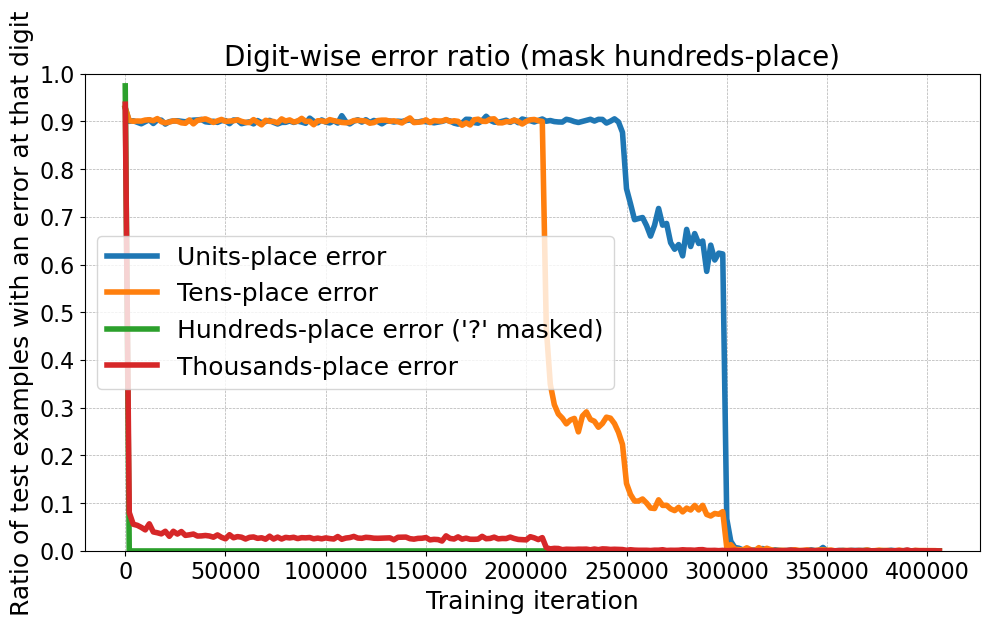

In [106]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams.update({
    "lines.linewidth": 4,        # default line thickness
    "axes.titlesize":   20,      # title font size
    "axes.labelsize":  18,      # x/y label font size
    "xtick.labelsize":  16,      # x‑tick label size
    "ytick.labelsize":  16,      # y‑tick label size
    "legend.fontsize":  18,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_output_wo_hundreds/4_operands_0_to_999_uniform_reverse/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 800000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit-wise mismatches between two sequences of strings/numbers.
    - Treat '?' as an ordinary digit character (so '?' in actual and '?' in pred at the same place counts as correct).
    - Strip any characters except digits and '?' from each cell (so noisy tokens like '+2', '++0', '>dap<' become '2', '0', '').
    - Right-align (zero-left-pad) so the rightmost character is the units place.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    allowed_re = re.compile(r"[0-9?]+")
    placeholder = " "  # used for completely-missing entries so they never match digits/'?'

    # 1) Sanitize actuals/preds into strings containing only digits and '?'
    str_actuals = []
    str_preds = []
    for a, p in zip(actuals, preds):
        # sanitize actual
        try:
            a_s = "" if (pd.isna(a)) else str(a)
        except Exception:
            a_s = ""
        comps = allowed_re.findall(a_s)
        a_clean = "".join(comps)
        str_actuals.append(a_clean)

        # sanitize pred
        try:
            p_s = "" if (pd.isna(p)) else str(p)
        except Exception:
            p_s = ""
        comps = allowed_re.findall(p_s)
        p_clean = "".join(comps)
        str_preds.append(p_clean)

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = 0
    if str_actuals or str_preds:
        max_width = max(
            max((len(s) for s in str_actuals), default=0),
            max((len(s) for s in str_preds), default=0),
        )
    # cap to available place names
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    max_width = min(max_width, len(base_places))
    if max_width == 0:
        # nothing to compare
        return {place: 0 for place in base_places[:4]}  # ensure basic keys exist

    place_names = base_places[:max_width]

    # 3) Initialize counters
    counts = {place: 0 for place in place_names}

    # 4) Compare digit-by-digit after right-aligning.
    # Use zfill for strings that contain at least one character (digits or '?').
    # For completely empty strings, use a placeholder that will never match digits/'?'.
    for a_raw, p_raw in zip(str_actuals, str_preds):
        if a_raw == "":
            a_pad = placeholder * max_width
        else:
            # zfill pads with '0' on the left; this preserves '?' digits correctly (they stay in-place).
            a_pad = a_raw.zfill(max_width)

        if p_raw == "":
            p_pad = placeholder * max_width
        else:
            p_pad = p_raw.zfill(max_width)

        # iterate positions left-to-right; convert to place index from right
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    # 5) Ensure the small set of places your plotting code expects exist
    for req in ("units", "tens", "hundreds", "thousands"):
        if req not in counts:
            counts[req] = 0

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands = [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])

# convert counts -> ratios in [0,1]
total = len(df)
if total == 0:
    raise ValueError("CSV appears empty (len(df) == 0)")

units = np.array(units, dtype=float) / total
tens = np.array(tens, dtype=float) / total
hundreds = np.array(hundreds, dtype=float) / total
thousands = np.array(thousands, dtype=float) / total

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place error")
plt.plot(iterations, tens,      label="Tens-place error")
plt.plot(iterations, hundreds,  label="Hundreds-place error ('?' masked)")
plt.plot(iterations, thousands, label="Thousands-place error")

plt.title("Digit-wise error ratio (mask hundreds-place)")
plt.xlabel("Training iteration")
plt.ylabel("Ratio of test examples with an error at that digit")
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (2000, 'pred_iter_2000'), (4000, 'pred_iter_4000'), (6000, 'pred_iter_6000'), (8000, 'pred_iter_8000'), (10000, 'pred_iter_10000'), (12000, 'pred_iter_12000'), (14000, 'pred_iter_14000'), (16000, 'pred_iter_16000'), (18000, 'pred_iter_18000'), (20000, 'pred_iter_20000'), (22000, 'pred_iter_22000'), (24000, 'pred_iter_24000'), (26000, 'pred_iter_26000'), (28000, 'pred_iter_28000'), (30000, 'pred_iter_30000'), (32000, 'pred_iter_32000'), (34000, 'pred_iter_34000'), (36000, 'pred_iter_36000'), (38000, 'pred_iter_38000'), (40000, 'pred_iter_40000'), (42000, 'pred_iter_42000'), (44000, 'pred_iter_44000'), (46000, 'pred_iter_46000'), (48000, 'pred_iter_48000'), (50000, 'pred_iter_50000'), (52000, 'pred_iter_52000'), (54000, 'pred_iter_54000'), (56000, 'pred_iter_56000'), (58000, 'pred_iter_58000'), (60000, 'pred_iter_60000'), (62000, 'pred_iter_62000'), (64000, 'pred_iter_64000'), (66000, 'pred_iter_66000'), (68000, 'pred_iter_68000'), (70000, 'pred_iter_70000'), (72000,

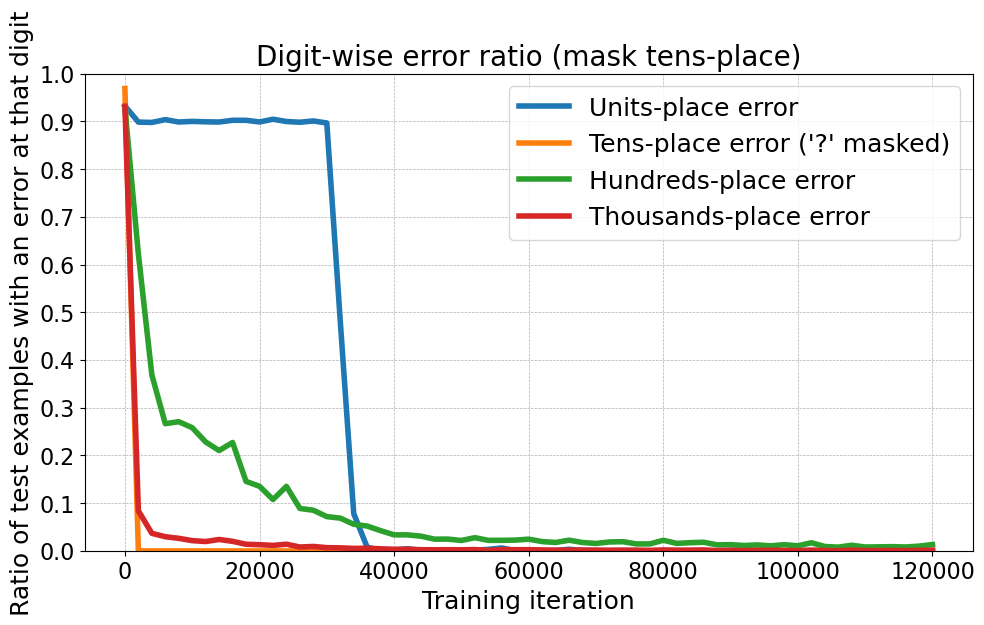

In [107]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams.update({
    "lines.linewidth": 4,        # default line thickness
    "axes.titlesize":   20,      # title font size
    "axes.labelsize":  18,      # x/y label font size
    "xtick.labelsize":  16,      # x‑tick label size
    "ytick.labelsize":  16,      # y‑tick label size
    "legend.fontsize":  18,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_output_wo_tens/reverse_out_wo_tens/4_operands_0_to_999_uniform_reverse/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 400000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit-wise mismatches between two sequences of strings/numbers.
    - Treat '?' as an ordinary digit character (so '?' in actual and '?' in pred at the same place counts as correct).
    - Strip any characters except digits and '?' from each cell (so noisy tokens like '+2', '++0', '>dap<' become '2', '0', '').
    - Right-align (zero-left-pad) so the rightmost character is the units place.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    allowed_re = re.compile(r"[0-9?]+")
    placeholder = " "  # used for completely-missing entries so they never match digits/'?'

    # 1) Sanitize actuals/preds into strings containing only digits and '?'
    str_actuals = []
    str_preds = []
    for a, p in zip(actuals, preds):
        # sanitize actual
        try:
            a_s = "" if (pd.isna(a)) else str(a)
        except Exception:
            a_s = ""
        comps = allowed_re.findall(a_s)
        a_clean = "".join(comps)
        str_actuals.append(a_clean)

        # sanitize pred
        try:
            p_s = "" if (pd.isna(p)) else str(p)
        except Exception:
            p_s = ""
        comps = allowed_re.findall(p_s)
        p_clean = "".join(comps)
        str_preds.append(p_clean)

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = 0
    if str_actuals or str_preds:
        max_width = max(
            max((len(s) for s in str_actuals), default=0),
            max((len(s) for s in str_preds), default=0),
        )
    # cap to available place names
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    max_width = min(max_width, len(base_places))
    if max_width == 0:
        # nothing to compare
        return {place: 0 for place in base_places[:4]}  # ensure basic keys exist

    place_names = base_places[:max_width]

    # 3) Initialize counters
    counts = {place: 0 for place in place_names}

    # 4) Compare digit-by-digit after right-aligning.
    # Use zfill for strings that contain at least one character (digits or '?').
    # For completely empty strings, use a placeholder that will never match digits/'?'.
    for a_raw, p_raw in zip(str_actuals, str_preds):
        if a_raw == "":
            a_pad = placeholder * max_width
        else:
            # zfill pads with '0' on the left; this preserves '?' digits correctly (they stay in-place).
            a_pad = a_raw.zfill(max_width)

        if p_raw == "":
            p_pad = placeholder * max_width
        else:
            p_pad = p_raw.zfill(max_width)

        # iterate positions left-to-right; convert to place index from right
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    # 5) Ensure the small set of places your plotting code expects exist
    for req in ("units", "tens", "hundreds", "thousands"):
        if req not in counts:
            counts[req] = 0

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands = [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])

# convert counts -> ratios in [0,1]
total = len(df)
if total == 0:
    raise ValueError("CSV appears empty (len(df) == 0)")

units = np.array(units, dtype=float) / total
tens = np.array(tens, dtype=float) / total
hundreds = np.array(hundreds, dtype=float) / total
thousands = np.array(thousands, dtype=float) / total

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place error")
plt.plot(iterations, tens,      label="Tens-place error ('?' masked)")
plt.plot(iterations, hundreds,  label="Hundreds-place error")
plt.plot(iterations, thousands, label="Thousands-place error")

plt.title("Digit-wise error ratio (mask tens-place)")
plt.xlabel("Training iteration")
plt.ylabel("Ratio of test examples with an error at that digit")
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (2000, 'pred_iter_2000'), (4000, 'pred_iter_4000'), (6000, 'pred_iter_6000'), (8000, 'pred_iter_8000'), (10000, 'pred_iter_10000'), (12000, 'pred_iter_12000'), (14000, 'pred_iter_14000'), (16000, 'pred_iter_16000'), (18000, 'pred_iter_18000'), (20000, 'pred_iter_20000'), (22000, 'pred_iter_22000'), (24000, 'pred_iter_24000'), (26000, 'pred_iter_26000'), (28000, 'pred_iter_28000'), (30000, 'pred_iter_30000'), (32000, 'pred_iter_32000'), (34000, 'pred_iter_34000'), (36000, 'pred_iter_36000'), (38000, 'pred_iter_38000'), (40000, 'pred_iter_40000'), (42000, 'pred_iter_42000'), (44000, 'pred_iter_44000'), (46000, 'pred_iter_46000'), (48000, 'pred_iter_48000'), (50000, 'pred_iter_50000'), (52000, 'pred_iter_52000'), (54000, 'pred_iter_54000'), (56000, 'pred_iter_56000'), (58000, 'pred_iter_58000'), (60000, 'pred_iter_60000'), (62000, 'pred_iter_62000'), (64000, 'pred_iter_64000'), (66000, 'pred_iter_66000'), (68000, 'pred_iter_68000'), (70000, 'pred_iter_70000'), (72000,

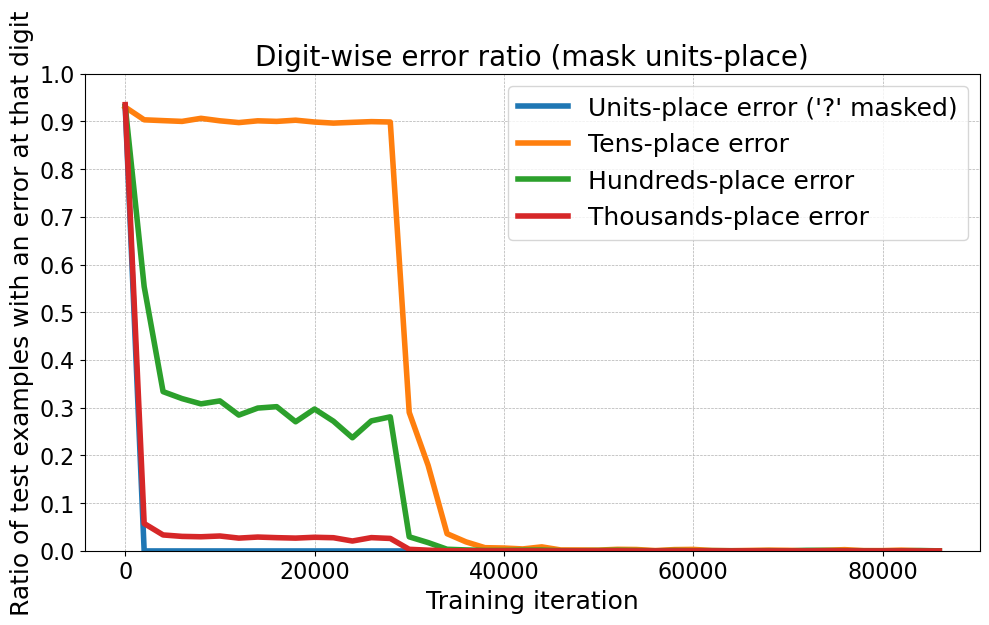

In [108]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams.update({
    "lines.linewidth": 4,        # default line thickness
    "axes.titlesize":   20,      # title font size
    "axes.labelsize":  18,      # x/y label font size
    "xtick.labelsize":  16,      # x‑tick label size
    "ytick.labelsize":  16,      # y‑tick label size
    "legend.fontsize":  18,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_output_wo_units/4_operands_0_to_999_uniform_reverse/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 800000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit-wise mismatches between two sequences of strings/numbers.
    - Treat '?' as an ordinary digit character (so '?' in actual and '?' in pred at the same place counts as correct).
    - Strip any characters except digits and '?' from each cell (so noisy tokens like '+2', '++0', '>dap<' become '2', '0', '').
    - Right-align (zero-left-pad) so the rightmost character is the units place.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    allowed_re = re.compile(r"[0-9?]+")
    placeholder = " "  # used for completely-missing entries so they never match digits/'?'

    # 1) Sanitize actuals/preds into strings containing only digits and '?'
    str_actuals = []
    str_preds = []
    for a, p in zip(actuals, preds):
        # sanitize actual
        try:
            a_s = "" if (pd.isna(a)) else str(a)
        except Exception:
            a_s = ""
        comps = allowed_re.findall(a_s)
        a_clean = "".join(comps)
        str_actuals.append(a_clean)

        # sanitize pred
        try:
            p_s = "" if (pd.isna(p)) else str(p)
        except Exception:
            p_s = ""
        comps = allowed_re.findall(p_s)
        p_clean = "".join(comps)
        str_preds.append(p_clean)

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = 0
    if str_actuals or str_preds:
        max_width = max(
            max((len(s) for s in str_actuals), default=0),
            max((len(s) for s in str_preds), default=0),
        )
    # cap to available place names
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    max_width = min(max_width, len(base_places))
    if max_width == 0:
        # nothing to compare
        return {place: 0 for place in base_places[:4]}  # ensure basic keys exist

    place_names = base_places[:max_width]

    # 3) Initialize counters
    counts = {place: 0 for place in place_names}

    # 4) Compare digit-by-digit after right-aligning.
    # Use zfill for strings that contain at least one character (digits or '?').
    # For completely empty strings, use a placeholder that will never match digits/'?'.
    for a_raw, p_raw in zip(str_actuals, str_preds):
        if a_raw == "":
            a_pad = placeholder * max_width
        else:
            # zfill pads with '0' on the left; this preserves '?' digits correctly (they stay in-place).
            a_pad = a_raw.zfill(max_width)

        if p_raw == "":
            p_pad = placeholder * max_width
        else:
            p_pad = p_raw.zfill(max_width)

        # iterate positions left-to-right; convert to place index from right
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    # 5) Ensure the small set of places your plotting code expects exist
    for req in ("units", "tens", "hundreds", "thousands"):
        if req not in counts:
            counts[req] = 0

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands = [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])

# convert counts -> ratios in [0,1]
total = len(df)
if total == 0:
    raise ValueError("CSV appears empty (len(df) == 0)")

units = np.array(units, dtype=float) / total
tens = np.array(tens, dtype=float) / total
hundreds = np.array(hundreds, dtype=float) / total
thousands = np.array(thousands, dtype=float) / total

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place error ('?' masked)")
plt.plot(iterations, tens,      label="Tens-place error")
plt.plot(iterations, hundreds,  label="Hundreds-place error")
plt.plot(iterations, thousands, label="Thousands-place error")

plt.title("Digit-wise error ratio (mask units-place)")
plt.xlabel("Training iteration")
plt.ylabel("Ratio of test examples with an error at that digit")
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/2402289181.py:8: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')


Iteration	Avg Abs Error
0		12579.7223
1000		275.0136
2000		274.1123
3000		70.3030
4000		44.4308
5000		36.8613
6000		35.8032
7000		32.5568
8000		32.6670
9000		32.4033
10000		30.7748
11000		31.7859
12000		30.3713
13000		29.8202
14000		28.9055
15000		28.8691
16000		30.9199
17000		27.6839
18000		31.5404
19000		28.7293
20000		29.5334
21000		29.2991
22000		28.1897
23000		27.9544
24000		28.3699
25000		28.9753
26000		27.0292
27000		27.5841
28000		28.8816
29000		31.3338
30000		27.7766
31000		28.5524
32000		26.6738
33000		27.7388
34000		27.7521
35000		4.9780
36000		3.6191
37000		3.4625
38000		3.2697
39000		3.1554
40000		2.9795
41000		2.8193
42000		3.2121
43000		3.2831
44000		2.9151
45000		2.8120
46000		2.8331
47000		3.0647
48000		2.7252
49000		2.8575
50000		3.6842
51000		2.6903
52000		2.7963
53000		2.7882
54000		2.7598
55000		2.6712
56000		2.9488
57000		2.7225
58000		2.6756
59000		2.6397
60000		2.7804
61000		2.9857
62000		2.6628
63000		2.6867
64000		2.6766
65000		2.7533
66000		2.7090
67000		2.75

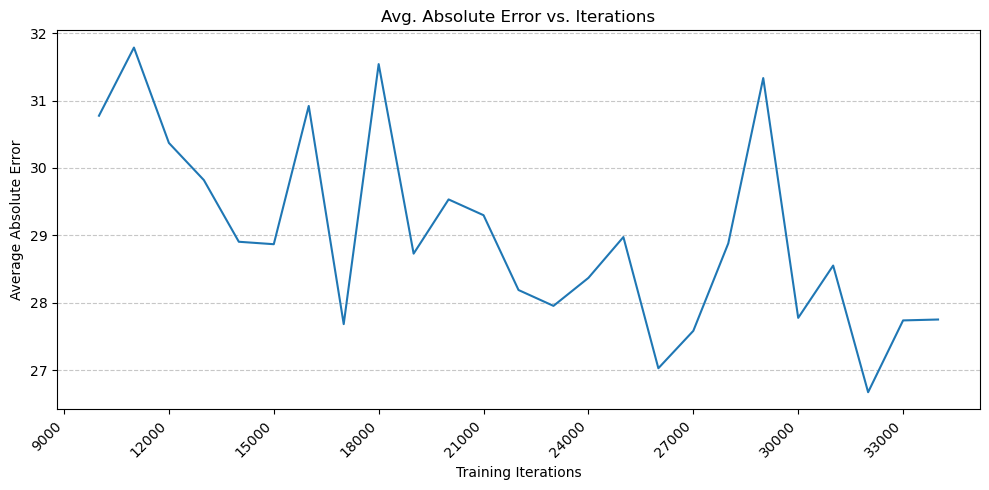

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/2402289181.py:99: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


[(0, 'pred_iter_0'), (1000, 'pred_iter_1000'), (2000, 'pred_iter_2000'), (3000, 'pred_iter_3000'), (4000, 'pred_iter_4000'), (5000, 'pred_iter_5000'), (6000, 'pred_iter_6000'), (7000, 'pred_iter_7000'), (8000, 'pred_iter_8000'), (9000, 'pred_iter_9000'), (10000, 'pred_iter_10000'), (11000, 'pred_iter_11000'), (12000, 'pred_iter_12000'), (13000, 'pred_iter_13000'), (14000, 'pred_iter_14000'), (15000, 'pred_iter_15000'), (16000, 'pred_iter_16000'), (17000, 'pred_iter_17000'), (18000, 'pred_iter_18000'), (19000, 'pred_iter_19000'), (20000, 'pred_iter_20000'), (21000, 'pred_iter_21000'), (22000, 'pred_iter_22000'), (23000, 'pred_iter_23000'), (24000, 'pred_iter_24000'), (25000, 'pred_iter_25000'), (26000, 'pred_iter_26000'), (27000, 'pred_iter_27000'), (28000, 'pred_iter_28000'), (29000, 'pred_iter_29000'), (30000, 'pred_iter_30000'), (31000, 'pred_iter_31000'), (32000, 'pred_iter_32000'), (33000, 'pred_iter_33000'), (34000, 'pred_iter_34000'), (35000, 'pred_iter_35000'), (36000, 'pred_ite

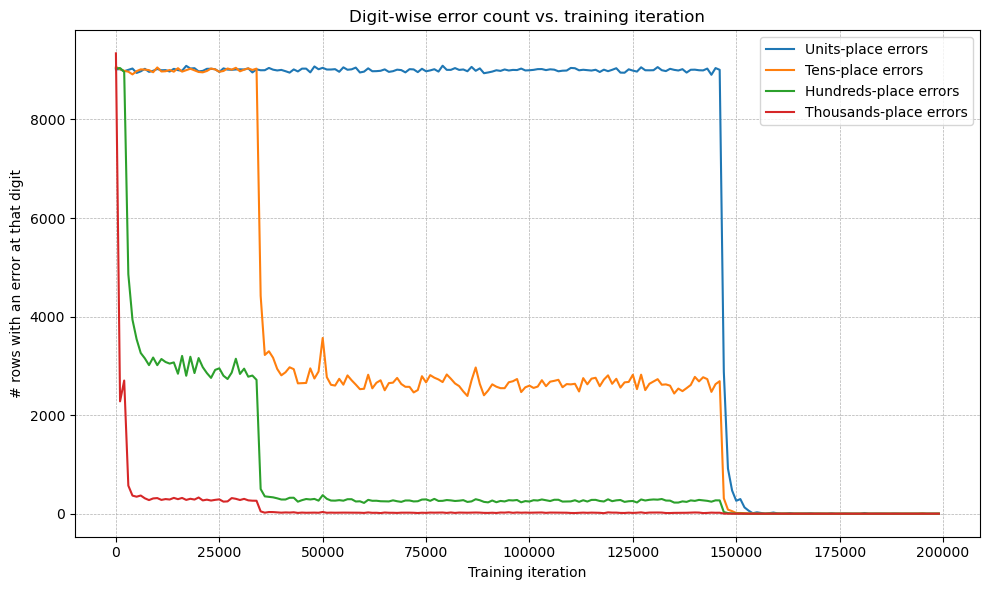

In [84]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1) Load your data
df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')

# 2) Identify the iteration‐columns
iter_cols = [c for c in df.columns if c.startswith('pred_iter_')]

# 3) Clean & convert to nullable integer, preserving any decimal point
for col in iter_cols:
    #  a) ensure strings
    #  b) strip everything except digits and dot
    cleaned = (
        df[col]
        .astype(str)
        .str.replace(r'[^0-9\.]', '', regex=True)
        .replace('', np.nan)           # empty → NaN
    )
    #  c) parse to float, then to pandas’ nullable Int64
    df[col] = (
        pd.to_numeric(cleaned, errors='coerce')
          .astype('Int64')
    )

# 4) Compute absolute errors
errors = df[iter_cols].sub(df['actual'], axis=0).abs()

# 5) Compute the average error at each iteration
avg_abs_err = errors.mean(axis=0)

# 6a) build err_map (same as above)
err_map = {}
for col, err in avg_abs_err.items():
    m = re.match(r'pred_iter_(\d+)$', col)
    if m:
        iteration = int(m.group(1))
        err_map[iteration] = err

# 6b) sort
iterations = sorted(err_map)
errors_sorted = [err_map[it] for it in iterations]

# 1) Choose your desired window
min_iter, max_iter = 10000, 34000

# 2) Filter both lists
iters_filt = []
errs_filt  = []
for it, err in zip(iterations, errors_sorted):
    if min_iter <= it <= max_iter:
        iters_filt.append(it)
        errs_filt.append(err)

# ─── NEW: print the iteration & its avg. error ───
print("Iteration\tAvg Abs Error")
for it, err in zip(iterations, errors_sorted):
    print(f"{it}\t\t{err:.4f}")


# 7) Plot with tweaks
fig, ax = plt.subplots(figsize=(10, 5))                   # wider figure
ax.plot(iters_filt, errs_filt, linestyle='-')

# Only horizontal grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Throttle x‐ticks: show at most 10 evenly spaced labels
ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))

# Rotate the x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('Training Iterations')
ax.set_ylabel('Average Absolute Error')
ax.set_title('Avg. Absolute Error vs. Iterations')
plt.tight_layout()


plt.show()

import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 400000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/3491268155.py:12: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


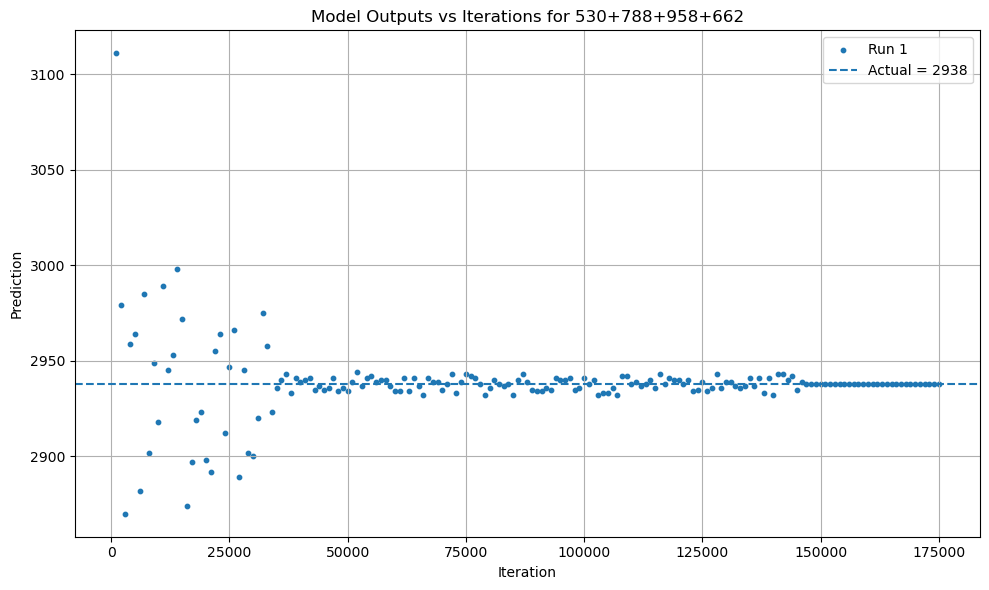

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_outputs(
    csv_path: str,
    example_operands: str,
    num_lines: int = 1,
    iter_min: int = 0,
    iter_max: int = None
):
    # Load data
    df = pd.read_csv(csv_path)
    
    # Filter the desired example(s)
    df_filtered = df[df['operands'] == example_operands].head(num_lines)
    if df_filtered.empty:
        raise ValueError(f"No rows found for operands '{example_operands}'")
    
    # Identify only the integer‐suffixed pred columns
    all_iter_cols = [
        col for col in df.columns 
        if col.startswith('pred_iter_') and col.replace('pred_iter_', '').isdigit()
    ]
    iterations = [int(col.replace('pred_iter_', '')) for col in all_iter_cols]
    
    # Apply iteration range
    if iter_max is None:
        iter_max = max(iterations)
    mask = [(iter_min <= it <= iter_max) for it in iterations]
    iter_cols = [c for c, m in zip(all_iter_cols, mask) if m]
    iters     = [it for it, m in zip(iterations,    mask) if m]
    
    plt.figure(figsize=(10, 6))
    
    for idx, (_, row) in enumerate(df_filtered.iterrows()):
        # Coerce to numeric, turning bad strings into NaN
        preds_series = pd.to_numeric(row[iter_cols], errors='coerce')
        # Drop any NaNs (and their corresponding iterations)
        valid = preds_series.notna()
        valid_iters = [it for it, v in zip(iters, valid) if v]
        valid_preds = preds_series[valid].tolist()
        
        plt.scatter(
            valid_iters,
            valid_preds,
            label=f'Run {idx+1}',
            marker='o',
            s=10
        )
    
    # Actual value line
    actual_value = df_filtered['actual'].iloc[0]
    plt.axhline(
        y=actual_value,
        linestyle='--',
        label=f'Actual = {actual_value}',
    )
    
    plt.title(f'Model Outputs vs Iterations for {example_operands}')
    plt.xlabel('Iteration')
    plt.ylabel('Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Example usage
if __name__ == "__main__":
    plot_model_outputs(
        csv_path='/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv',  # your CSV path
        example_operands="530+788+958+662",
        num_lines=1,
        iter_min=1000,
        iter_max=175000
    )


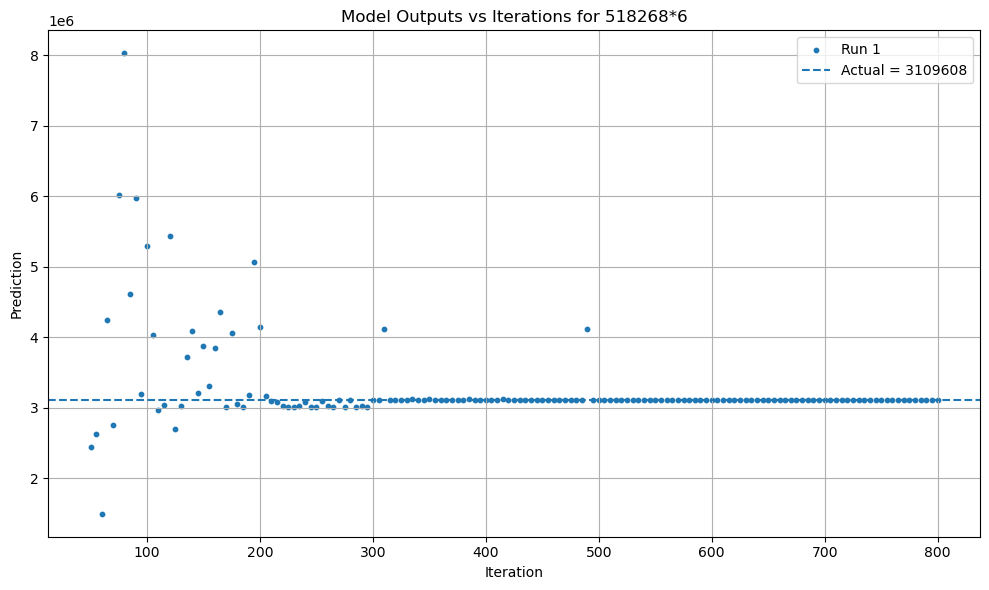

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_outputs(
    csv_path: str,
    example_operands: str,
    num_lines: int = 1,
    iter_min: int = 0,
    iter_max: int = None
):
    # Load data
    df = pd.read_csv(csv_path)
    
    # Filter the desired example(s)
    df_filtered = df[df['operands'] == example_operands].head(num_lines)
    if df_filtered.empty:
        raise ValueError(f"No rows found for operands '{example_operands}'")
    
    # Identify only the integer‐suffixed pred columns
    all_iter_cols = [
        col for col in df.columns 
        if col.startswith('pred_iter_') and col.replace('pred_iter_', '').isdigit()
    ]
    iterations = [int(col.replace('pred_iter_', '')) for col in all_iter_cols]
    
    # Apply iteration range
    if iter_max is None:
        iter_max = max(iterations)
    mask = [(iter_min <= it <= iter_max) for it in iterations]
    iter_cols = [c for c, m in zip(all_iter_cols, mask) if m]
    iters     = [it for it, m in zip(iterations,    mask) if m]
    
    plt.figure(figsize=(10, 6))
    
    for idx, (_, row) in enumerate(df_filtered.iterrows()):
        # Coerce to numeric, turning bad strings into NaN
        preds_series = pd.to_numeric(row[iter_cols], errors='coerce')
        # Drop any NaNs (and their corresponding iterations)
        valid = preds_series.notna()
        valid_iters = [it for it, v in zip(iters, valid) if v]
        valid_preds = preds_series[valid].tolist()
        
        plt.scatter(
            valid_iters,
            valid_preds,
            label=f'Run {idx+1}',
            marker='o',
            s=10
        )
    
    # Actual value line
    actual_value = df_filtered['actual'].iloc[0]
    plt.axhline(
        y=actual_value,
        linestyle='--',
        label=f'Actual = {actual_value}',
    )
    
    plt.title(f'Model Outputs vs Iterations for {example_operands}')
    plt.xlabel('Iteration')
    plt.ylabel('Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Example usage
if __name__ == "__main__":
    plot_model_outputs(
        csv_path='/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/0_to_six_digit_times_1_digit/reverse_out/0_to_six_digit_times_1_digit_reverse/0_to_six_digit_times_1_digit_bal_test_results.csv',  # your CSV path
        example_operands="518268*6",
        num_lines=1,
        iter_min=50,
        iter_max=800
    )


# MAE v.s. iter

Selected pred_iter	MAE	count_used
100	111.945260	2996
200	45.182304	2995
300	41.777518	2998
400	31.927285	2998
500	28.096667	3000
600	15.190397	2999
700	14.749333	3000
800	12.118333	3000
900	10.993333	3000
1000	10.842281	2999
1100	8.465000	3000
1200	4.511667	3000
1300	3.258000	3000
1400	3.673667	3000
1500	2.953000	3000
1600	2.979000	3000
1700	2.381667	3000
1800	2.967667	3000
1900	2.695667	3000
2000	3.401000	3000
2100	2.120667	3000
2200	2.520333	3000
2300	1.823000	3000
2400	2.456000	3000
2500	2.167000	3000
2600	1.181667	3000
2700	1.828333	3000
2800	1.150333	3000
2900	0.901000	3000
3000	0.829333	3000
3100	1.001667	3000
3200	0.676333	3000
3300	1.011667	3000
3400	0.707000	3000
3500	0.644000	3000
3600	0.633667	3000
3700	0.603667	3000
3800	0.546000	3000
3900	0.665333	3000
4000	0.830000	3000
4100	0.519667	3000
4200	0.420000	3000
4300	0.455333	3000
4400	0.396667	3000
4500	0.500333	3000
4600	0.396667	3000
4700	0.560667	3000
4800	0.538667	3000
4900	0.445000	3000
Saved plot to: mae_by_pred_iter.p

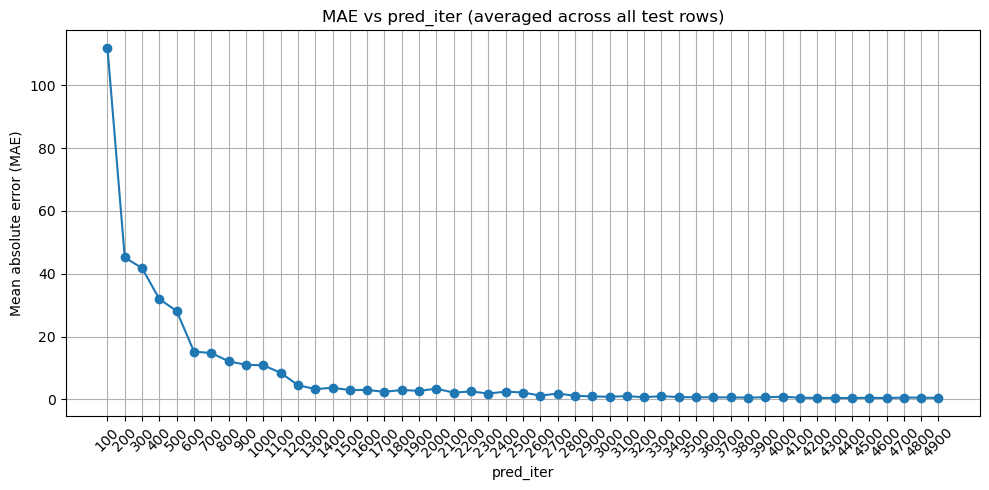

In [1]:
#!/usr/bin/env python3
"""
Compute and plot average absolute error (MAE) across all test rows for each
pred_iter column in a CSV file. Set the CSV path and x-range directly in the
script by editing CSV_PATH, MIN_ITER, MAX_ITER below.
"""
from pathlib import Path
import re
import ast
import operator as op

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------- USER CONFIG -----------------
CSV_PATH = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/2_operands_0_to_999_subtraction/reverse_out/2_operands_0_to_999_subtraction_reverse/test_reverse_results.csv'

# Set the inclusive pred_iter range you want plotted.
# Examples:
#   MIN_ITER = 100; MAX_ITER = 400
#   MIN_ITER = None; MAX_ITER = 500  -> plot everything <= 500
#   MIN_ITER = None; MAX_ITER = None -> plot all pred_iter columns
MIN_ITER = 50
MAX_ITER = 5000
# ------------------------------------------------

# --- Safe evaluator that supports only integers, + and - ---
_allowed_binops = {ast.Add: op.add, ast.Sub: op.sub}
_allowed_unaryops = {ast.UAdd: op.pos, ast.USub: op.neg}


def _eval_ast(node):
    if isinstance(node, ast.Constant):  # python 3.8+
        if isinstance(node.value, (int,)):
            return node.value
        else:
            raise ValueError("Only integer constants allowed")
    if isinstance(node, ast.Num):  # older AST node
        return node.n
    if isinstance(node, ast.BinOp):
        if type(node.op) not in _allowed_binops:
            raise ValueError("Only + and - binary operations allowed")
        left = _eval_ast(node.left)
        right = _eval_ast(node.right)
        return _allowed_binops[type(node.op)](left, right)
    if isinstance(node, ast.UnaryOp):
        if type(node.op) not in _allowed_unaryops:
            raise ValueError("Only unary + and - allowed")
        operand = _eval_ast(node.operand)
        return _allowed_unaryops[type(node.op)](operand)
    raise ValueError("Unsupported expression")


def safe_eval_int(expr: str):
    """
    Safely evaluate a simple integer expression containing only + and -.
    """
    tree = ast.parse(expr, mode="eval")
    return int(_eval_ast(tree.body))


def parse_prediction_cell(cell: str):
    """
    Parse messy prediction cell into an integer prediction.

    Strategy:
      1. If empty/NaN -> return None
      2. Try safe_eval_int (handles '388-7', '790+4', '6-44' etc.)
      3. If safe eval fails, fallback to regex r'[-+]?\d+' and return the last match
    """
    if pd.isna(cell):
        return None
    s = str(cell).strip()
    if s == "":
        return None

    try:
        return safe_eval_int(s)
    except Exception:
        tokens = re.findall(r'[-+]?\d+', s)
        if not tokens:
            return None
        return int(tokens[-1])


def compute_mae_by_pred_iter(df: pd.DataFrame, actual_col: str = "actual"):
    """
    Return:
      pred_cols (sorted), x_iters (int suffixes), maes, counts
    """
    pred_cols = [c for c in df.columns if c.startswith("pred_iter")]
    if not pred_cols:
        raise ValueError("No pred_iter_* columns found in the CSV")

    def iter_key(colname):
        m = re.search(r"pred_iter[_-]?(\d+)", colname)
        if m:
            return int(m.group(1))
        return float('inf')

    pred_cols = sorted(pred_cols, key=iter_key)
    x_iters = [iter_key(c) for c in pred_cols]

    df_actuals = pd.to_numeric(df[actual_col], errors="coerce")

    maes = []
    counts = []
    for col in pred_cols:
        parsed = df[col].apply(parse_prediction_cell)
        valid_mask = (~df_actuals.isna()) & (~pd.isna(parsed))
        if valid_mask.sum() == 0:
            maes.append(np.nan)
            counts.append(0)
            continue
        abs_errors = (df_actuals[valid_mask] - parsed[valid_mask]).abs()
        maes.append(abs_errors.mean())
        counts.append(int(valid_mask.sum()))

    return pred_cols, x_iters, maes, counts


def filter_by_range(x_iters, maes, counts, min_iter=None, max_iter=None):
    """
    Keep only entries with min_iter <= x <= max_iter (inclusive).
    If min_iter or max_iter is None, treat as unbounded.
    """
    filtered_x = []
    filtered_mae = []
    filtered_counts = []
    for x, m, c in zip(x_iters, maes, counts):
        if x == float('inf'):
            continue
        if min_iter is not None and x < min_iter:
            continue
        if max_iter is not None and x > max_iter:
            continue
        filtered_x.append(x)
        filtered_mae.append(m)
        filtered_counts.append(c)
    return filtered_x, filtered_mae, filtered_counts


def plot_mae(filtered_x, filtered_mae, out_path="mae_by_pred_iter.png"):
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_x, filtered_mae, marker="o", linestyle="-")
    plt.xlabel("pred_iter")
    plt.ylabel("Mean absolute error (MAE)")
    plt.title("MAE vs pred_iter (averaged across all test rows)")
    plt.grid(True)
    plt.xticks(filtered_x, [str(x) for x in filtered_x], rotation=45)
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Saved plot to: {out_path}")
    plt.show()


def main():
    csv_path = Path(CSV_PATH)
    if not csv_path.exists():
        raise FileNotFoundError(f"{csv_path} not found. Edit CSV_PATH at top of script.")

    df = pd.read_csv(csv_path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]

    if "actual" not in df.columns:
        raise ValueError("CSV must contain an 'actual' column with ground-truth integers.")

    pred_cols, x_iters, maes, counts = compute_mae_by_pred_iter(df, actual_col="actual")

    filtered_x, filtered_mae, filtered_counts = filter_by_range(
        x_iters, maes, counts, min_iter=MIN_ITER, max_iter=MAX_ITER
    )

    if not filtered_x:
        print("No pred_iter columns fall into the provided range. Nothing to plot.")
        print("Available pred_iter values:", x_iters)
        return

    # Print the selected results
    print("Selected pred_iter\tMAE\tcount_used")
    for x, m, c in zip(filtered_x, filtered_mae, filtered_counts):
        print(f"{x}\t{(m if not np.isnan(m) else float('nan')):.6f}\t{c}")

    plot_mae(filtered_x, filtered_mae, out_path="mae_by_pred_iter.png")


if __name__ == "__main__":
    main()


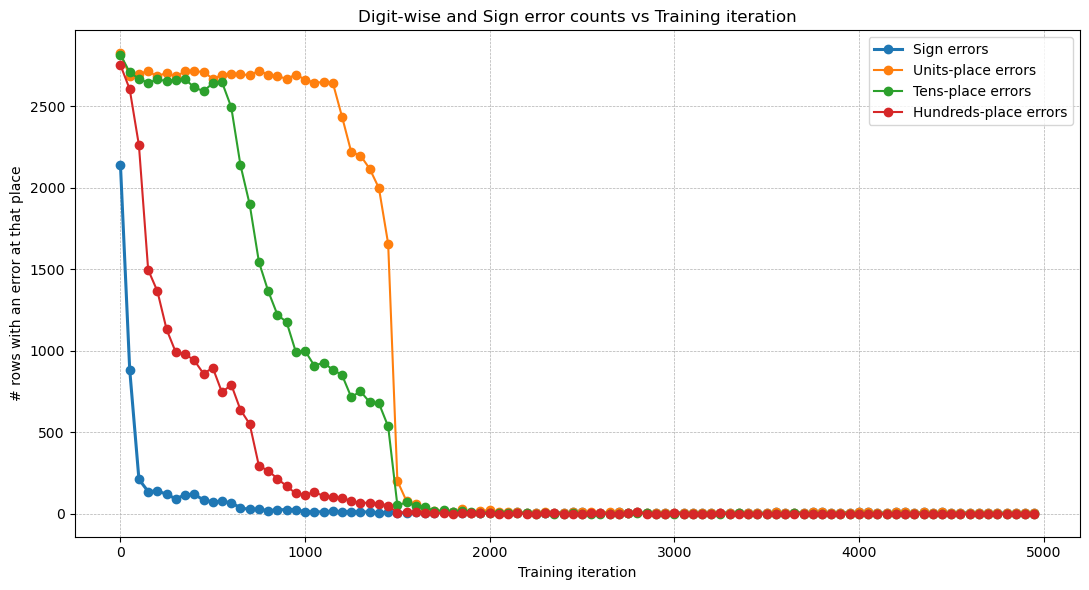

In [3]:
#!/usr/bin/env python3
"""
Digit-wise error plot with an additional "sign-place" line.

Edit CSV_PATH, STEP_SIZE, OFFSET, MIN_ITER, MAX_ITER below and run.
"""
from pathlib import Path
import re
import ast
import operator as op
from typing import Iterable, List, Dict, Optional

import pandas as pd
import matplotlib.pyplot as plt

# ---------------- USER CONFIG ----------------
CSV_PATH  = Path(
    '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/2_operands_0_to_999_subtraction_balanced_digit/reverse_out/2_operands_0_to_999_subtraction_balanced_digit_reverse_1/test_reverse_results.csv'
)
STEP_SIZE = 5
OFFSET    = 0
MIN_ITER  = None   # inclusive lower bound on pred_iter numeric suffix, or None
MAX_ITER  = None   # inclusive upper bound on pred_iter numeric suffix, or None
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ----------------------------------------------


# --- Safe mini-evaluator (only integers, + and -) ---
_allowed_binops = {ast.Add: op.add, ast.Sub: op.sub}
_allowed_unaryops = {ast.UAdd: op.pos, ast.USub: op.neg}


def _eval_ast(node):
    if isinstance(node, ast.Constant):  # python 3.8+
        if isinstance(node.value, int):
            return node.value
        raise ValueError("Only integer constants allowed")
    if isinstance(node, ast.Num):
        return node.n
    if isinstance(node, ast.BinOp):
        if type(node.op) not in _allowed_binops:
            raise ValueError("Only + and - supported")
        return _allowed_binops[type(node.op)](_eval_ast(node.left), _eval_ast(node.right))
    if isinstance(node, ast.UnaryOp):
        if type(node.op) not in _allowed_unaryops:
            raise ValueError("Only unary + and - supported")
        return _allowed_unaryops[type(node.op)](_eval_ast(node.operand))
    raise ValueError("Unsupported AST node")


def safe_eval_int(expr: str) -> int:
    """Safely evaluate a simple integer expression containing only + and -."""
    tree = ast.parse(expr, mode="eval")
    return int(_eval_ast(tree.body))


def parse_prediction_cell(cell) -> Optional[int]:
    """
    Parse messy prediction cell into integer, or return None if cannot parse.
    Strategy:
      1. If NaN/empty -> None
      2. Try safe_eval_int (handles '388-7', '790+4', '6-44' etc.)
      3. Fallback: regex find ints and return last token (change to [0] for first)
    """
    if pd.isna(cell):
        return None
    s = str(cell).strip()
    if s == "":
        return None
    try:
        return safe_eval_int(s)
    except Exception:
        tokens = re.findall(r"[-+]?\d+", s)
        if not tokens:
            return None
        return int(tokens[-1])


# ---------------- Digit error tally (includes sign place) ----------------
def digit_error_tally(actuals: Iterable, preds: Iterable, max_places_hint: Optional[int] = None) -> Dict[str, int]:
    """
    Count sign errors + digit-wise mismatches.
    - actuals: iterable of ints (or values convertible to int)
    - preds: iterable of ints or None (parsed predictions)
    Returns a dict with keys: "sign", "units", "tens", "hundreds", ...
    """
    # Convert actuals to ints (or None if missing). Predictions should already be parsed ints or None.
    acts: List[Optional[int]] = []
    ps: List[Optional[int]] = []
    for a, p in zip(actuals, preds):
        try:
            acts.append(int(a))
        except Exception:
            acts.append(None)
        if p is None:
            ps.append(None)
        else:
            try:
                ps.append(int(p))
            except Exception:
                ps.append(None)

    # Determine maximum digit width (based primarily on actuals so we evaluate relevant places)
    abs_lengths = [len(str(abs(x))) for x in acts if x is not None]
    # also consider preds if they exist and are larger than actuals
    abs_lengths += [len(str(abs(x))) for x in ps if x is not None]
    max_width = max(abs_lengths) if abs_lengths else 1
    if max_places_hint:
        max_width = max(max_width, max_places_hint)

    # limit to some reasonable labeling size
    # base_places = ["units", "tens", "hundreds", "thousands", "ten-thousands", "hundred-thousands", "millions"]
    base_places = ["units", "tens", "hundreds"]
    max_width = min(max_width, len(base_places))
    place_names = base_places[:max_width]

    # initialize counters, include sign
    counts = {"sign": 0}
    for name in place_names:
        counts[name] = 0

    # iterate rows
    for a_val, p_val in zip(acts, ps):
        # if actual missing, skip the row (can't evaluate)
        if a_val is None:
            continue

        # sign check: if prediction missing -> treat as sign error
        if p_val is None:
            counts["sign"] += 1
            # treat as digit-errors for all places (prediction unknown => counted as wrong)
            for name in place_names:
                counts[name] += 1
            continue

        # both present -> sign differ?
        actual_neg = a_val < 0
        pred_neg = p_val < 0
        if actual_neg != pred_neg:
            counts["sign"] += 1

        # digit-wise: compare absolute values, zero-pad on the left to max_width
        a_digits = str(abs(a_val)).zfill(max_width)
        p_digits = str(abs(p_val)).zfill(max_width)
        # compare left-to-right (but place label mapping uses right-to-left)
        for i in range(max_width):
            # position from right: place_idx
            place_idx = max_width - 1 - i
            place_name = place_names[place_idx]
            if a_digits[i] != p_digits[i]:
                counts[place_name] += 1

    return counts


# ---------------- Main processing ----------------
def main():
    if not CSV_PATH.exists():
        raise FileNotFoundError(f"{CSV_PATH} not found. Edit CSV_PATH at top of file.")

    df = pd.read_csv(CSV_PATH, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]

    if ACTUAL_COL not in df.columns:
        raise ValueError(f"CSV must contain an '{ACTUAL_COL}' column.")

    # collect pred_iter columns satisfying STEP/OFFSET and optional MIN/MAX bounds
    pred_cols = []
    for col in df.columns:
        m = re.fullmatch(PRED_REGEX, col)
        if not m:
            continue
        step = int(m.group(1))
        if step < OFFSET:
            continue
        if (step - OFFSET) % STEP_SIZE != 0:
            continue
        if (MIN_ITER is not None and step < MIN_ITER) or (MAX_ITER is not None and step > MAX_ITER):
            continue
        pred_cols.append((step, col))
    pred_cols.sort(key=lambda x: x[0])

    if not pred_cols:
        print("No pred_iter columns matched selection. Check STEP_SIZE/OFFSET/MIN_ITER/MAX_ITER/PRED_REGEX.")
        return

    iterations = []
    sign_counts = []
    # dynamic place lists prepared after first tally (we want consistent ordering)
    place_order: List[str] = []
    place_counts_map: Dict[str, List[int]] = {}

    # For performance, parse columns lazily and reuse parsing
    for step, col in pred_cols:
        # parse predictions for this column
        parsed_preds = df[col].apply(parse_prediction_cell)
        counts = digit_error_tally(df[ACTUAL_COL], parsed_preds)
        iterations.append(step)
        sign_counts.append(counts["sign"])

        # initialize place_order map if first time
        if not place_order:
            # collect place keys except "sign" in descending order we want to plot
            place_order = [k for k in counts.keys() if k != "sign"]
            # ensure a consistent order: units, tens, hundreds, ... (already produced in that order)
            for pn in place_order:
                place_counts_map[pn] = []
        # append counts for each place in place_order
        for pn in place_order:
            place_counts_map[pn].append(counts.get(pn, 0))

    # ---------- Plot ----------
    plt.figure(figsize=(11, 6))
    # plot sign first with bolder style
    plt.plot(iterations, sign_counts, label="Sign errors", linewidth=2.2, marker="o")

    # plot each digit place (units, tens, hundreds, ...)
    for pn in place_order:
        plt.plot(iterations, place_counts_map[pn], label=f"{pn.capitalize()}-place errors", marker="o", linestyle="-")

    plt.title("Digit-wise and Sign error counts vs Training iteration")
    plt.xlabel("Training iteration")
    plt.ylabel("# rows with an error at that place")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


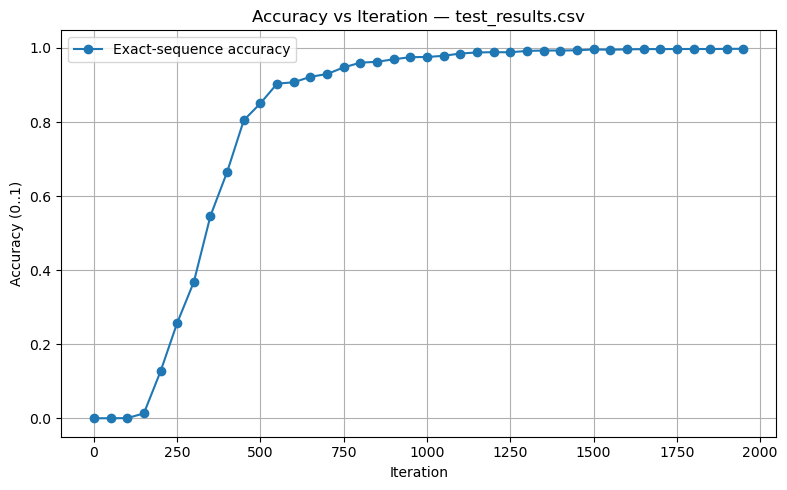

In [7]:
#!/usr/bin/env python3
"""
plot_accuracy.py

Reads a CSV/TSV where:
 - one column is named "actual"
 - prediction columns are named like "pred_iter_0", "pred_iter_50", ...
It treats each cell as a comma-separated token list (e.g. "0,10,499,5035"),
computes token-level accuracy per iteration (average fraction of tokens correct
per row), and plots accuracy vs iteration. Also plots sequence-exact-match
accuracy (optional).

Usage:
    python plot_accuracy.py data.tsv
"""

filepath = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit_a_bunch_of_test/out/4_operands_sorting_balanced_digit_a_bunch_of_test_3/test_results.csv'
save_name = None  # or 'accuracy_plot.png'

import sys
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def read_table_try(filepath: str) -> pd.DataFrame:
    """Try reading the file as tab-separated first, then as comma-separated."""
    # try tab first (your sample looks tab-separated)
    try:
        df = pd.read_csv(filepath, sep='\t', engine='python')
        # if it only produced 1 column and file contains tabs, fallback
        if df.shape[1] == 1:
            # try comma-separated
            df = pd.read_csv(filepath, sep=',', engine='python')
        return df
    except Exception:
        # final fallback: let pandas auto-detect
        return pd.read_csv(filepath, sep=None, engine='python')

def tokens_from_field(s):
    """Convert a cell string to list of tokens.
       - If already list-like (NaN etc) handle safely.
       - Strips whitespace.
    """
    if pd.isna(s):
        return []
    if isinstance(s, (list, tuple)):
        return list(s)
    s = str(s).strip()
    if s == "":
        return []
    # split on comma; also accept other delimiters if needed
    toks = [t.strip() for t in s.split(',') if t.strip() != ""]
    return toks

def extract_iter_num(colname):
    m = re.search(r'pred_iter_(\d+)', colname)
    return int(m.group(1)) if m else None

def main(filepath, show_exact_match=True, save_as=None):
    df = read_table_try(filepath)
    # ensure lowercase column names for tolerant matching
    df.columns = [c.strip() for c in df.columns]

    if 'actual' not in [c.lower() for c in df.columns]:
        # try case-insensitive find
        actual_col = None
        for c in df.columns:
            if c.lower() == 'actual':
                actual_col = c
                break
        if actual_col is None:
            raise RuntimeError("No 'actual' column found in the input file.")
    else:
        # get original casing column name
        actual_col = next(c for c in df.columns if c.lower() == 'actual')

    # find prediction columns
    pred_cols = [c for c in df.columns if c.lower().startswith('pred_iter_')]
    if len(pred_cols) == 0:
        # allow slight variants like Pred_Iter_50
        pred_cols = [c for c in df.columns if re.search(r'pred[_\-]?iter[_\-]?\d+', c, flags=re.I)]

    if len(pred_cols) == 0:
        raise RuntimeError("No prediction columns like 'pred_iter_XXX' found.")

    # sort pred columns by iteration number
    pred_cols_with_iter = []
    for c in pred_cols:
        num = extract_iter_num(c)
        if num is None:
            # try to extract any number in the name
            m = re.search(r'(\d+)', c)
            num = int(m.group(1)) if m else 0
        pred_cols_with_iter.append((num, c))
    pred_cols_with_iter.sort()
    iters = [num for num, _ in pred_cols_with_iter]
    pred_cols_sorted = [c for _, c in pred_cols_with_iter]

    # compute token-level accuracy per row per iteration
    exact_seq_acc_per_iter = []

    # Pre-tokenize actuals
    actual_tokens_list = [tokens_from_field(x) for x in df[actual_col]]

    for col in pred_cols_sorted:
        pred_tokens_list = [tokens_from_field(x) for x in df[col]]

        row_exact_matches = []
        for actual_tokens, pred_tokens in zip(actual_tokens_list, pred_tokens_list):
            exact = (actual_tokens == pred_tokens)
            row_exact_matches.append(1.0 if exact else 0.0)

        # average across rows
        exact_seq_acc_per_iter.append(np.mean(row_exact_matches))

    # plot
    plt.figure(figsize=(8,5))
    plt.plot(iters, exact_seq_acc_per_iter, marker='o', label='Exact-sequence accuracy')
    # plt.plot(iters, exact_seq_acc_per_iter, label='Exact-sequence accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (0..1)')
    plt.title(f'Accuracy vs Iteration — {Path(filepath).name}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_as:
        plt.savefig(save_as)
        print(f"Saved plot to {save_as}")
    else:
        plt.show()

if __name__ == '__main__':
    main(filepath, show_exact_match=True, save_as=save_name)


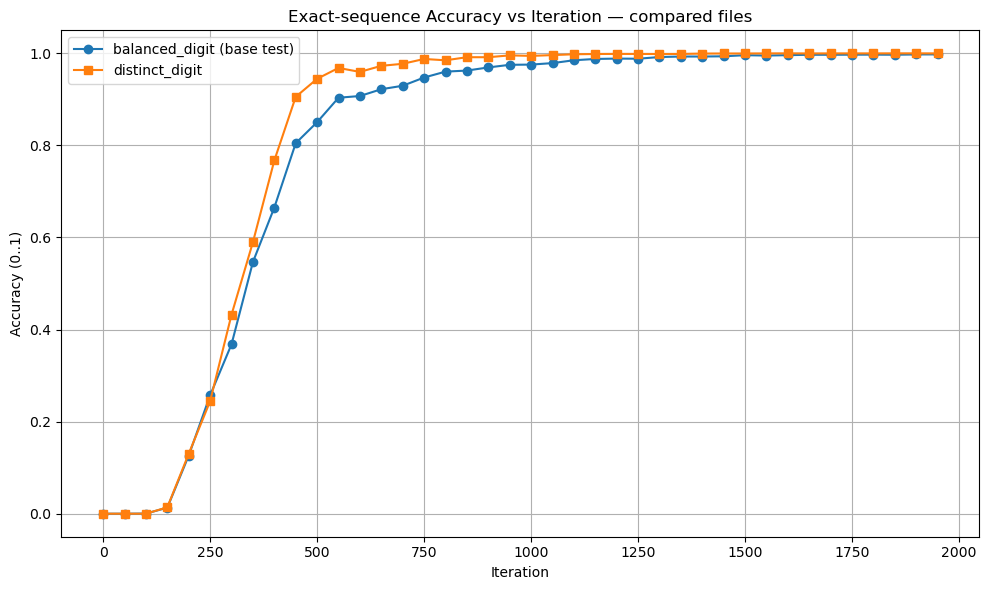

In [12]:
#!/usr/bin/env python3
"""
plot_accuracy.py

Reads one or more CSV/TSV files where:
 - one column is named "actual"
 - prediction columns are named like "pred_iter_0", "pred_iter_50", ...
Each cell is treated as a comma-separated token list (e.g. "0,10,499,5035").

Computes accuracy vs iteration for each file and plots them on the same figure.

Usage:
    # edit filepaths below, or call from CLI:
    python plot_accuracy.py path/to/results1.csv path/to/results2.csv
"""

import sys
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import cycle
from typing import List, Tuple, Dict

file_specs : List[Tuple[str, str]] = [
    ('balanced_digit (base test)','/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit_a_bunch_of_test/out/4_operands_sorting_balanced_digit_a_bunch_of_test_3/test_results.csv'),
    ('distinct_digit', '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit_a_bunch_of_test/out/4_operands_sorting_balanced_digit_a_bunch_of_test_3/test_different_digit_results.csv')
]


save_name = None  # or 'accuracy_compare.png'
metric = 'exact'   # 'exact' for exact-sequence accuracy, 'token' for token-level accuracy

# --- helpers ---
def read_table_try(filepath: str) -> pd.DataFrame:
    """Try reading the file as tab-separated first, then as comma-separated."""
    try:
        df = pd.read_csv(filepath, sep='\t', engine='python')
        if df.shape[1] == 1:
            df = pd.read_csv(filepath, sep=',', engine='python')
        return df
    except Exception:
        return pd.read_csv(filepath, sep=None, engine='python')

def tokens_from_field(s):
    """Convert a cell string to list of tokens."""
    if pd.isna(s):
        return []
    if isinstance(s, (list, tuple)):
        return list(s)
    s = str(s).strip()
    if s == "":
        return []
    toks = [t.strip() for t in s.split(',') if t.strip() != ""]
    return toks

def extract_iter_num(colname: str) -> int:
    m = re.search(r'pred[_\-]?iter[_\-]?(?:_|-)?(\d+)', colname, flags=re.I)
    if m:
        return int(m.group(1))
    m2 = re.search(r'(\d+)', colname)
    return int(m2.group(1)) if m2 else 0

def find_actual_column(cols: List[str]) -> str:
    for c in cols:
        if c.strip().lower() == 'actual':
            return c
    raise RuntimeError("No 'actual' column found in the input file.")

def find_pred_columns(cols: List[str]) -> List[str]:
    pred_cols = [c for c in cols if re.search(r'pred[_\-]?iter[_\-]?\d+', c, flags=re.I)]
    if not pred_cols:
        pred_cols = [c for c in cols if c.lower().startswith('pred_iter_')]
    return pred_cols

def compute_accuracies_for_df(df: pd.DataFrame, metric: str = 'exact') -> Tuple[List[int], List[float]]:
    """
    Returns (iters_sorted, accuracies) for the given dataframe.
    metric: 'exact' or 'token'
    """
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    actual_col = find_actual_column(df.columns)
    pred_cols = find_pred_columns(df.columns)
    if not pred_cols:
        raise RuntimeError("No prediction columns like 'pred_iter_XXX' found.")

    # sort prediction columns by iteration number
    pred_with_iter = [(extract_iter_num(c), c) for c in pred_cols]
    pred_with_iter.sort()
    iters = [num for num, _ in pred_with_iter]
    pred_cols_sorted = [c for _, c in pred_with_iter]

    # Pre-tokenize actuals
    actual_tokens_list = [tokens_from_field(x) for x in df[actual_col]]

    accuracies = []
    for col in pred_cols_sorted:
        pred_tokens_list = [tokens_from_field(x) for x in df[col]]

        row_scores = []
        for actual_tokens, pred_tokens in zip(actual_tokens_list, pred_tokens_list):
            if metric == 'exact':
                row_scores.append(1.0 if actual_tokens == pred_tokens else 0.0)
            elif metric == 'token':
                if len(actual_tokens) == 0:
                    row_scores.append(1.0 if len(pred_tokens) == 0 else 0.0)
                else:
                    correct = 0
                    for i, atok in enumerate(actual_tokens):
                        if i < len(pred_tokens) and pred_tokens[i] == atok:
                            correct += 1
                    row_scores.append(correct / len(actual_tokens))
            else:
                raise ValueError("metric must be 'exact' or 'token'")

        accuracies.append(float(np.mean(row_scores)))

    return iters, accuracies

def load_and_compute(file: Tuple[str, str], metric: str) -> Tuple[str, List[int], List[float]]:
    df = read_table_try(file[1])
    iters, accs = compute_accuracies_for_df(df, metric=metric)
    return file[0], iters, accs

# --- main plotting ---
def plot_files(file_specs: List[Tuple[str, str]], metric: str = 'exact', save_as: str = None):

    data = []
    for f in file_specs:
        try:
            name, iters, accs = load_and_compute(f, metric)
            data.append((name, iters, accs))
        except Exception as e:
            print(f"Failed to process {p}: {e}")

    if not data:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(10,6))
    marker_cycle = cycle(['o','s','^','D','v','x','P','*'])
    for name, iters, accs in data:
        m = next(marker_cycle)
        plt.plot(iters, accs, marker=m, label=name)

    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (0..1)')
    metric_label = 'Exact-sequence' if metric == 'exact' else 'Token-level'
    plt.title(f'{metric_label} Accuracy vs Iteration — compared files')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()

    if save_as:
        plt.savefig(save_as)
        print(f"Saved plot to {save_as}")
    else:
        plt.show()

# --- CLI / entrypoint ---
if __name__ == '__main__':

    plot_files(file_specs, metric=metric, save_as=save_name)


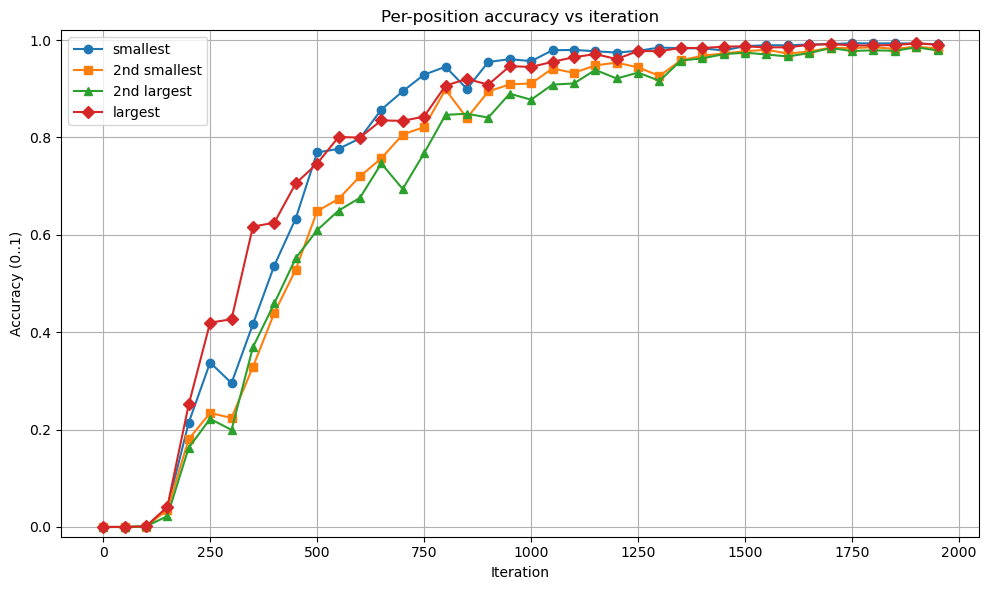

In [14]:
#!/usr/bin/env python3
"""
plot_per_position_accuracy.py

Reads a CSV/TSV that contains columns:
 - 'actual' (the target sequence, e.g. "1001,1658,3957,5919")
 - prediction columns named like 'pred_iter_0', 'pred_iter_50', 'pred_iter_250', ...

Computes per-position accuracy (position 0 = smallest, 1 = 2nd smallest, 2 = 2nd largest, 3 = largest)
averaged across all rows, for each iteration, and plots accuracy vs iteration.

Usage:
    python plot_per_position_accuracy.py results.csv
    python plot_per_position_accuracy.py results.csv --out plot.png
"""
from __future__ import annotations
import argparse
import re
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit_a_bunch_of_test/out/4_operands_sorting_balanced_digit_a_bunch_of_test_3/test_all_4_digit_results.csv'
path = Path(file_path)

# --- helpers ---
def read_table_try(path: str) -> pd.DataFrame:
    """Try reading as TSV first, then CSV if it looks like a single-column TSV."""
    # try TSV
    try:
        df = pd.read_csv(path, sep='\t', engine='python')
        # if only one column, try comma
        if df.shape[1] == 1:
            df = pd.read_csv(path, sep=',', engine='python')
        return df
    except Exception:
        # fallback generic
        return pd.read_csv(path, sep=None, engine='python')

def tokens_from_field(s: object) -> List[str]:
    """Convert a cell value to list of trimmed tokens split by commas.
    Handles nan, empty strings, lists, etc."""
    if pd.isna(s):
        return []
    if isinstance(s, (list, tuple)):
        return list(s)
    s = str(s).strip()
    if s == "":
        return []
    toks = [t.strip() for t in s.split(',') if t.strip() != ""]
    return toks

def extract_iter_num(colname: str) -> int:
    """Extract integer iteration number from a column name like 'pred_iter_250'."""
    m = re.search(r'pred[_\-]?iter[_\-]?(\d+)', colname, flags=re.I)
    if m:
        return int(m.group(1))
    m2 = re.search(r'(\d+)', colname)
    return int(m2.group(1)) if m2 else 0

def find_actual_column(cols: List[str]) -> str:
    for c in cols:
        if c.strip().lower() == 'actual':
            return c
    # fallback: a column named 'target' maybe
    for c in cols:
        if c.strip().lower() in ('target', 'labels'):
            return c
    raise RuntimeError("No 'actual' column found in the input file. Columns: " + ", ".join(cols))

def find_pred_columns(cols: List[str]) -> List[str]:
    pred_cols = [c for c in cols if re.search(r'pred[_\-]?iter[_\-]?\d+', c, flags=re.I)]
    if not pred_cols:
        # fallback: any column starting with 'pred_iter_'
        pred_cols = [c for c in cols if c.lower().startswith('pred_iter_')]
    return pred_cols

# --- main computation ---
def compute_position_accuracies(df: pd.DataFrame, positions: int = 4) -> Tuple[List[int], Dict[int, List[float]]]:
    """
    For each prediction column (pred_iter_XXX) compute averaged position-wise accuracies.
    Returns (iters_sorted, accuracies_by_pos) where accuracies_by_pos[pos] is a list of accuracies aligned with iters_sorted.
    """
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    actual_col = find_actual_column(df.columns)
    pred_cols = find_pred_columns(df.columns)
    if not pred_cols:
        raise RuntimeError("No prediction columns like 'pred_iter_XXX' found.")

    # sort pred columns by iteration number
    pred_with_iter = [(extract_iter_num(c), c) for c in pred_cols]
    pred_with_iter.sort()
    iters = [num for num, _ in pred_with_iter]
    pred_cols_sorted = [c for _, c in pred_with_iter]

    # parse actual tokens for every row
    actual_tokens_list = [tokens_from_field(x) for x in df[actual_col]]
    # filter rows that do not have enough actual tokens (we expect e.g. 4 positions)
    valid_row_mask = [len(toklist) >= positions for toklist in actual_tokens_list]
    if not any(valid_row_mask):
        raise RuntimeError(f"No rows have at least {positions} tokens in the '{actual_col}' column.")
    # We'll average across rows that have at least `positions` actual tokens
    # Build per-pred-column per-position counts
    n_rows = int(np.sum(valid_row_mask))
    accuracies_by_pos: Dict[int, List[float]] = {p: [] for p in range(positions)}

    # For each pred column compute accuracy per position
    for col in pred_cols_sorted:
        correct_counts = np.zeros(positions, dtype=float)
        # parse predictions for each row
        pred_tokens_all = [tokens_from_field(x) for x in df[col]]
        # iterate rows
        for is_valid, actual_tokens, pred_tokens in zip(valid_row_mask, actual_tokens_list, pred_tokens_all):
            if not is_valid:
                continue
            # compare by index
            for p in range(positions):
                a_tok = actual_tokens[p] if p < len(actual_tokens) else None
                pred_tok = pred_tokens[p] if p < len(pred_tokens) else None
                if a_tok is not None and pred_tok is not None and pred_tok == a_tok:
                    correct_counts[p] += 1.0
        # compute mean (divide by number of valid rows)
        if n_rows > 0:
            pos_accs = (correct_counts / float(n_rows)).tolist()
        else:
            pos_accs = [0.0] * positions
        for p in range(positions):
            accuracies_by_pos[p].append(pos_accs[p])

    return iters, accuracies_by_pos

def plot_position_accuracies(iters: List[int], accs_by_pos: Dict[int, List[float]],
                             labels: List[str] = None, out: str | None = None):
    plt.figure(figsize=(10,6))
    markers = ['o', 's', '^', 'D', 'v', 'x', 'P', '*']
    if labels is None:
        labels = [f'pos_{p}' for p in sorted(accs_by_pos.keys())]

    for p, label in zip(sorted(accs_by_pos.keys()), labels):
        vals = accs_by_pos[p]
        mark = markers[p % len(markers)]
        plt.plot(iters, vals, marker=mark, label=label)

    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (0..1)')
    plt.ylim(-0.02, 1.02)
    plt.title('Per-position accuracy vs iteration')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    if out:
        plt.savefig(out, dpi=200)
        print(f"Saved plot to {out}")
    else:
        plt.show()

# --- CLI ---
def main():


    if not path.exists():
        raise FileNotFoundError(f"{path} does not exist")

    df = read_table_try(str(path))
    iters, accs_by_pos = compute_position_accuracies(df, positions=4)

    labels = ['smallest', '2nd smallest', '2nd largest', 'largest']

    plot_position_accuracies(iters, accs_by_pos, labels=labels, out=None)

if __name__ == '__main__':
    main()


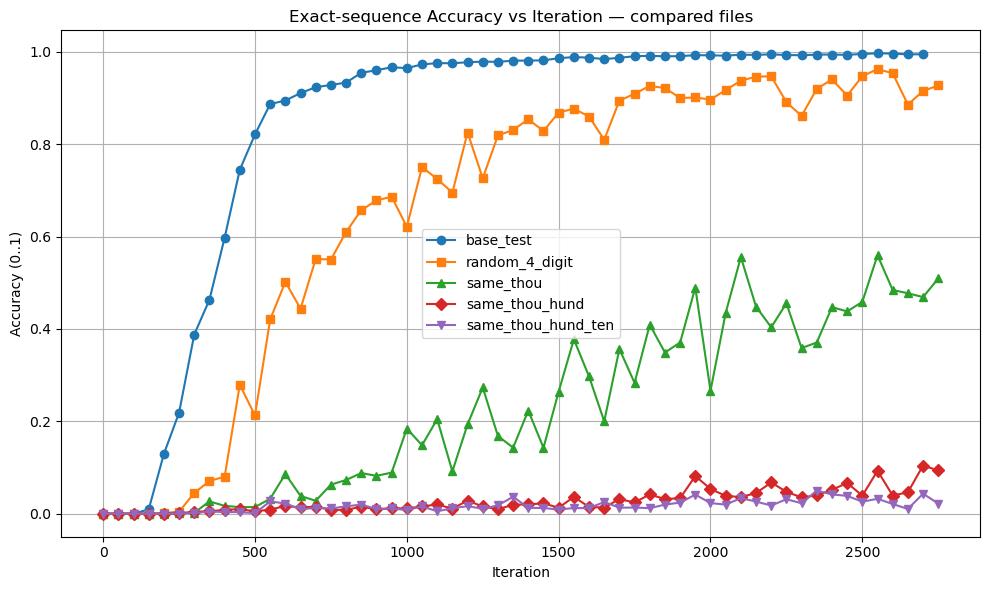

In [2]:
#!/usr/bin/env python3
"""
plot_accuracy.py

Reads one or more CSV/TSV files where:
 - one column is named "actual"
 - prediction columns are named like "pred_iter_0", "pred_iter_50", ...
Each cell is treated as a comma-separated token list (e.g. "0,10,499,5035").

Computes accuracy vs iteration for each file and plots them on the same figure.

Usage:
    # edit filepaths below, or call from CLI:
    python plot_accuracy.py path/to/results1.csv path/to/results2.csv
"""

import sys
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import cycle
from typing import List, Tuple, Dict

file_specs : List[Tuple[str, str]] = [
    ('base_test', '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit/digitwise_test_out/4_operands_sorting_balanced_digit/test_results.csv'),
    ('random_4_digit','/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit/digitwise_test_out/4_operands_sorting_balanced_digit/digitwise_random_results.csv'),
    ('same_thou', '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit/digitwise_test_out/4_operands_sorting_balanced_digit/digitwise_thousand_results.csv'),
    ('same_thou_hund', '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit/digitwise_test_out/4_operands_sorting_balanced_digit/digitwise_hundred_results.csv'),
    ('same_thou_hund_ten', '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit/digitwise_test_out/4_operands_sorting_balanced_digit/digitwise_ten_results.csv')
]


save_name = None  # or 'accuracy_compare.png'
metric = 'exact'   # 'exact' for exact-sequence accuracy, 'token' for token-level accuracy

# --- helpers ---
def read_table_try(filepath: str) -> pd.DataFrame:
    """Try reading the file as tab-separated first, then as comma-separated."""
    try:
        df = pd.read_csv(filepath, sep='\t', engine='python')
        if df.shape[1] == 1:
            df = pd.read_csv(filepath, sep=',', engine='python')
        return df
    except Exception:
        return pd.read_csv(filepath, sep=None, engine='python')

def tokens_from_field(s):
    """Convert a cell string to list of tokens."""
    if pd.isna(s):
        return []
    if isinstance(s, (list, tuple)):
        return list(s)
    s = str(s).strip()
    if s == "":
        return []
    toks = [t.strip() for t in s.split(',') if t.strip() != ""]
    return toks

def extract_iter_num(colname: str) -> int:
    m = re.search(r'pred[_\-]?iter[_\-]?(?:_|-)?(\d+)', colname, flags=re.I)
    if m:
        return int(m.group(1))
    m2 = re.search(r'(\d+)', colname)
    return int(m2.group(1)) if m2 else 0

def find_actual_column(cols: List[str]) -> str:
    for c in cols:
        if c.strip().lower() == 'actual':
            return c
    raise RuntimeError("No 'actual' column found in the input file.")

def find_pred_columns(cols: List[str]) -> List[str]:
    pred_cols = [c for c in cols if re.search(r'pred[_\-]?iter[_\-]?\d+', c, flags=re.I)]
    if not pred_cols:
        pred_cols = [c for c in cols if c.lower().startswith('pred_iter_')]
    return pred_cols

def compute_accuracies_for_df(df: pd.DataFrame, metric: str = 'exact') -> Tuple[List[int], List[float]]:
    """
    Returns (iters_sorted, accuracies) for the given dataframe.
    metric: 'exact' or 'token'
    """
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    actual_col = find_actual_column(df.columns)
    pred_cols = find_pred_columns(df.columns)
    if not pred_cols:
        raise RuntimeError("No prediction columns like 'pred_iter_XXX' found.")

    # sort prediction columns by iteration number
    pred_with_iter = [(extract_iter_num(c), c) for c in pred_cols]
    pred_with_iter.sort()
    iters = [num for num, _ in pred_with_iter]
    pred_cols_sorted = [c for _, c in pred_with_iter]

    # Pre-tokenize actuals
    actual_tokens_list = [tokens_from_field(x) for x in df[actual_col]]

    accuracies = []
    for col in pred_cols_sorted:
        pred_tokens_list = [tokens_from_field(x) for x in df[col]]

        row_scores = []
        for actual_tokens, pred_tokens in zip(actual_tokens_list, pred_tokens_list):
            if metric == 'exact':
                row_scores.append(1.0 if actual_tokens == pred_tokens else 0.0)
            elif metric == 'token':
                if len(actual_tokens) == 0:
                    row_scores.append(1.0 if len(pred_tokens) == 0 else 0.0)
                else:
                    correct = 0
                    for i, atok in enumerate(actual_tokens):
                        if i < len(pred_tokens) and pred_tokens[i] == atok:
                            correct += 1
                    row_scores.append(correct / len(actual_tokens))
            else:
                raise ValueError("metric must be 'exact' or 'token'")

        accuracies.append(float(np.mean(row_scores)))

    return iters, accuracies

def load_and_compute(file: Tuple[str, str], metric: str) -> Tuple[str, List[int], List[float]]:
    df = read_table_try(file[1])
    iters, accs = compute_accuracies_for_df(df, metric=metric)
    return file[0], iters, accs

# --- main plotting ---
def plot_files(file_specs: List[Tuple[str, str]], metric: str = 'exact', save_as: str = None):

    data = []
    for f in file_specs:
        try:
            name, iters, accs = load_and_compute(f, metric)
            data.append((name, iters, accs))
        except Exception as e:
            print(f"Failed to process {p}: {e}")

    if not data:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(10,6))
    marker_cycle = cycle(['o','s','^','D','v','x','P','*'])
    for name, iters, accs in data:
        m = next(marker_cycle)
        plt.plot(iters, accs, marker=m, label=name)

    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (0..1)')
    metric_label = 'Exact-sequence' if metric == 'exact' else 'Token-level'
    plt.title(f'{metric_label} Accuracy vs Iteration — compared files')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()

    if save_as:
        plt.savefig(save_as)
        print(f"Saved plot to {save_as}")
    else:
        plt.show()

# --- CLI / entrypoint ---
if __name__ == '__main__':

    plot_files(file_specs, metric=metric, save_as=save_name)


In [ ]:
#!/usr/bin/env python3
"""
plot_pos_accuracy.py

Usage:
    python plot_pos_accuracy.py --csv data.csv --position 2 --out acc_pos2.png

- --csv : path to your csv file
- --position : 1-based index of the position to measure (1,2,3,4,...)
- --out : (optional) path to save the plot image (default: pos_accuracy.png)
- --show : (optional flag) if present, show the plot interactively (requires display)

The script expects a column named "actual" and one or more columns named like "pred_iter_0",
"pred_iter_50", "pred_iter_100", etc. Iteration numbers are parsed from those header names.
"""

import re
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

TOKEN_RE = re.compile(r'-?\d+')

def extract_tokens_as_ints(s: object) -> list[int]:
    """Given a cell value (possibly NaN or messy string), return a list of ints found in order.
    Example: "0,2,75,175" -> [0,2,75,175]
             "2227770<pad>" -> [2227770]
             "0,0,57,57,357,57" -> [0,0,57,57,357,57]
    """
    if pd.isna(s):
        return []
    s = str(s)
    found = TOKEN_RE.findall(s)
    ints = []
    for t in found:
        try:
            ints.append(int(t))
        except Exception:
            # skip tokens that can't be parsed to int
            continue
    return ints

def token_int_at_pos(cell: object, pos: int) -> Optional[int]:
    """Return integer token at 1-based position pos, or None if not present."""
    toks = extract_tokens_as_ints(cell)
    if len(toks) >= pos:
        return toks[pos-1]
    return None

def find_pred_columns(df: pd.DataFrame) -> list[str]:
    """Return sorted list of pred_iter_* columns found in the DataFrame."""
    pred_cols = [c for c in df.columns if c.startswith("pred_iter_")]
    # parse the iter number and sort by it
    def iter_of(col: str) -> int:
        m = re.search(r'pred_iter_(\d+)', col)
        return int(m.group(1)) if m else 10**9
    pred_cols_sorted = sorted(pred_cols, key=iter_of)
    return pred_cols_sorted

def parse_iter_number(colname: str) -> int:
    m = re.search(r'pred_iter_(\d+)', colname)
    return int(m.group(1)) if m else -1

def compute_accuracies(df: pd.DataFrame, pos: int) -> pd.DataFrame:
    """Return a DataFrame with columns ['iter', 'accuracy', 'matches', 'total'] sorted by iter."""
    if 'actual' not in df.columns:
        raise ValueError("CSV must contain an 'actual' column with the true tokens.")

    pred_cols = find_pred_columns(df)
    if not pred_cols:
        raise ValueError("No columns named pred_iter_* found in CSV.")

    # Precompute actual tokens at pos (ints or None)
    actual_pos = df['actual'].apply(lambda s: token_int_at_pos(s, pos))

    results = []
    for col in pred_cols:
        iter_num = parse_iter_number(col)
        pred_pos = df[col].apply(lambda s: token_int_at_pos(s, pos))

        # Consider only rows where actual has a value at the requested position
        mask_valid_actual = actual_pos.notna()
        total = int(mask_valid_actual.sum())

        if total == 0:
            accuracy = np.nan
            matches = 0
        else:
            matches = int((pred_pos[mask_valid_actual] == actual_pos[mask_valid_actual]).sum())
            accuracy = matches / total

        results.append({"iter": iter_num, "accuracy": accuracy, "matches": matches, "total": total, "col": col})

    out_df = pd.DataFrame(results).sort_values('iter').reset_index(drop=True)
    return out_df

def plot_accuracies(acc_df: pd.DataFrame, pos: int, outpath: str, show_plot: bool = False):
    iters = acc_df['iter'].values
    accuracies = acc_df['accuracy'].values * 100  # percent
    plt.figure(figsize=(8,4.5))
    plt.plot(iters, accuracies, marker='o', linestyle='-')
    plt.ylim(-2, 102)
    plt.xlabel("Iteration")
    plt.ylabel(f"Position {pos} Accuracy (%)")
    plt.title(f"Per-position accuracy (position {pos}) vs iteration")
    plt.grid(True, linestyle='--', alpha=0.6)
    # annotate points with counts (matches/total)
    for x,y, m, t in zip(acc_df['iter'], accuracies, acc_df['matches'], acc_df['total']):
        plt.annotate(f"{m}/{t}", (x,y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    print(f"Saved plot to {outpath}")
    if show_plot:
        plt.show()
    plt.close()

def main():
    parser = argparse.ArgumentParser(description="Plot per-position accuracy vs iteration from CSV")
    parser.add_argument("--csv", "-c", required=True, help="Path to input CSV file")
    parser.add_argument("--position", "-p", required=True, type=int, help="1-based position index to measure (1,2,3,4...)")
    parser.add_argument("--out", "-o", default=f"pos_accuracy.png", help="Output image path (PNG)")
    parser.add_argument("--show", action="store_true", help="Show plot interactively")
    args = parser.parse_args()

    df = pd.read_csv(args.csv, dtype=str, keep_default_na=False, na_values=[''])
    # Note: dtype=str used to avoid pandas auto-conversion; we handle parsing ourselves.

    pos = args.position
    if pos < 1:
        raise ValueError("position must be >= 1")

    acc_df = compute_accuracies(df, pos)
    # Print a small table of results (iter, matches, total, accuracy)
    print("\nIteration | matches/total | accuracy(%)")
    for _, row in acc_df.iterrows():
        acc_pct = (row['accuracy'] * 100) if pd.notna(row['accuracy']) else float('nan')
        print(f"{int(row['iter']):6d} | {int(row['matches']):6d}/{int(row['total']):6d} | {acc_pct:7.3f}")

    plot_accuracies(acc_df, pos, args.out, show_plot=args.show)

if __name__ == "__main__":
    main()


In [4]:
read_kwargs: Dict = {"dtype": str, "keep_default_na": False}
read_kwargs.update({"sep": None, "engine": "python"})
df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_sorting_balanced_digit/digitwise_test_out/4_operands_sorting_balanced_digit/digitwise_hundred_results.csv', **read_kwargs)
# Normalize column names: strip spaces
df.columns = [c.strip() for c in df.columns]

pred_prefix: str = "pred_iter_"
pred_cols = [c for c in df.columns if c.startswith(pred_prefix)]
if not pred_cols:
    raise ValueError(f"No columns starting with '{pred_prefix}' found in the file.")

# determine iteration numbers from column names e.g. 'pred_iter_50' -> 50
def iter_from_col(col: str) -> int:
    m = re.search(r"(\d+)$", col)
    return int(m.group(1)) if m else 0

print(df.columns)
# sort columns by iteration number ascending for plotting
# pred_cols_sorted = sorted(pred_cols, key=iter_from_col)

Index(['operands', 'actual', 'pred_iter_0', 'pred_iter_50', 'pred_iter_100',
       'pred_iter_150', 'pred_iter_200', 'pred_iter_250', 'pred_iter_300',
       'pred_iter_350', 'pred_iter_400', 'pred_iter_450', 'pred_iter_500',
       'pred_iter_550', 'pred_iter_600', 'pred_iter_650', 'pred_iter_700',
       'pred_iter_750', 'pred_iter_800', 'pred_iter_850', 'pred_iter_900',
       'pred_iter_950', 'pred_iter_1000', 'pred_iter_1050', 'pred_iter_1100',
       'pred_iter_1150', 'pred_iter_1200', 'pred_iter_1250', 'pred_iter_1300',
       'pred_iter_1350', 'pred_iter_1400', 'pred_iter_1450', 'pred_iter_1500',
       'pred_iter_1550', 'pred_iter_1600', 'pred_iter_1650', 'pred_iter_1700',
       'pred_iter_1750', 'pred_iter_1800', 'pred_iter_1850', 'pred_iter_1900',
       'pred_iter_1950', 'pred_iter_2000', 'pred_iter_2050', 'pred_iter_2100',
       'pred_iter_2150', 'pred_iter_2200', 'pred_iter_2250', 'pred_iter_2300',
       'pred_iter_2350', 'pred_iter_2400', 'pred_iter_2450', 'pred_iter

In [7]:
P = 100
Pay = 2

for i in range(30):
    P = P * (1 + 0.036) - Pay
    Pay = Pay * (1 + 0.035)

print(f"After 100 months: P={P:.2f}, Pay={Pay:.2f}")

After 100 months: P=123.92, Pay=5.61


In [10]:
import torch

T = 5
full_len = 10
x = torch.zeros(full_len)  # Example tensor to provide device context
mask = torch.ones(T, full_len, device=x.device).triu(1)
print(mask)
# print(mask.unsqueeze(0).unsqueeze(0) == 1)


tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])


In [111]:
def concat_strip_dollar(path: Union[str, Path]) -> str:
    """
    Read a text file and return a single string made by concatenating each line.
    If a line ends with '$', that trailing '$' is removed. Each original line
    in the result ends with a newline character '\\n'.
    """
    parts = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            # remove only newline characters, keep other trailing whitespace
            s = line.rstrip('\r\n')
            # if the last character (before newline) is '$', drop it
            if s.endswith('$'):
                s = s[:-1]
            s = "$" + s + "$"
            parts.append(s)
    return '\n'.join(parts) + ('\n' if parts else '')

train_data_path = "/Users/perfectpeter/Desktop/test.txt"
train_data_str = concat_strip_dollar(train_data_path)  # or open/read
print(train_data_str)
print(repr(train_data_str))

$123+5+401+501=1030$
$811+856+239+313=2219$
$267+469+214+295=1245$
$151+282+538+206=1177$
$114+832+269+481=1696$

'$123+5+401+501=1030$\n$811+856+239+313=2219$\n$267+469+214+295=1245$\n$151+282+538+206=1177$\n$114+832+269+481=1696$\n'


In [129]:
def get_data_list(filename=None, operator='+', delim=None, num_operands=2):
    import re
    data_list = []
    if filename: # read data from file
        if operator in ['text']:
            with open(filename, 'r') as f:
                data = f.read()
            data_splitted = data.split('\n\n')
            for line in data_splitted:
                data_list.append((line, operator))
        else:
            with open(filename, 'r') as f:
                lines = f.readlines()
            for line in lines:
                # if first char is $, assume it's a delimiter
                if line[0] == '$':
                    delim = '$'
                if delim:
                    # remove delim from line
                    line = line.replace(delim, '')
                # x1, x2 = line.strip().split(operator)
                if operator in ['+', '-', '*']:
                    if num_operands == 2:
                        x1, x2 = re.split(r'[+\-\*]', line.strip())
                        x2, y = x2.split("=")
                        if operator == '+':
                            y2 = int(x1) + int(x2)
                        elif operator == '-':
                            y2 = int(x1) - int(x2)
                        elif operator == '*':
                            y2 = int(x1) * int(x2)
                        
                        data_list.append((int(x1), int(x2), int(y2), operator))
                    elif num_operands == 4:
                        x1, rest = re.split(r'[+\-\*]', line.strip(), maxsplit=1)
                        x2, rest = re.split(r'[+\-\*]', rest, maxsplit=1)
                        x3, rest = re.split(r'[+\-\*]', rest, maxsplit=1)
                        x4, y = rest.split("=")
                        if operator == '+':
                            y2 = int(x1) + int(x2) + int(x3) + int(x4)
                        elif operator == '-':
                            y2 = int(x1) - int(x2) - int(x3) - int(x4)
                        elif operator == '*':
                            y2 = int(x1) * int(x2) * int(x3) * int(x4)
                        
                        data_list.append((int(x1), int(x2), int(x3), int(x4), int(y2), operator))

                elif operator in ['sin', 'sqrt']:
                    x = line.strip().split('=')[0]
                    x = x.replace(operator, '').replace('(', '').replace(')', '')
                    # x = re.findall(r'\d+', x)
                    # x = '.'.join(x)
                    # y = line.strip().split('=')[1]
                    if operator == 'sin':
                        y = math.sin(float(x))
                    elif operator == 'sqrt':
                        y = math.sqrt(float(x))
                    y = math.floor(y * 10000) / 10000

                    data_list.append((float(x), float(y), operator))


    else: # generate random data
        if operator in ['text']:
            # TODO: For now for creating validation dataset, we just use the last 10% of the shakespeare dataset
            with open('data/shakespeare/input.txt', 'r') as f:
                data = f.read()
                n_text = len(data)
                data = data[int(n_text*0.9):]
            data_splitted = data.split('\n\n')
            for line in data_splitted:
                data_list.append((line, operator))
        else:
            for _ in range(1000):
                if operator in ['+', '-', '*']:
                    x1, x2 = random.randint(0, 999), random.randint(0, 999)
                    if operator == '+':
                        y = x1 + x2
                    elif operator == '-':
                        y = x1 - x2
                    elif operator == '*':
                        y = x1 * x2
                    data_list.append((int(x1), int(x2), int(y), operator))
                
                elif operator in ['sin', 'sqrt']:
                    if operator == 'sin':
                        x = random.uniform(-math.pi/2, math.pi/2)
                        x = math.floor(x * 10000) / 10000
                        y = math.sin(x)
                    elif operator == 'sqrt':
                        x = random.uniform(0, 10)
                        x = math.floor(x * 10000) / 10000
                        y = math.sqrt(x)
                        
                    y = math.floor(y * 10000) / 10000

                    data_list.append((float(x), float(y), operator))

    return data_list

def generate_data_str(data_list, operator='+', format='plain', train=True, shuffle=True, fewshot=False, prompt=None, add_space=False, simple=False, random_A=False, random_C=False, num_operands=2):
    
    if format == 'algo_reasoning' and add_space:
        # TODO: add_space=True will add a space between each numbers, but not yet supported for algo_reasoning
        raise ValueError("add_space=True not supported for algo_reasoning format!")
    
    if fewshot:
        with open(prompt, 'r') as f:
            prompt = f.read()

    # for idx, (x1, x2, y) in enumerate(data_list):
    for idx, data_tuple in enumerate(data_list):
        operator = data_tuple[-1]
        if operator in ['+', '-', '*']:   
            if num_operands == 2:
                x1, x2, y = data_tuple[0], data_tuple[1], data_tuple[2]     
                if train:
                # create training data (x1+x2=y)
                    if format == 'plain':
                        output_str = f"{x1}{operator}{x2}={y}\n"
                    elif format == 'plain2':
                        output_str = f"${x1}{operator}{x2}={y}$\n"
                    elif format == 'reverse':
                        output_str = f"${x1}{operator}{x2}={str(y)[::-1]}$\n"
                    elif format == 'reverse2':
                        output_str = f"{x1}{operator}{x2}={str(y)[::-1]}\n"
                else:
                    # create test data (x1+x2=)
                    if format == 'plain':
                        output_str = f"{x1}{operator}{x2}=\n"
                    elif format == 'plain2':
                        output_str = f"${x1}{operator}{x2}=\n"
                    elif format == 'reverse':
                        output_str = f"${x1}{operator}{x2}=\n"
                    elif format == 'reverse2':
                        output_str = f"{x1}{operator}{x2}=\n"
            elif num_operands == 4:
                x1, x2, x3, x4, y = data_tuple[0], data_tuple[1], data_tuple[2], data_tuple[3], data_tuple[4]     
                if train:
                # create training data (x1+x2+y+z=w)
                    if format == 'plain':
                        output_str = f"{x1}{operator}{x2}{operator}{x3}{operator}{x4}={y}\n"
                    elif format == 'reverse':
                        output_str = f"${x1}{operator}{x2}{operator}{x3}{operator}{x4}={str(y)[::-1]}$\n"
                else:
                    # create test data (x1+x2+y+z=)
                    if format == 'plain':
                        output_str = f"{x1}{operator}{x2}{operator}{x3}{operator}{x4}=\n"
                    elif format == 'reverse':
                        output_str = f"${x1}{operator}{x2}{operator}{x3}{operator}{x4}=\n"
            if fewshot:
                output_str = prompt + output_str + '\n'
            if idx == 0:
                data_str = output_str
            else:
                data_str += output_str

        
        elif operator in ['text']:
            output_str = data_tuple[0]
            if fewshot:
                output_str = prompt + output_str + '\n'
            if idx == 0:
                data_str = output_str+'\n\n'
            else:
                data_str += output_str+'\n\n'

    return data_str

train_data_path = "/Users/perfectpeter/Desktop/test.txt"
operator = '+'
num_operands = 4
data_format = 'reverse'
data_shuffle = True
add_space = False
simple=False
random_A = False
random_C = False
train_data_list = get_data_list(train_data_path, operator=operator, num_operands=num_operands)
train_data_str = generate_data_str(train_data_list, operator=operator, format=data_format, train=True, shuffle=data_shuffle, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C, num_operands=num_operands)
print(train_data_str)


test_data_file = "/Users/perfectpeter/Desktop/test.txt"
test_data_list = get_data_list(test_data_file, operator=operator, num_operands=num_operands)
test_data_str = generate_data_str(test_data_list, operator=operator, format=data_format, train=False, shuffle=True, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C, num_operands=num_operands)
print(test_data_str)

$490+108+96+141=538$
$888+91+812+645=6342$
$513+238+364+721=6381$
$449+410+430+298=7851$
$814+338+870+397=9142$
$827+582+49+285=3471$
$725+715+192+355=7891$

$490+108+96+141=
$888+91+812+645=
$513+238+364+721=
$449+410+430+298=
$814+338+870+397=
$827+582+49+285=
$725+715+192+355=



In [ ]:
path = "/Users/perfectpeter/Desktop/test.txt"
parts = []
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        # remove only newline characters, keep other trailing whitespace
        s = line.rstrip('\r\n')
        # if the last character (before newline) is '$', drop it
        if s.endswith('$'):
            s = s[:-1]
        s = "$" + s + "$"
        parts.append(s)
s = '\n'.join(parts) + ('\n' if parts else '')
print(s)

$490+108+96+141=538$
$888+91+812+645=6342$
$513+238+364+721=6381$
$449+410+430+298=7851$
$814+338+870+397=9142$
$827+582+49+285=3471$
$725+715+192+355=7891$



In [125]:
path = '/Users/perfectpeter/Desktop/test.txt'

with open(path, 'r', encoding='utf-8') as f:
    lines = [line.rstrip() for line in f]

total = len(lines)
for line in lines:
    prompt_str = '$' + line.split('=')[0] + '='      # "123+456="
    print(f"Prompt: {repr(prompt_str)}")

Prompt: '$490+108+96+141='
Prompt: '$888+91+812+645='
Prompt: '$513+238+364+721='
Prompt: '$449+410+430+298='
Prompt: '$814+338+870+397='
Prompt: '$827+582+49+285='
Prompt: '$725+715+192+355='


In [133]:
n_layer = 6
n_embd = 384
vocab_size = 97
params = n_layer * 12 * n_embd**2  +  vocab_size * n_embd
print(f"Estimated number of parameters: {params/1e6:.2f} million")

Estimated number of parameters: 10.65 million


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_37705/2166604699.py:65: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(acc_df.style.hide_index())


Iteration	Accuracy (fraction)	Accuracy (%)
0	0.0000	0.000%
2000	0.0009	0.090%
4000	0.0066	0.660%
6000	0.0092	0.920%
8000	0.0085	0.850%
10000	0.0086	0.860%
12000	0.0086	0.860%
14000	0.0101	1.010%
16000	0.0091	0.910%
18000	0.0106	1.060%
20000	0.0101	1.010%
22000	0.0097	0.970%
24000	0.0092	0.920%
26000	0.0091	0.910%
28000	0.0107	1.070%
30000	0.0105	1.050%
32000	0.0082	0.820%
34000	0.0100	1.000%
36000	0.0106	1.060%
38000	0.0106	1.060%
40000	0.0106	1.060%


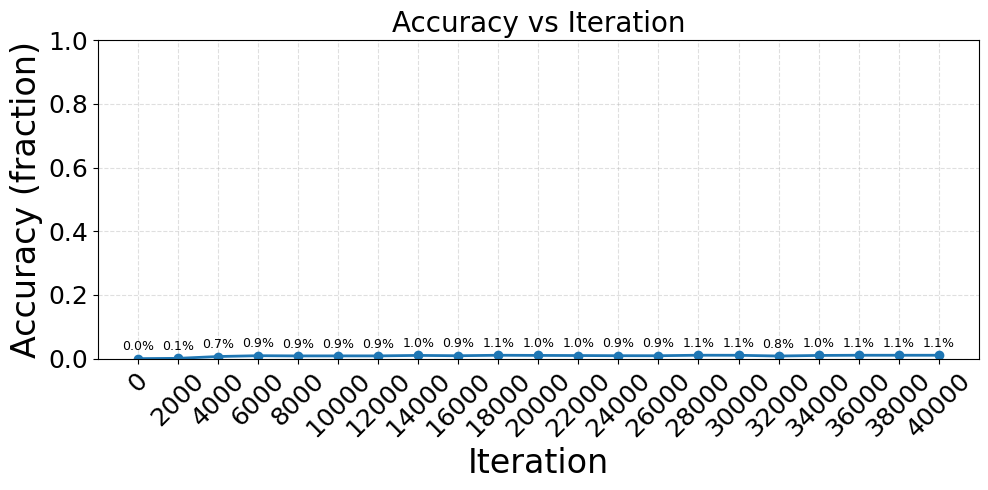

In [140]:
# Notebook cell: compute & plot accuracy vs iteration from a CSV with pred_iter_* columns
# Paste into a Jupyter / Colab notebook cell and run.
%matplotlib inline

import re
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

# ---------- User settings ----------
csv_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_uniform/100M_reverse_out/100M_4_operands_0_to_999_uniform_reverse/test_reverse_results.csv'     # <- set your CSV path here
actual_col = "actual"     # <- name of the actual column
outpath = None            # <- set to "accuracy.png" to save the figure, or None
title = "Accuracy vs Iteration"
# -----------------------------------

def clean_and_parse_int(val):
    """Return int if val is an integer-like string, otherwise None."""
    if pd.isna(val):
        return None
    s = str(val).strip()
    s = s.strip(" '\"`")           # remove surrounding quotes/backticks if any
    if re.fullmatch(r'[+-]?\d+', s):
        try:
            return int(s)
        except ValueError:
            return None
    return None

def find_pred_columns(columns):
    """Return list of (colname, iteration_number) for columns named pred_iter_<num>."""
    results = []
    for c in columns:
        m = re.match(r'pred_iter_(\d+)$', c)
        if m:
            results.append((c, int(m.group(1))))
    return sorted(results, key=lambda x: x[1])

def compute_accuracies(df, actual_col='actual'):
    """Return (iterations_list, accuracies_list) where accuracy is fraction 0..1."""
    if actual_col not in df.columns:
        raise KeyError(f"Actual column '{actual_col}' not found in CSV columns: {list(df.columns)}")
    pred_cols = find_pred_columns(df.columns)
    if not pred_cols:
        raise ValueError("No pred_iter_* columns found in the CSV.")
    parsed_actuals = df[actual_col].apply(clean_and_parse_int)
    total = len(df)
    iterations = []
    accuracies = []
    for colname, it in pred_cols:
        parsed_preds = df[colname].apply(clean_and_parse_int)
        correct = (parsed_preds.notna()) & (parsed_preds == parsed_actuals)
        acc = correct.sum() / total if total > 0 else 0.0
        iterations.append(it)
        accuracies.append(acc)
    return iterations, accuracies

# Read CSV (robust: read everything as string)
df = pd.read_csv(csv_path, dtype=str)
iters, accs = compute_accuracies(df, actual_col=actual_col)

# Build and display a small summary table
acc_df = pd.DataFrame({"iteration": iters, "accuracy_fraction": accs})
acc_df["accuracy_pct"] = (acc_df["accuracy_fraction"] * 100).round(3)
display(acc_df.style.hide_index())

# Print a concise table to stdout as well
print("Iteration\tAccuracy (fraction)\tAccuracy (%)")
for it, a in zip(iters, accs):
    print(f"{it}\t{a:.4f}\t{a*100:.3f}%")

# Plot
plt.figure(figsize=(10,5))
plt.plot(iters, accs, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Accuracy (fraction)')
plt.title(title)
plt.grid(True, linestyle='--', alpha=0.4)
plt.ylim(0.0, 1.0)
plt.xticks(iters, rotation=45)
# annotate points with percentage labels
for x, y in zip(iters, accs):
    plt.annotate(f"{y*100:.1f}%", (x, y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=9)
plt.tight_layout()
if outpath:
    plt.savefig(outpath, dpi=200)
    print(f"Saved figure to {outpath}")
plt.show()


In [165]:
def get_abc_new(abc: str, data_format="plain", mode: str = "compute_gold"):
    """Unified parser: mode='compute_gold' computes the groudtruth on the fly;
       mode='read_gold_as_str' reads the groundtruth from the evaluation files (testing, validation) to do string matching.
    Returns either
      (operands_str, result_int, operation)            # compute_gold
    or
      (operands_str, result_str)                      # read_gold_as_str
    """

    def _is_permutation_of_1_to_n(perm: str, n: int) -> bool:
        """Return True if perm is a permutation of '1'..str(n)."""
        if len(perm) != n:
            return False
        try:
            expected = {str(i) for i in range(1, n + 1)}
            return set(perm) == expected
        except Exception:
            return False

    # Split the input string into parts
    parts = abc.split('=')
    if len(parts) != 2:
        print(f'Invalid format, expected "a+b+c...=result", got: {abc}')
        return None, None, None

    # Get the operands part (before =)
    operands_str = parts[0]
    if operands_str and operands_str[0] == '$':
        operands_str = operands_str[1:]
    if operands_str.startswith('Input:\n'):
        operands_str = operands_str.split('Input:\n')[-1]
    if 'Target' in operands_str:
        operands_str = operands_str.split('\nTarget')[0]

    # version 1: compute the result
    if mode == "compute_gold":
        if '+' in abc:
            operation = '+'
        elif '-' in abc:
            operation = '-'
        elif '*' in abc:
            operation = '*'
        else:
            print(f'operation not found, abc: {abc}')
            return None, None, None
        # Split into individual operands
        operands = [op.strip() for op in operands_str.split(operation)]

        # Clean up operands
        operands = [op.replace(' ', '') for op in operands]

        if operation == '+':
            result = sum(int(op) for op in operands)
        elif operation == '-':
            result = int(operands[0]) - sum(int(op) for op in operands[1:])
        elif operation == '*':
            result = 1
            for op in operands:
                result *= int(op)
        else:
            raise ValueError(f"Unsupported operation: {operation}")

        return operands_str, result, operation

    # version 2: read the groundtruth from the evaluation files
    if mode == "read_gold_as_str":
        # parts[1] is the result part, which may contain a trailing '$' or newline
        result_str = parts[1].strip()
        if result_str.endswith('\n'):
            result_str = result_str[:-1].strip()
        if result_str.endswith('$'):
            result_str = result_str[:-1].strip()

        # Preserve and strip sign if present
        sign = ''
        if result_str and (result_str[0] == '-' or result_str[0] == '+'):
            sign = result_str[0]
            core = result_str[1:]
        else:
            core = result_str

        # normalize data_format naming
        df = (data_format or "").lower()
        if df in ("plain", "normal", "1234"):
            # no change
            normalized = core
        elif df in ("reverse", "reversed", "4321"):
            # reverse digits back to canonical order
            normalized = core[::-1]
        else:
            # try to interpret data_format as a permutation like "2143"
            # Only attempt if permutation length matches core length and it's a permutation of 1..n
            perm = data_format.strip()
            n = len(core)
            if _is_permutation_of_1_to_n(perm, n):
                # inverse-permute: given output[j] = s[perm[j]-1], we recover s by:
                s_list = [''] * n
                for j, ch in enumerate(core):
                    target_idx = int(perm[j]) - 1  # where this char belongs in the original string
                    if 0 <= target_idx < n:
                        s_list[target_idx] = ch
                    else:
                        # malformed perm, fallback to core unchanged
                        s_list = None
                        break
                if s_list is None or '' in s_list:
                    # fallback: treat as plain if something went wrong
                    normalized = core
                else:
                    normalized = ''.join(s_list)
            else:
                # unknown format: fallback to treating as plain (no-op)
                normalized = core

        # reattach sign if present
        result_str_canonical = (sign + normalized) if sign else normalized

        return operands_str, result_str_canonical

    # If an unknown mode is passed
    print(f"Unknown mode: {mode}")
    return None, None, None


abc = "349+102+382+907=7104$"
operand_str, result_str = get_abc_new(abc, data_format="2143", mode="read_gold_as_str")
print(f"Operands: {operand_str}, Result: {result_str}")

Operands: 349+102+382+907, Result: 1740


In [21]:
digit_places_list = [('hundreds', 'hundreds', 'thousands', 'hundreds')]
    
M = len(digit_places_list) # number of MI measurements, each measurement corresponds to a set of (X, Y, Z, carry)
xyz_mi_list = []
for k, places in enumerate(digit_places_list):
    print(k)
    print(places)

0
('hundreds', 'hundreds', 'thousands', 'hundreds')


In [27]:
import re
from typing import List, Tuple, Optional, Union, Iterable
import numpy as np


def gen_stats_test(num_operands, size=3, min=0, max=999, reverse=False, digits_per_num=None, mask=False):
    """
    gen_tats_test generates a dataset (a list of addition expression strings)
    Arguments:
        size: the size of dataset, namely the number of lines (list elements)
        min, max: minimum and maximum integers of the range to be sampled
        reverse: bool indicating whether the result is reversed
        digits_per_num: the number of digits in each operand; if specified, max will be overwritten
        mask: bool indicating whether small results are filtered and removed from dataset
    Returns:
        lines: a list of strings that represent addition math expressions
    """
    if digits_per_num is not None:
        max = (10 ** digits_per_num) - 1
    operands = np.empty((size,num_operands), dtype=int)
    for k in range(num_operands):
        operands[:,k] = np.random.randint(min,max,size)
    results = operands.sum(axis=1)
    if mask:
        mask = (results >= 10 ** (int(np.log10(max))))
        operands = operands[mask]
        results = results[mask]
        size = operands.shape[0]

    lines = []
    for j in range(size):
        if reverse:
            line = "+".join([f"{str(operands[j,k])}" for k in range(num_operands)]) + f"={str(results[j])[::-1]}$"
        else:
            line = "+".join([f"{str(operands[j,k])}" for k in range(num_operands)]) + f"={str(results[j])}$"
        lines.append(line)
    return lines

def _extract_numbers_with_positions(line: str) -> List[Tuple[str, int]]:
    """Extract digit sequences and their start indices from ``line``."""

    numbers: List[Tuple[str, int]] = []
    current_start: Optional[int] = None

    for idx, ch in enumerate(line):
        if ch.isdigit():
            if current_start is None:
                current_start = idx
        else:
            if current_start is not None:
                numbers.append((line[current_start:idx], current_start))
                current_start = None

    if current_start is not None:
        numbers.append((line[current_start:], current_start))

    return numbers

def _normalize_place(place: Union[str, int, None]) -> Union[str, int, None]:
    """Normalize textual place names to a canonical lowercase form."""

    if place is None or isinstance(place, int):
        return place

    normalized = str(place).replace("-", " ").replace("_", " ").lower().strip()
    normalized = " ".join(normalized.split())  # collapse repeated whitespace
    return normalized

def _place_to_offset(place: Union[str, int, None]) -> Optional[int]:
    """Convert a place specifier (e.g. "unit", 0) into a digit offset."""

    if place is None:
        return None

    if isinstance(place, int):
        if place < 0:
            raise ValueError("Digit offsets must be non-negative integers.")
        return place

    normalized = _normalize_place(place)

    place_mapping = {
        "unit": 0,
        "units": 0,
        "ones": 0,
        "one": 0,
        "tens": 1,
        "ten": 1,
        "hundreds": 2,
        "hundred": 2,
        "thousands": 3,
        "thousand": 3,
        "ten thousands": 4,
        "ten thousand": 4,
        "hundred thousands": 5,
        "hundred thousand": 5,
    }

    if normalized not in place_mapping:
        raise ValueError(f"Unsupported place specifier: {place}")

    return place_mapping[normalized]

def _digit_index(start_idx: int, number: str, place_offset: int, reverse: bool) -> Optional[int]:
    """Return the absolute index for a requested place within ``number``."""

    if place_offset >= len(number):
        return float('nan')

    if reverse:
        char_offset = place_offset
    else:
        char_offset = len(number) - 1 - place_offset

    return start_idx + char_offset

def new_find_indices(
    lines: Iterable[str],
    x_place: Union[str, int],
    y_place: Union[str, int],
    z_place: Union[str, int] = "unit",
    carry_place: Optional[Union[str, int]] = None,
    reverse: bool = False,
):
    """Return indices of requested place values for operands and result.

    ``x_place`` refers to the first operand on the left-hand side, while both
    ``y_place`` and ``z_place`` refer to the result on the right-hand side.
    """

    x_offset = _place_to_offset(x_place)
    y_offset = _place_to_offset(y_place)
    z_offset = _place_to_offset(z_place)
    carry_offset = _place_to_offset(carry_place)

    x_indices: List[Optional[int]] = []
    y_indices: List[Optional[int]] = []
    z_indices: List[Optional[int]] = []
    carry_indices: List[Tuple[Optional[int], ...]] = [] if carry_offset is not None else None

    for line in lines:
        numbers = _extract_numbers_with_positions(line)

        if len(numbers) < 3:
            raise ValueError(
                "Each line must contain at least two operands and one result in the format 'a+b= c'."
            )

        operands = numbers[:-1]
        result = numbers[-1]

        if len(operands) < 2:
            raise ValueError("Need at least two operands to extract x and y indices.")

        first_operand = operands[0]
        result_number = result

        def _lookup(entry: Tuple[str, int], offset: Optional[int], reverse: bool) -> Optional[int]:
            if offset is None:
                return None
            digits, start_idx = entry
            return _digit_index(start_idx, digits, offset, reverse)

        x_indices.append(_lookup(first_operand, x_offset, False))
        y_indices.append(_lookup(result_number, y_offset, reverse))
        z_indices.append(_lookup(result_number, z_offset, reverse))

        if carry_offset is not None and carry_indices is not None:
            carry_indices.append(tuple(_lookup(operand, carry_offset, False) for operand in operands))

    if carry_indices is not None:
        return x_indices, y_indices, z_indices, carry_indices
    return x_indices, y_indices, z_indices


num_operands = 4
mi_lines = gen_stats_test(num_operands, reverse=False)
print(mi_lines[:5])
places = ('hundreds', 'hundreds', 'thousands', 'hundreds')
x_indices, y_indices, z_indices, carry_indices = new_find_indices(mi_lines, places[0], places[1], places[2], carry_place=places[3], reverse=False)
print("X indices:", x_indices[:5])
print("Y indices:", y_indices[:5])
print("Z indices:", z_indices[:5])
print("Carry indices:", carry_indices[:5])

['430+180+333+387=1330$', '609+888+133+386=2016$', '954+82+646+966=2648$']
X indices: [0, 0, 0]
Y indices: [17, 17, 16]
Z indices: [16, 16, 15]
Carry indices: [(0, 4, 8, 12), (0, 4, 8, 12), (0, nan, 7, 11)]


In [33]:
my_list_x = [2, 0, 2, 6]
my_tensor_x = torch.tensor(my_list_x)
unique_x, inverse_x, counts_x = torch.unique(
    my_tensor_x, return_inverse=True, return_counts=True
)
print("Unique values:", unique_x)
print("Inverse indices:", inverse_x)
print("Counts:", counts_x)

my_list_y = [1,1,1,3]
my_tensor_y = torch.tensor(my_list_y)
unique_y, inverse_y, counts_y = torch.unique(
    my_tensor_y, return_inverse=True, return_counts=True
)
print("Unique values:", unique_y)
print("Inverse indices:", inverse_y)
print("Counts:", counts_y)

joint_indices = inverse_x * unique_y.numel() + inverse_y
print("Joint indices:", joint_indices)
joint_counts = torch.bincount(
    joint_indices,
    minlength=unique_x.numel() * unique_y.numel(),
).reshape(unique_x.numel(), unique_y.numel())
print("Joint counts:\n", joint_counts)

Unique values: tensor([0, 2, 6])
Inverse indices: tensor([1, 0, 1, 2])
Counts: tensor([1, 2, 1])
Unique values: tensor([1, 3])
Inverse indices: tensor([0, 0, 0, 1])
Counts: tensor([3, 1])
Joint indices: tensor([2, 0, 2, 5])
Joint counts:
 tensor([[1, 0],
        [2, 0],
        [0, 1]])


In [35]:
max_digits = 4
weights = list(range(1, max_digits + 1))
total = max_digits * (max_digits + 1) / 2
print([weight / total for weight in weights])

[0.1, 0.2, 0.3, 0.4]


In [55]:
import random
from typing import List, Tuple, Optional, Sequence, Union
from dataclasses import dataclass


def _probabilities_from_max_digits(max_digits: int) -> List[float]:

    weights = list(range(1, max_digits + 1))
    total = max_digits * (max_digits + 1) / 2
    return [weight / total for weight in weights]


def _resolve_operand_probabilities(
    probabilities: Optional[Sequence[float]],
    max_digits: Optional[int],
    *,
    operand_name: str,
    default_max_digits: int,
) -> Sequence[float]:

    if probabilities is not None:
        return probabilities

    if max_digits is None:
        max_digits = default_max_digits

    return _probabilities_from_max_digits(max_digits)


def _resolve_probability_sources(
    a_probabilities: Optional[Sequence[float]],
    b_probabilities: Optional[Sequence[float]],
    a_max_digits: Optional[int],
    b_max_digits: Optional[int],
    *,
    default_a_max_digits: int,
    default_b_max_digits: int,
) -> Tuple[Sequence[float], Sequence[float]]:
    """Determine the operand distributions based on the provided inputs."""

    resolved_a = _resolve_operand_probabilities(
        a_probabilities,
        a_max_digits,
        operand_name="a",
        default_max_digits=default_a_max_digits,
    )
    resolved_b = _resolve_operand_probabilities(
        b_probabilities,
        b_max_digits,
        operand_name="b",
        default_max_digits=default_b_max_digits,
    )
    return resolved_a, resolved_b

def _normalize_probabilities(values: Sequence[float]) -> List[float]:

    total = sum(values)

    return [v / total for v in values]


@dataclass(frozen=True)
class DigitLengthDistribution:
    """Distribution over digit lengths 1..N with cached sampling metadata."""

    probabilities: Tuple[float, ...]
    cumulative: Tuple[float, ...]
    ranges: Tuple[Tuple[int, int], ...]

    @property
    def num_lengths(self) -> int:
        return len(self.probabilities)

    def sample_length(self, rng: random.Random) -> int:
        """Draw a digit length in ``1..num_lengths`` according to the distribution."""

        draw = rng.random()
        print(f"Random draw: {draw}")
        for idx, threshold in enumerate(self.cumulative):
            # Guard against floating point round-off by returning the last bucket.
            if draw < threshold or idx == self.num_lengths - 1:
                return idx + 1
        return self.num_lengths

    def sample_value(self, rng: random.Random) -> Tuple[int, int]:
        """Sample a value and report the digit-length used for bookkeeping."""

        length = self.sample_length(rng)
        low, high = self.ranges[length - 1]
        value = rng.randint(low, high)
        return length, value


def _build_distribution(probabilities: Sequence[float]) -> DigitLengthDistribution:
    probs = tuple(_normalize_probabilities(probabilities))
    cumulative: List[float] = []
    running = 0.0
    for p in probs:
        running += p
        cumulative.append(running)

    ranges: List[Tuple[int, int]] = []
    for idx in range(len(probs)):
        digits = idx + 1
        low = 0 if digits == 1 else 10 ** (digits - 1)
        high = 10 ** digits - 1
        ranges.append((low, high))

    return DigitLengthDistribution(
        probabilities=probs,
        cumulative=tuple(cumulative),
        ranges=tuple(ranges),
    )

a_probabilities = None
b_probabilities = None
a_max_digits = 4
b_max_digits = 1
resolved_a, resolved_b = _resolve_probability_sources(
    a_probabilities,
    b_probabilities,
    a_max_digits,
    b_max_digits,
    default_a_max_digits=1,
    default_b_max_digits=1,
)
print("Resolved A probabilities:", resolved_a)
a_distribution = _build_distribution(resolved_a)
print("A distribution:", a_distribution)
seed = 42
rng = random.Random(seed)
for _ in range(3):
    length, value = a_distribution.sample_value(rng)
    print(f"Sampled A: length={length}, value={value}")

Resolved A probabilities: [0.1, 0.2, 0.3, 0.4]
A distribution: DigitLengthDistribution(probabilities=(0.1, 0.2, 0.3, 0.4), cumulative=(0.1, 0.30000000000000004, 0.6000000000000001, 1.0), ranges=((0, 9), (10, 99), (100, 999), (1000, 9999)))
Random draw: 0.6394267984578837
Sampled A: length=4, value=1409
Random draw: 0.7415504997598329
Sampled A: length=4, value=5012
Random draw: 0.22321073814882275
Sampled A: length=2, value=23


In [264]:
from pathlib import Path
from typing import Iterable

def write_lines_to_txt(lines: Iterable[str],
                       out_path: str,
                       filename: str,
                       mode: str = "w",
                       encoding: str = "utf-8") -> str:
    """
    Write an iterable of strings to a .txt file, one line per string.

    - out_path: either a directory path or a full .txt file path.
    - filename: used when out_path is a directory; ignored if out_path ends with .txt
    - mode: "w" to overwrite, "a" to append
    Returns the full path to the file that was written.
    """
    p = Path(out_path)
    # If out_path looks like a file (ends with .txt) treat it as a file
    if p.suffix.lower() == ".txt":
        file_path = p
        file_path.parent.mkdir(parents=True, exist_ok=True)
    else:
        # treat out_path as directory
        p.mkdir(parents=True, exist_ok=True)
        name = filename or "output.txt"
        file_path = p / name

    with file_path.open(mode, encoding=encoding) as f:
        for line in lines:
            # ensure exactly one newline per element
            f.write(line.rstrip("\n") + "\n")

    return str(file_path)

def gen_stats_test(num_operands, size=20_000_000, min=0, max=999, reverse=False, digits_per_num=None, mask=False):
    """
    gen_tats_test generates a dataset (a list of addition expression strings)
    Arguments:
        size: the size of dataset, namely the number of lines (list elements)
        min, max: minimum and maximum integers of the range to be sampled
        reverse: bool indicating whether the result is reversed
        digits_per_num: the number of digits in each operand; if specified, max will be overwritten
        mask: bool indicating whether small results are filtered and removed from dataset
    Returns:
        lines: a list of strings that represent addition math expressions
    """
    if digits_per_num is not None:
        max = (10 ** digits_per_num) - 1
    operands = np.empty((size,num_operands), dtype=int)
    for k in range(num_operands):
        operands[:,k] = np.random.randint(min,max,size)
    results = operands.sum(axis=1)
    if mask:
        mask = (results >= 10 ** (int(np.log10(max))))
        operands = operands[mask]
        results = results[mask]
        size = operands.shape[0]

    lines = []
    for j in range(size):
        if reverse:
            line = "+".join([f"{str(operands[j,k])}" for k in range(num_operands)]) + f"={str(results[j])[::-1]}$"
        else:
            line = "+".join([f"{str(operands[j,k])}" for k in range(num_operands)]) + f"={str(results[j])}$"
        lines.append(line)
    return lines

reverse = False
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis'
mi_lines = gen_stats_test(num_operands, reverse=reverse)
out_file = write_lines_to_txt(mi_lines, Output_file_path, filename='mi_lines_20M.txt')
print("Saved lines to:", out_file)

Saved lines to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/extra_result_analysis_scripts/addition_result_analysis/mi_lines_20M.txt


In [265]:
def get_abc_new(abc: str, data_format="plain", mode: str = "compute_gold"):
    """Unified parser: mode='compute_gold' computes the groudtruth on the fly;
       mode='read_gold_as_str' reads the groundtruth from the evaluation files (testing, validation) to do string matching.
    Returns either
      (operands_str, result_int, operation)            # v1
    or
      (operands_str, result_int, result_str, operation)  # v2
    """
    if '+' in abc:
        operation = '+'
    elif '-' in abc:
        operation = '-' 
    elif '*' in abc:
        operation = '*'
    elif "#" in abc:
        operation = ','
    else:
        print(f'operation not found, abc: {abc}')
        return None, None, None

    # Split the input string into parts
    parts = abc.split('#')
    if len(parts) != 2:
        print(f'Invalid format, expected "a+b+c...=result", got: {abc}')
        return None, None, None

    # Get the operands part (before =)
    operands_str = parts[0]
    if operands_str[0] == '$':
        operands_str = operands_str[1:]
    if operands_str.startswith('Input:\n'):
        operands_str = operands_str.split('Input:\n')[-1]
    if 'Target' in operands_str:
        operands_str = operands_str.split('\nTarget')[0]

    # Split into individual operands
    operands = [op.strip() for op in operands_str.split(operation)]
    
    # Clean up operands
    operands = [op.replace(' ', '') for op in operands]

    # version 1: compute the result
    if mode == "compute_gold":
        if operation == '+':
            result = sum(int(op) for op in operands)
        elif operation == '-':
            result = int(operands[0]) - sum(int(op) for op in operands[1:])
        elif operation == '*':
            result = 1
            for op in operands:
                result *= int(op)
        elif operation == ',':
            if len(operands) != 2:
                raise ValueError(f"Invalid number of operands for operation ',': {len(operands)}")
            if operands[0] > operands[1]:
                result = '>'
            elif operands[0] < operands[1]:
                result = '<'
            else:
                result = '='
        else:
            raise ValueError(f"Unsupported operation: {operation}")

        return operands_str, result, operation
    # version 2: read the groundtruth from the evaluation files
    if mode == "read_gold_as_str":
        # parts[1] is the result part, which may contain a trailing '$' or newline
        result_str = parts[1].strip()
        if result_str.endswith('\n'):
            result_str = result_str[:-1].strip()
        if result_str.endswith('$'):
            result_str = result_str[:-1].strip()
        if data_format == "reverse":
            sign = ''
            if result_str.startswith('-') or result_str.startswith('+'):
                sign = result_str[0]
                result_str = result_str[1:]
            result_str = sign + result_str[::-1]  # reverse the result string if needed

        return operands_str, result_str
    
operands, result = get_abc_new("9897,9892#>$", data_format="plain", mode="read_gold_as_str")
print(f"Operands: {operands}, Result: {result}")

Operands: 9897,9892, Result: >
